# Подготовка(запускается каждый раз при перезапуске нотубука)

Все подзаголовки, входящие в заголовок "Подготовка" перезапускаются каждый раз при перезапуске ноутбука.

### Монтирование диска и распаковка данных

In [2]:
# Завершить все процессы, использующие ГПУ в нашей ОС
!fuser -k /dev/nvidia[0]

/dev/nvidia0:        533271m


In [3]:
!nvidia-smi

Sat Aug 20 12:51:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:01:00.0 Off |                  Off |
|  0%   52C    P0    57W / 150W |      0MiB / 24564MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Импорт библиотек и инициализиция модулей

In [4]:
import torch
import pickle
import numpy as np
from skimage import io
import copy
from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# В замечательной статье PyTorch 101, Part 4: Memory Management and Using Multiple GPUs
# https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/
# описано что это позволяет оптимизировать использование памяти 
# и ускорить расчеты при использовании GPU Nvidia
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [6]:
torch.cuda.is_available()

True

In [7]:
#для воспроизводимости итогового Score попробуем зафиксировать ВСЕ случайные параметры
#еще я сохраняю веса обученных моделей, чтобы их можно было загрузить и проверить.
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

## Dataset
Поддерживает аугментацию изображений средствами фреймворка PyTorch для картинок из обучающей выборки "train".


In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок
    производит изменения размера картинок, аугментации и преобразование в тензоры
    PyTorch
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        
            # transforms.Normalize делается для того, чтобы подогнать наши 
            # данные под данные на которых были предобучены наши нейронные сети
            # из torchvision.models они были обученные  на наборе данных 
            # ImageNet в документации по самому torchvision.models так же 
            # сказано https://pytorch.org/docs/stable/torchvision/models.html

            # All pre-trained models expect input images normalized in the same way,
            # i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
            # where H and W are expected to be at least 224. The images have to be
            # loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406]
            # and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
            
            # И ниже код от самих разработчиков PyTorch
            # normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])

        # трансформация с аугментацией для обучающей выборки средствами PyTorch
        transform_augment = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(hue=.1, saturation=.1),
            transforms.ToTensor(),
            # mean и std для набора данных ImageNet на котором были обучены 
            # предобученные сети из torchvision
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        print(x.shape)
        #x = np.array(x / 255, dtype='float32') *см. примечание ниже

        # У нас тр режима датасета 
        # DATA_MODES = ['train', 'val', 'test']
        # train - обучающая выборка на которой мы обучаем нейросеть 
        # (есть картинки и ответы к ним)
        # val - валидационная выборка на которой мы тестируем как хорошо
        #  нейросеть обучилась! (есть картинки и ответы к ним)
        # test - тестовая выборка на которой мы предсказываем ответы для
        #  скора в соревновании (есть картинки ответов нет!)

        if self.mode == 'test': # если тестовая выборка у нас нет ответов и
            x = transform(x)    # датасет не должен аугментировать картинки
            return x
        else:
            if self.mode == 'train': # аугментируем обучающую выборку
                x = transform_augment(x)
            else:
                x = transform(x) # не аугментируем валидационную выборку

            # для train или val выборок у нас есть ответы по классам
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

**Примечание:** 

Согласно документации PyTorch ([torchvision.transforms.ToTensor](https://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.ToTensor))

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]).

Т.е. трансформация transforms.ToTensor() и так переведет PIL image из диапазона [0, 255] в диапазон [0.0, 1.0].

Поэтому строку:
```
x = np.array(x / 255, dtype='float32')
```
Я удалил ! =)


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Обощая все ноутбуки и документацию PyTorch, были собраны и модифицированы эти полезные функции:

### Полезные функции для сериализации и десериализации словарей (Losses и Accurancy)

In [ ]:
import pickle

def save_dict_to_file(my_dict, file_path):
    """Функция сохранения словаря my_dict в файл file_path с помощью модуля 
    pickle. (Сериализация).
    
    Parameters:

    my_dict : dict, словарь, который мы хоти сохранить.
    file_path : str, путь куда мы хотим сохранить включающий имя файла.
    """
    with open(file_path, 'wb') as handle:
        pickle.dump(my_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_dict_from_file(file_path):
    """Функция загрузки словаря из файла расположенного по пути file_path с 
    помощью модуля pickle. (Десериализация).
    
    Parameters:

    file_path : str, путь по которому мы хотим загрузить, сохраненный ранее 
        словарь.
    """
    with open(file_path, 'rb') as handle:
        unserialized_data = pickle.load(handle)
        
    return unserialized_data

def save_model(path, model, losses, acc, best_model_wts):
    """Функция для сохранения состояние нашей нейросети model 
    (ее весов state_dict()), а так же словарей с losses и accurancy за весь 
    процесс обучения.

    Parameters:

    path : str, путь по которому мы хотим сохранить веса нейросети model, 
        а так же словари losses и acc.
        словарь.
    model : обученная нейросеть, содержит веса своего текущего состояния 
        после обучения.
    losses : dict, ключи 'train' и 'val' содержат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    acc : dict, ключи 'train' и 'val' содержат list, в котором сохранены
        значения accurancy на каждой эпохе обучения.
    best_model_wts : model.state_dict() содержит веса обучаемой нейросети
        model, при которых была получена лучшая точность на валидационной 
        выборке.
    """

    torch.save(model.state_dict(), path + '.pth')
    torch.save(best_model_wts, path + '_best_w.pth')
    save_dict_to_file(losses, path + '_losses.pickle')
    save_dict_to_file(acc, path + '_acc.pickle') 

### Полезные функции для обучения нейросети

In [ ]:
from tqdm import tqdm_notebook
import time
import logging

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                scheduler=None, use_gpu=True, best_acc=None,
                flag_save_wts_to_file = False, path = None, losses=None, 
                acc=None):
    
    """Модифицированная мной функция тренировки модели из 
    https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial

    Тестировалась в новой версии PyTorch 1.5
    Ключевые особенности:
    1. Сохраняет веса модели, если была достигнута лучшая точность на этапах 
    валидации, чем ранее на каждой эпохе в переменную best_model_wts. 
    (Далее эти веса при необходимости могут быть загружены в модель)
    2. Можно задать порог точности для сохранения best_model_wts, например,
    мы уже обучили модель на 0.9700 точности. Сохранили ее веса и продолжаем 
    обучение, зададим порог по точности не ниже полученной ранее. Тогда в 
    best_model_wts будут записаны веса модели лишь в том случае, если модель
    улучшила свою точность в процессе нового обучения.
    3. Имеет поддержку планировщика learning rate (scheduler), работающего один 
    раз за эпоху обучения.
    4. При обучении веса модели с последней эпохи обучения и при которой была 
    достигнута лучшая точность а так же losses и accurancy могут сохраняться
    на каждой эпохе обучения по указанному пути path(Я сохранял на Google Диск).
    Это удобно если вдруг обучение модели прервалось, у нас будут последние веса
    и обучение может быть продолжено с места разрыва. За это отвечает флаг 
    flag_save_wts_to_file.
    5. При включении flag_save_wts_to_file ведет лог обучения (все print) в файл.
    Это сделано на тот случай если print в Google Colab не сохраняться. При 
    обучении моделей на локальной машине print в ноутбуке в случае выключения 
    машины скорее всего точно не сохранятся, и тут нам помогут лог-файлы.
    6. Возможно продолжение обучения с прерванного места, для этого надо просто
    загрузить в модель веса с последней эпохи, и передать в эту функцию 
    сохраненные losses как losses и accurancy как acc и достигнутое ранее 
    значение лучшей точности при которой было сохранено последнее значение
    лучших весов(тут надо смотреть лог-файл) как best_acc.
    7. Если мы используем технику раздельного lr для различных групп слоев нашей
    модели данная функция будет писать список всех lr используемых нашей моделью
    на каждой эпохе обучения. Да же если мы используем отдельных lr для каждого
    слоя модели.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    criterion : loss функция из модуля torch.nn.
    optimizer : оптимизатор из модуля torch.optim.
    num_epochs : int, число эпох обучения.
    scheduler : планировщик learning rate из torch.optim, рассчитанный на простую
    работу один раз в эпоху и не использующего losses или accurancy для своей 
    работы. (По умолчанию None).
    use_gpu : bool, используем ли мы GPU в расчетах ? (По умолчанию True)
    best_acc : float (в долях, не в процентах!), задать порог точности для 
        сохранения best_model_wts, например мы уже обучили модель на 0.9700 
        точности. Сохранили ее веса и продолжаем обучение, зададим порог по 
        точности не ниже полученной ранее. Тогда в best_model_wts будут 
        записаны веса модели лишь в том случае если модель улучшила свою 
        точность в процессе нового обучения. (По умолчанию None)
    flag_save_wts_to_file : bool, хотим ли сохранять веса модели с последней 
        эпохи обучения и при которой была достигнута лучшая точность, а так же
        losses и accurancy на каждой эпохе обучения по указанному пути path
        (Я сохранял на Google Диск).
        Это удобно если вдруг обучение модели прервалось, у нас будут последние
        веса и обучение может быть продолжено с места разрыва.
        Замедляет обучение на сохранение моделей в файл, имеет смысл 
        использовать для моделей где обучение одной эпохи длится более 5 минут.
        Тогда практически не заметно. (По умолчанию False).
    path : string, путь по которому мы будем сохранять веса модели, а так же 
        losses и accurancy. Путь состоит из пути к папке и названия модели
        Пример, path = '/content/gdrive/My Drive/folder/model_name'
        (По умолчанию False, его необходимо задать если 
        flag_save_wts_to_file = True)
    losses : dict вида {'train': list значений loss, полученных эпохе на обучающей выборке,
                        'val': list значений loss, полученных на эпохе на валидационной выборке}
            используется при продолжении обучения с места разрыва, так не нужен.
            (По умолчанию None).
    acc : dict вида {'train': list значений accurancy, полученных эпохе на обучающей выборке,
                        'val': list значений accurancy, полученных на эпохе на валидационной выборке}
            используется при продолжении обучения с места разрыва, так не нужен.
            (По умолчанию None).

    Returns:
    
    model : обученная нейросеть, содержит веса своего текущего состояния 
        после обучения.
    losses : dict, ключи 'train' и 'val' содержат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    acc : dict, ключи 'train' и 'val' содержат list, в котором сохранены
        значения accurancy на каждой эпохе обучения.
    best_model_wts : model.state_dict() содержит веса обучаемой нейросети
        model, при которых была получена лучшая точность на валидационной 
        выборке.
    """
    since = time.time()

    if flag_save_wts_to_file:
        if path is None:
            raise ValueError('Вы хотите сохранять веса, но не задали путь в переменную path!')
        else:
            print('Logging...')
            logging.basicConfig(level=logging.INFO, filemode='w', filename=path + '_log_file.txt')
            logger = logging.getLogger(__name__)

    best_model_wts = copy.deepcopy(model.state_dict())
    epoch_best_acc = 0
    
    if best_acc is None:
        best_acc = 0.0
    
    if losses is None and acc is None:
        losses = {'train': [], 'val': []}
        acc = {'train': [], 'val': []}
    
    for epoch in tqdm_notebook(range(num_epochs)):
        if scheduler is None:
            lr_epoch = []
            # выводим lr для каждой группы слоев которую мы определили
            # если мы используем один lr для всех обучаемых слоев выведет его
            for param_group in optimizer.param_groups:
                lr_epoch.append(param_group["lr"])
        else:
            lr_epoch = scheduler.get_lr()
            
        print(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
        print('-' * 10)

        if flag_save_wts_to_file:
            logger.info(f'Epoch {epoch}/{num_epochs - 1} lr={lr_epoch}')
            logger.info('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # установить модель в режим обучения
            else:
                model.eval()  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for inputs, labels in dataloaders[phase]:
                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # активируем расчет градиентов для фазы обучения
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # сделаем backward шаг оптимизатора если сейчас фаза обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # подсчитаем статистику по эпохе
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if flag_save_wts_to_file:
                logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # если на валидационной выборке удалось получить лучшую,
            # чем ранее точность, то запомним веса модели в best_model_wts
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epoch_best_acc = epoch
                print(f'\n***new best wts with acc {best_acc} at {epoch_best_acc} epoh***')
                if flag_save_wts_to_file:
                    torch.save(best_model_wts, path + '_best_w.pth')
                    logger.info(f'save new best wts with acc {best_acc} at {epoch_best_acc} epoh')

        if flag_save_wts_to_file:
            print(f'*** save model wts at this {epoch} epoch ! *** \n')
            torch.save(model.state_dict(), path + '.pth')
            save_dict_to_file(losses, path + '_losses.pickle')
            save_dict_to_file(acc, path + '_acc.pickle')
            logger.info(f'*** save model wts at this {epoch} epoch ! *** \n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))

    if flag_save_wts_to_file:
        logger.info('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        logger.info('Best val Acc: {:4f} at {}'.format(best_acc, epoch_best_acc))

    logging.shutdown() # выключаем логирование

    return model, losses, acc, best_model_wts

def visualize_model(model, dataloaders, num_images=6, use_gpu =True):
    """Функция для отрисовки тестовых изображений и предсказаний для них.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    num_images : int, число картинок, которые хотим отрисовать и сделать на них 
        предсказания.
    use_gpu : bool, используем ли мы GPU в расчетах ?
    """
    images_so_far = 0
    fig = plt.figure()

    # Контекстный менеджер, который отключает вычисление градиентов.
    # отключаем вычисление градиентов, мы только предсказываем, а не обучаем.
    # экономит оперативную память GPU и ускоряет расчеты.
    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs, labels = data['image'], data['label']
            if use_gpu:
                inputs, labels = Variable(inputs.to(DEVICE)), Variable(labels.to(DEVICE))
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return
              
def evaluate(model, dataloader_val, DEVICE, use_gpu =True):
    '''Функция для измерения точности модели на валидационном датасете
    метрика accurancy
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloader_val : torch.utils.data.DataLoader загрузчик картинок из 
        валидационной выборки.
    use_gpu : bool, используем ли мы GPU в расчетах ?

    Returns:

    accurancy : float, число accurancy [0. ,1.], полученная на валидационной 
        выборке.
    '''
    model.eval() # перевели модель в режим предсказание
    
    runninig_correct = 0
    # Контекстный менеджер, который отключает вычисление градиентов.
    # отключаем вычисление градиентов, мы только предсказываем, а не обучаем.
    # экономит оперативную память GPU и ускоряет расчеты.
    with torch.no_grad(): 
        for inputs, labels in dataloader_val:
            # переносим на GPU, если оно используется
            if use_gpu:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
            # forard pass
            output = model(inputs)
            _, predicted = torch.max(output, 1)
            
            runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / len(dataloader_val.dataset)

def predict(model, test_loader):
    """Сделать предсказание нейросетью model на выборке из загрузчика 
    test_loader.
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    test_loader : torch.utils.data.DataLoader загрузчик картинок из 
        валидационной или тестовой выборки.
    use_gpu : bool, используем ли мы GPU в расчетах ?
    
    Returns:

    probs : torch.tensor, массив предсказаний нашей нейросети model
    """
    model.eval() # перевели модель в режим предсказание
    logits = []

    # Контекстный менеджер, который отключает вычисление градиентов.
    # отключаем вычисление градиентов, мы только предсказываем, а не обучаем.
    # экономит оперативную память GPU и ускоряет расчеты.
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def weights_init_uniform_rule(m):
    """Функция иницализации весов для слоев Linear, данная инициализация вроде 
    бы как должна улучшать сходимоть, но я не заметил этого. И потому в коде она
    не используется
    Источник:
    https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    """
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [ ]:
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    """Функция для поиска оптимального learning rate, модифицирована мной для 
    поддержки GPU.

    Суть подхода заключается в том, чтобы обучать нейросеть на каждом батче с 
    различным уровнем lr, начиная с самого малого init_value в выбранном нами 
    диапазоне [init_value, final_value] и заканчивая самым большим final_value. 
    При этом мы будем записывать в массив значение lr и полученного на этом 
    значении lr значение loss функции. В результате мы получим таблицу
    зависимости loss от значения lr. Построив по ним график, в области
    резкого снижения полученных значений loss функции и будет оптимальный 
    для обучения lr.

    Функция взята из замечательной книги книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019).
    Ccылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
    Chapter 4. "Transfer Learning and Other Tricks" про "Transfer Learning with ResNet50" и
    "Finding That Learning Rate".
    Сделана автором книги на основе подхода описанного в статье
    “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith (2015).
    Однако популярным данный подход сделал Jeremy Howard автор курса fast.ai
    Эта функция так же сделана на основе реализации подобного подбора в 
    библиотеке fast.ai функции lr_find()
    https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e
    Функция из fast.ai лучше, но это сделана на чистом PyTorch и хорошо
    показывает идею.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.
    loss_fn : loss функция из модуля torch.nn.
    optimizer : оптимизатор из модуля torch.optim.
    init_value : float, начальное значение learning rate, из выбранного нами
        диапазона.
    final_value : float, конечное значение learning rate.
    use_gpu : bool, используем ли мы GPU в расчетах ?

    Returns:

    log_lrs : list, содержащий степень 10 от исследованных нами lr(десятичный 
        логарифм от lr)
    losses : list, содержащий полученные значения loss функции.
    """
    model.train() # переключаем модель в режим обучения

    number_in_epoch = len(dataloaders['train']) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders['train']:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]

In [ ]:
def print_learn_params(model):
    """Функция напечатает все веса нейросети model, которые мы обучаем.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    Returns: list, спиок параметров слоев нейросети, которые мы обучаем,
            будет отдан оптимизатору.
    """
    print('Params to update:')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    return params_to_update

def print_params(model):
    """Функция напечатает все веса нейросети model, которые мы можем обучать.

    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    Returns:

    params_number_name: python dict вида {'num': список значений порядковых 
                                                номеров слоя нейросети,
                                        'param_name': название слоев нейросети
                                         идущих по порядку}
    """
    print('Params to update:')
    i = 0
    params_to_learn = {'num':[], 'param_name':[]}
    for name,param in model.named_parameters():
        params_to_learn['num'].append(i)
        params_to_learn['param_name'].append(name)
        print(f"{i} {name}")
        i += 1

    return params_to_learn


def show_param_lr_plots(params_number_name, lrs, layer_names=False, figsize=None):
    """Функция для построения графика значений learning rate(lr) по всем слоям 
    которые мы учим нейросети, чтобы посмотреть какие lr мы задаем для слоев
    нейросети.

    Parameters:

    params_number_name: python dict вида {'num': список значений порядковых номеров слоя нейросети,
                                     'param_name': название слоев нейросети идущих по порядку}

    lrs: python list, содержит значения learning rate для каждого из слоев нейросети.
        его длинна должна равняться число слоев нейросети.

    layer_names : bool, хоти ли мы отобразить по оси Х названия слоев нейросети? (по умолчанию False)
    figsize: задать соотношение сторон для графика (figsize для figure нашего графика)
    """
    plt.clf()

    if figsize is None:
        figsize = (12, 8)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(params_number_name['num'], lrs, 'r', label='learning rate')
    ax.set_title('learning rate for all layers of neuronet')
    ax.set_xlabel('layers')
    ax.set_ylabel('lr')
    if layer_names:
        ax.set_xticks(params_number_name['num'])
        ax.set_xticklabels(params_number_name['param_name'])
        ax.xaxis.set_tick_params(rotation=90)
    plt.legend()
    plt.show()


def set_learn_params(model, lrs):
    """Функция которая задаст каждому слою нейросети значения learning rate из списка lrs.

    Parameters:

    model: torchvision.models или самописаная нейронная сеть созданная
        в PyTorch или предобученная из torchvision.models.

    lrs: python list, содержит значения learning rate для каждого из слоев нейросети.
    его длинна должна равняться число слоев нейросети.

    Returns: list, спиок слоев нейросети, которые мы обучаем
            и lr для каждого из них, будет отдан оптимизатору.
    """
    print('Params to learn:')
    learn_params = []
    i = 0

    for name, param in model.named_parameters():
        if param.requires_grad == True:
            learn_params.append({'params': param, 'lr': lrs[i]})
            print(f'{lrs[i]} {name}')
        i += 1

    return learn_params

### Оптимизатор AdaShift (взят из репозитория МФТИ [AdaShift](https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py))

В данном репозитории лежит самостоятельно написанная сотрудниками МФТИ реализация нового оптимизатора AdaShift для PyTorch.

https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py

там же дана ссылка на оригинальную статью по данный оптимизатор

Reproducing of the AdaShift: Decorrelation and Convergence of Adaptive Learning Rate Methods as a part of ICLR Reproducibility Challange 2019. See our report.

Можно завести отдельную ячейку с данным оптимизатором и использовать его для обучения нейросети )

In [ ]:
""" Implements AdaShift optimizer. """
# здесь я просто взял готовый оптимизатор AdaShift, релизованный в реползитории 
# МФТИ (https://github.com/MichaelKonobeev/adashift/blob/master/adashift/optimizers.py)
from collections import deque

from torch.optim import Optimizer


class AdaShift(Optimizer):
  r""" Implements AdaShift algorithm.
  See https://openreview.net/forum?id=HkgTkhRcKQ
  Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
      parameter groups
    lr (float, optional): learning rate
    keep_num (int): number of gradients used to compute first moment
      estimation.
    betas (Tuple[float, float], optional): coefficients used for computing
     running averages of gradient and its square
    eps (float, optional): term added to the denominator to improve
      numerical stability
    reduce_func (callable or None): function applied to squared gradients
      to further reduce the correlation. If None, no function is applied.
  """
  def __init__(self, params, lr=1e-3, keep_num=10, betas=(0.9, 0.999),
               eps=1e-10, reduce_func=torch.max):
    beta1, _ = betas
    exp_weight_sum = sum(beta1 ** i for i in range(keep_num))
    first_grad_weight = beta1 ** (keep_num - 1) / exp_weight_sum
    last_grad_weight = 1. / exp_weight_sum
    defaults = dict(lr=lr, keep_num=keep_num, betas=betas,
                    eps=eps, reduce_func=reduce_func,
                    first_grad_weight=first_grad_weight,
                    last_grad_weight=last_grad_weight)
    super(AdaShift, self).__init__(params, defaults)

  def step(self, closure=None):
    loss = None
    if closure is not None:
      loss = closure()

    for group in self.param_groups:
      for p in group["params"]:
        if p.grad is None:
          continue
        grad = p.grad.data
        if grad.is_sparse:
          raise RuntimeError("AdaShift does not support sparse gradients.")

        state = self.state[p]
        if len(state) == 0:
          state["step"] = 1
          state["grad_deque"] = deque([grad.clone()], maxlen=group["keep_num"])
          state["exp_avg"] = torch.zeros_like(p.data)
          state["exp_avg_sq"] = torch.zeros_like(p.data)
          continue

        grad_deque = state["grad_deque"]
        exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

        state["step"] += 1
        grad_apply = len(grad_deque) == group["keep_num"]
        offset_grad = grad_deque[0]
        grad_deque.append(grad.clone())
        if not grad_apply:
          continue

        first_grad_weight = group["first_grad_weight"]
        last_grad_weight = group["last_grad_weight"]
        beta1, beta2 = group["betas"]
        (exp_avg.sub_(first_grad_weight, offset_grad).mul_(beta1)
         .add_(last_grad_weight, grad))

        reduce_func = group["reduce_func"] or (lambda x: x)
        reduced_grad_sq = reduce_func(offset_grad.mul_(offset_grad))
        exp_avg_sq.mul_(beta2).add_(1 - beta2, reduced_grad_sq)
        bias_correction = 1 - beta2 ** (state["step"] - group["keep_num"])
        denom = exp_avg_sq.div(bias_correction).sqrt_().add_(group["eps"])

        p.data.addcdiv_(-group["lr"], exp_avg, denom)

    return loss

### Полезные функции для построения графиков (Losses и Accurancy)

In [ ]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    """Функция для сглаживания графиков
    
    Parameters:

    points : list or numpy.array содержащий значения амплитудных отсчетов
        графика, который необходимо сгладить.
    factor : float, коэффициент сглаживания.

    Returns:

    points : list содержащий значения амплитудных отсчетов сглаженного графика.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def show_losses_plots(losses, smooth_flag = False, min = 0):
    """Функция для построения графиков loss функции по всем эпохам обучения 
    нейросети.
    
    Parameters:

    losses : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения loss функции на каждой эпохе обучения.
    smooth_flag : bool, осуществить сглаживание графика ?
    min : int, с какой эпохи начать ось абсцисс ?
    """
    plt.clf()

    losses_train, losses_test = losses['train'], losses['val']
    epochs = np.arange(len(losses_train))

    #Сглаживаем ли мы графики функций потерь?
    if smooth_flag:
      losses_train = smooth_curve(losses_train)
      losses_test = smooth_curve(losses_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], losses_train[min:], 'r', label='Training loss')
    plt.plot(epochs[min:], losses_test[min:], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def show_acc_plots(acc, smooth_flag = False, min = 0):
    """Функция для построения графиков accurancy по всем эпохам обучения 
    нейросети.
        
    Parameters:

    acc : dict, ключи 'train' и 'val' содежат list, в котором сохранены
        значения accurancy функции на каждой эпохе обучения.
    smooth_flag : bool, осуществить сглаживание графика ?
    min : int, с какой эпохи начать ось абсцисс ?
    """
    plt.clf()

    acc_train, acc_test = acc['train'], acc['val']
    epochs = np.arange(len(acc_train))

    #Сглаживаем ли мы графики функций точности?
    if smooth_flag:
      acc_train = smooth_curve(acc_train)
      acc_test = smooth_curve(acc_test)

    # Построим график лосса при обучении и валидации
    plt.plot(epochs[min:], acc_train[min:], 'r', label='Training acc')
    plt.plot(epochs[min:], acc_test[min:], 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

### Функции для оценки точности (**confusion** matrix, и точность по каждому классу)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция из документации matplotlib, отрисовывающая confusion matrix 
    Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html  

    Parameters:

    cm : Рассчитанная confusion matrix возвращаемая функцией confusion_matrix
        из sklearn. Или аналогичная структура данных.
    classes : (set or list or tuple) названия классов.
    title : str, название диаграммы.
    cmap : цветовая палитра bp matplotlib для отрисовки значений 
        confusion matrix цветом.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model, dataloaders):
    """Построить диаграмму confusion matrix и посчитать точность предсказаний 
    модели по каждому классу по метрике accurancy
    
    Parameters:

    model : torchvision.models или самописаная нейронная сеть созданная 
        в PyTorch или предобученная из torchvision.models.
    dataloaders : torch.utils.data.DataLoader загрузчик картинок из нашего 
        dataset.

    Returns:

    y_test_all : numpy.array правильные классы.
    predictions_all : numpy.array предсказания нейросети.
    feature_names : названия классов.
    """
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(DEVICE))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(dataloaders['val'].dataset.labels))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all, feature_names
  
def accurancy_for_each_class(y_test_all, predictions_all, feature_names):
    """Функция выводит accurancy полученное нашей нейросетью на каждом из 
    классов классификации.
    
    Parameters:

    y_test_all : numpy.array правильные классы.
    predictions_all : numpy.array предсказания нейросети.
    feature_names : названия классов.
    """

    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s\t%2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

### Еще несколько полезных функций

In [ ]:
def classes_number_from_labels(train_val_labels):
    """Функция возвращает число уникальных классов из list train_val_labels"""
    return len(np.unique(train_val_labels))

def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

def create_dct_path_labels(train_files, train_labels):
    """Функция создает словарь dct, в котором ключами является названия классов 
    из train_labels, а значениями список из путей к картинкам соответсвующих 
    этим классам из train_files.
    
    Parameters:

    train_files : list, список содержащий пути к картинкам выборки.
    train_labels: list, список содержащий метки классов к картинкам из 
        train_files.

    Returns:

    dct_simpsons : dct, словарь в котором ключами является названия классов из 
    train_labels, а значениями список из путей к картинкам соответсвующих этим 
    классам из train_files.
    """
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    """Функция напечать все пары ключ-значение в словаре, переданном в качестве 
    аргумента"""
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

def count_weights(dct_simpsons):
    """Функция расчета весов.
    
    Parameters:

    dct_simpsons : словарь dict с ключами соответсвующими
        названиям классов, и значениями, соответвующими колчеству этих классов
        в выборке

    Returns:

    dct_simpsons_wht : dct, словарь в котором ключами является названия классов,
        а значениями веса соответсвующих этим классам из выборки.
    """
    dct_simpsons_wht = {}
    for key in dct_simpsons:
        dct_simpsons_wht.update({key:1. / dct_simpsons[key]})

    return dct_simpsons_wht

def create_sample_weights_from_labels(train_val_labels, dct_simpsons_wht):
    """Создать torch.tensor с весами, вычисленным по количествку картинок в 
    каждом классе, соответвующим картинкам. 
    Необходимо для torch.utils.data.WeightedRandomSampler
    
    Parameters:

    train_labels: list, список содержащий метки классов к картинкам из 
        train_files.
    dct_simpsons_wht : словарь: ключ название класса, значение вес для данного 
        класса

    Returns:

    sampler_weights : torch.tensor с весами из dct_simpsons_wht, вычисленным 
        по количествку картинок в каждом классе, соответвующим списку классов 
        картинок из выборки train_val_labels.
    """
    samples_weight = []
    for label_i in train_val_labels:
        samples_weight.append(dct_simpsons_wht[label_i])

    return torch.from_numpy(np.array(samples_weight))

# Погрузимся в мир моделей для классификации картинок =)

### Разбиваем выборку на обучающую и валидационную

In [ ]:
# определяем данные на которых будем обучаться 'train' и 'val' и те накоторых будем тестировать модель 'test'
TRAIN_DIR = Path('/content/dataset/train/simpsons_dataset')
TEST_DIR = Path('/content/dataset/testset/testset') 

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
# посмотрим сколько всего классов
classes_number = classes_number_from_labels(train_val_labels)
print(classes_number)

42


# При перезапуске ноутбука всегда исполняются все ячейки выше этой!

## Загрузка данных для всех экспериментов по выбору лучшей стратегии обучения
(Выполняется для всех экспериментов являющихся подзаголовками заголовка "Эксперименты по выбору лучшей стратегии обучения")

In [ ]:
# Создадим словарь в котором будут классы персонажей и количество их картинок
dct_simpsons = create_dct_from_labels(train_val_labels)

In [ ]:
# выведем на печать класс : количество картинок для train + val
print_dct(dct_simpsons)

abraham_grampa_simpson	913
agnes_skinner	42
apu_nahasapeemapetilon	623
barney_gumble	106
bart_simpson	1342
carl_carlson	98
charles_montgomery_burns	1193
chief_wiggum	986
cletus_spuckler	47
comic_book_guy	469
disco_stu	8
edna_krabappel	457
fat_tony	27
gil	27
groundskeeper_willie	121
homer_simpson	2246
kent_brockman	498
krusty_the_clown	1206
lenny_leonard	310
lionel_hutz	3
lisa_simpson	1354
maggie_simpson	128
marge_simpson	1291
martin_prince	71
mayor_quimby	246
milhouse_van_houten	1079
miss_hoover	17
moe_szyslak	1452
ned_flanders	1454
nelson_muntz	358
otto_mann	32
patty_bouvier	72
principal_skinner	1194
professor_john_frink	65
rainier_wolfcastle	45
ralph_wiggum	89
selma_bouvier	103
sideshow_bob	877
sideshow_mel	40
snake_jailbird	55
troy_mcclure	8
waylon_smithers	181


In [ ]:
# выведем на печать класс:количество картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(train_labels))

abraham_grampa_simpson	685
agnes_skinner	32
apu_nahasapeemapetilon	467
barney_gumble	80
bart_simpson	1006
carl_carlson	74
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	35
comic_book_guy	352
disco_stu	6
edna_krabappel	343
fat_tony	20
gil	20
groundskeeper_willie	91
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	2
lisa_simpson	1015
maggie_simpson	96
marge_simpson	968
martin_prince	53
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	13
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	24
patty_bouvier	54
principal_skinner	895
professor_john_frink	49
rainier_wolfcastle	34
ralph_wiggum	67
selma_bouvier	77
sideshow_bob	658
sideshow_mel	30
snake_jailbird	41
troy_mcclure	6
waylon_smithers	136


In [ ]:
# выведим на печать класс:количесвто картинок для val должно быть примерно 25 %
print_dct(create_dct_from_labels(val_labels))

abraham_grampa_simpson	228
agnes_skinner	10
apu_nahasapeemapetilon	156
barney_gumble	26
bart_simpson	336
carl_carlson	24
charles_montgomery_burns	298
chief_wiggum	247
cletus_spuckler	12
comic_book_guy	117
disco_stu	2
edna_krabappel	114
fat_tony	7
gil	7
groundskeeper_willie	30
homer_simpson	562
kent_brockman	125
krusty_the_clown	302
lenny_leonard	77
lionel_hutz	1
lisa_simpson	339
maggie_simpson	32
marge_simpson	323
martin_prince	18
mayor_quimby	61
milhouse_van_houten	270
miss_hoover	4
moe_szyslak	363
ned_flanders	364
nelson_muntz	89
otto_mann	8
patty_bouvier	18
principal_skinner	299
professor_john_frink	16
rainier_wolfcastle	11
ralph_wiggum	22
selma_bouvier	26
sideshow_bob	219
sideshow_mel	10
snake_jailbird	14
troy_mcclure	2
waylon_smithers	45


видим, что и в train и в val выборках представлены все персонажи. Правда для этого некоторые классы были разделены не в соотношении 1/4. Например lionel_hutz всего 3 картинки в train ушло 2, а в val ушла 1. Но хорошо, что все они представлены.

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

AttributeError: ignored

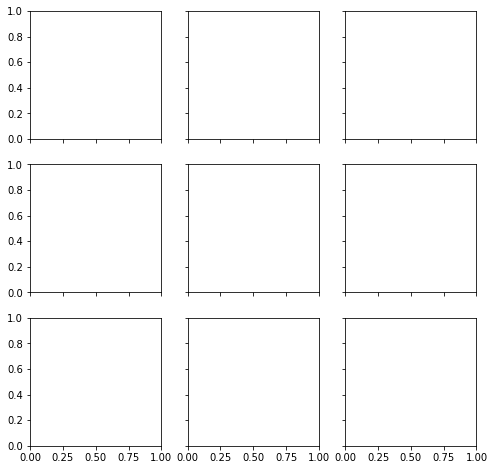

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [ ]:
# определим загрузчики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 32
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

In [ ]:
# Посмотрим, что выдаёт одна итерация DataLoader
for inputs, labels in dataloaders['train']:
    break

In [ ]:
inputs.shape

In [ ]:
# посмотрим на 4 картинку из обучающей выборки на ней должны быть ауагментации
plt.imshow(inputs[3].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<matplotlib.image.AxesImage at 0x7f26e529c080>

Нас предупреждают, что тензоры содержат значения выходящие за допустимый диапазон значений [0,1] для изображений. Тензоры действительно содержат значения, выходящие за этот диапазон, это происходит после трансформации

```
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]
```
Поскольку нам необходимо нормализовать картинки для предобученных на наборе данных ImageNet, нейросетей, просто игнорируем это предупреждение от библиотеки визуализации matplotlib.

In [ ]:
# посмотрим на классы из нашего batch картинок из обучающей выборки
# labels

# вывод:
# tensor([20,  0, 16, 17, 18, 17, 17,  4,  0, 25, 28, 22,  4,  0, 32,  7, 25, 25,
#         32,  2, 25, 22,  4, 15,  4,  2, 27, 17, 32,  6,  6,  4,  4,  2, 17, 20,
#         32, 25, 21, 27, 17,  4, 15,  4, 20,  9, 32,  0,  6, 22, 25,  4, 27, 32,
#         25,  7, 18,  6,  2, 37, 32, 28, 31,  4, 15, 17, 32, 29,  6,  0,  4,  7,
#         32, 37,  6,  4, 15, 27, 27,  2, 20, 11, 28, 32, 28, 17, 22, 20,  4, 20,
#         15, 27, 27, 37, 27, 11,  2, 28, 22, 15, 27, 20, 16, 37,  4,  0, 17, 28,
#         15, 32,  8,  4,  4, 20, 18, 17, 11,  2, 37,  7,  0, 25, 15, 18, 15, 27,
#         20,  9])

In [ ]:
# декодируем названия классов из классов, кодируемых цифрами
# for label in labels:
#     print(val_dataset.label_encoder.inverse_transform([label]))

#### оценка предсказательной точности модели по классам 1 цикл

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


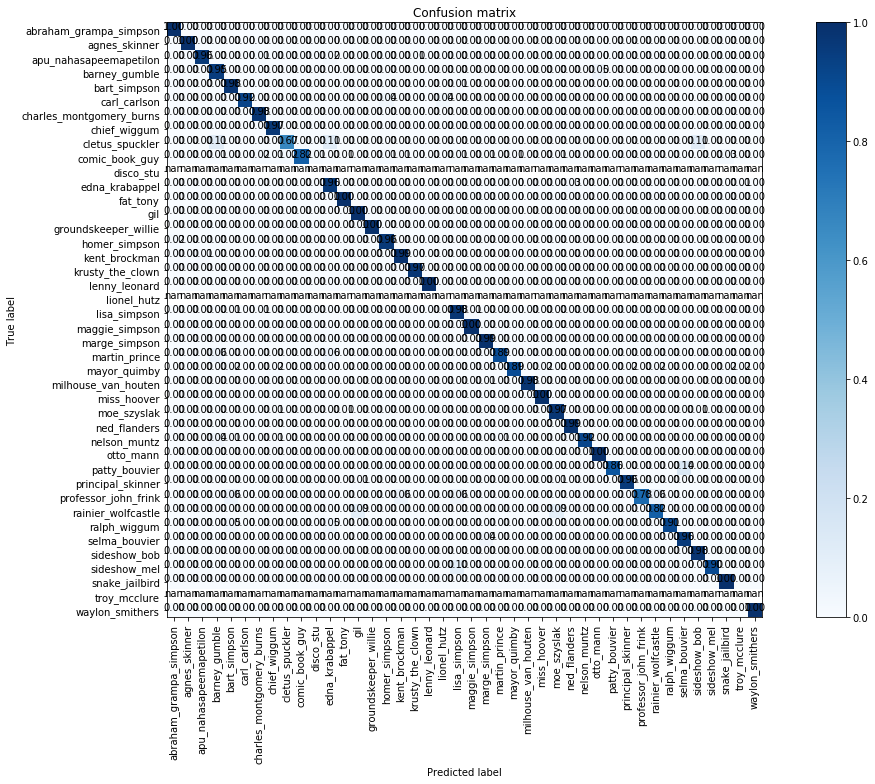

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[218, 9, 158, 20, 334, 26, 291, 245, 9, 142, 0, 110, 2, 2, 29, 579, 122, 306, 75, 0, 338, 28, 317, 18, 65, 274, 2, 366, 363, 96, 7, 21, 307, 18, 11, 22, 24, 219, 10, 8, 0, 43]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	96 %
Accuracy of barney_gumble	95 %
Accuracy of bart_simpson	97 %
Accuracy of carl_carlson	92 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	97 %
Accuracy of cletus_spuckler	66 %
Accuracy of comic_book_guy	82 %
Accuracy of disco_stu	-1 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	97 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	-1 %
Accuracy of lisa_simpson	97 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	88 %
Accuracy of mayor_quimby	89 %
Accuracy of milhous

Как видим есть малочисленные классы которые вообще не распознаются нашей нейронной сетью: lionel_hutz 3 картинки, troy_mcclure 8 картинок, disco_stu 8 картинок.

### Train (Стандартное обучение нейросети градиентым спуском с фиксированным learning rate на все размороженные слои нейросети балансировка классов: Ручной oversampling до 100 картинок)

[таблица сравнения Симпсонов](https://yadi.sk/i/oi2sDHwO4xZ-OA)

Как видно из таблицы балансоровка способом WeightedRandomSampler часто дает меньшую точность по классам.

Известен подход **OverSampling**: 
![alt text](https://user-images.githubusercontent.com/2270240/40656410-e0baa230-6376-11e8-8904-c092fb38fcdc.png)


Он заключается в том, чтобы докопировать количество картинок из меньших классов,так, чтобы общее число картинок было таким же как и у классов с большим числом картинок.

Можно однако сделать по другому, глядя на полученные нами таблицы точности мы видим, что без балансировки все классы, где было **не менее 100 кантинок**, отлично распознаются.

Т.е. мы просто откопируем картинки **малочисленных классов менее 100 картинок** из выборки **train**, так чтобы число на каждый малочисленный класс было не менее 100. 

Если мы сделаем oversampling, - возьмем картинки из всей выборки до разбиения ее на **'train'** и **'val'** то скорее всего в **train** попадут и картинки из выборки **val**, а мы этого не хотим. **Поэтому делаем вначале разбиение на подвыборки train и val и уже после этого делаем oversampling до 100 картинок, но только для картинок из выборки train, картинки из выборки val остаются такими же как были!**

При этом у нас все так же будет работать аугментация, да **картинки в малочисленных классах будут одинаковыми**, но при каждой загрузке одни и те же картинки **будут по разному аугментироваться**, и будут отличаться друг от друга.
Конечно такого  разнообразия как у изначально многочисленных классов не будет, но это лучше чем ничего.

Напишем такую функцию вручную. Нам не надо копировать картинки, нам надо копировать пути к картинкам !


In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Посмотрим, что у нас получилось.
print_dct(dct_path_train)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

In [ ]:
new_train_label = [path.parent.name for path in new_train_files] # классы train

In [ ]:
# выведем на печать класс:количество картинок для train,
# классы менее 100 должны иметь по 100 картинок !
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


Отлично, мы видим, что теперь все классы имеют минимум 100 картинок. У нас получилось.

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
# {'train': 16895, 'val': 5234} видим что число картинок в 'train' увеличилось
# исходный вариант {'train': 15699, 'val': 5234}
dataset_sizes

{'train': 16895, 'val': 5234}

#### 1-вый цикл обучения (30 эпох) Accuracy: 0.9706

batch size = 128

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdamW
optimizer = torch.optim.AdamW(params_to_update, lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_vgg16_bn = model_vgg16_bn.cuda()

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/VGG16_bn_F24_newC3_Adam_PYTorch_aug_BR_WI_scheduler_oversampling'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
# model_vgg16_bn, losses, acc, best_model_wts = train_model(model_vgg16_bn, dataloaders, loss_fn, optimizer, num_epochs=30)

# сохраним состояние нашей модели (веса), а так же losses и accurancy
# save_model(path, model_vgg16_bn, losses, acc, best_model_wts)

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая 
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_bn, dataloaders['val']))) # Accuracy: 0.9706

Accuracy: 0.9706


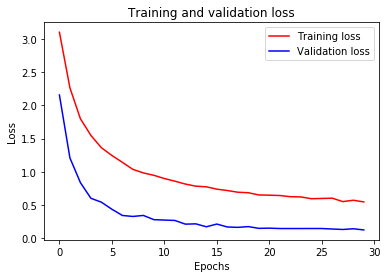

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

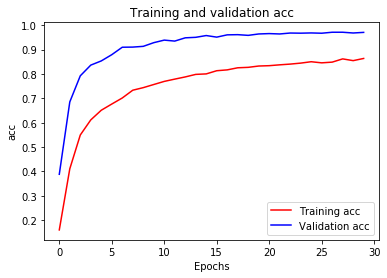

In [ ]:
show_acc_plots(acc, smooth_flag = False)

видим, что нейросеть недообучилась ! 

Значения loss функции для валиационной выборки все еще монотонно ниже, нежели для обучающей. Значения функции потерь на последней эпохе так же вызывают оптимизм для продолжения дальнейшего обучения, с тем же уровнем lr.






#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


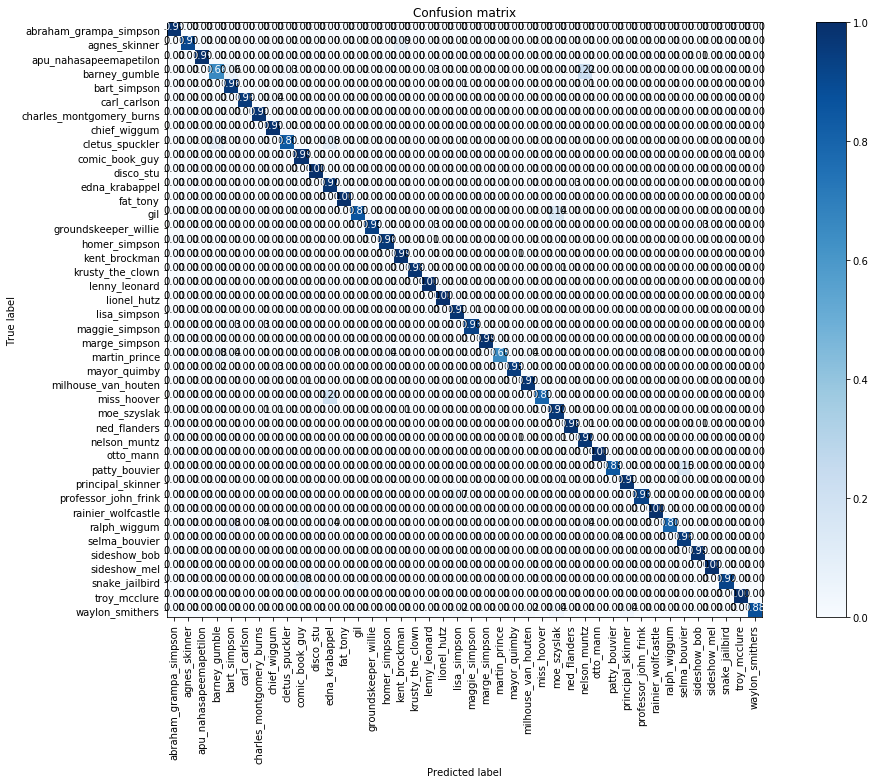

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[224, 11, 154, 32, 342, 25, 291, 241, 12, 115, 2, 110, 7, 7, 32, 580, 121, 304, 70, 1, 339, 30, 324, 26, 60, 275, 5, 362, 366, 77, 7, 20, 298, 15, 9, 25, 23, 216, 10, 13, 2, 51]
42
Accuracy of abraham_grampa_simpson	98 %
Accuracy of agnes_skinner	90 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	65 %
Accuracy of bart_simpson	95 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	83 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	85 %
Accuracy of groundskeeper_willie	93 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	97 %
Accuracy of maggie_simpson	93 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	65 %
Accuracy of mayor_quimby	95 %
Accuracy of milhouse

## Эксперименты с различными видами обучения нейросетей! 

Одним из главных параметров безусловно является подбор оптимального learning rate (lr).

Существует ли способ выбрать его оптимальным образом ? Оказывается да!

Я узнал о нем из замечательной книги книги "Ian Pointer - Programming PyTorch for Deep Learning - Creating and Deploying Deep Learning Applications-O’Reilly Media (2019).

ссылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)

Подход описан в Chapter 4. "Transfer Learning and Other Tricks" про "Transfer Learning with ResNet50",  "Finding That Learning Rate".

Как отмечает автор данной книги впервые данный подход был предложен Leslie Smith в статье    “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith (2015).

Суть подхода заключается в том, чтобы обучать нейросеть на каждом батче с различным уровнем lr, начиная с самого малого в выбранном нами диапазоне и заканчивая самым большим.  При этом мы будем записывать в массив значение lr и полученного на этом значении loss функции.

### Подберем оптимальный learning rate

In [ ]:
# Создаём сеть
model_vgg16_bn = models.vgg16_bn(pretrained=True)

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_vgg16_bn.classifier = nn.Sequential(nn.Linear(25088, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
for param in model_vgg16_bn.parameters():
    param.requires_grad = False

for param in model_vgg16_bn.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_vgg16 = print_learn_params(model_vgg16_bn)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.5.weight
	 classifier.5.bias
	 classifier.8.weight
	 classifier.8.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.AdamW(model_vgg16_bn.classifier.parameters(), lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_vgg16_bn = model_vgg16_bn.cuda()

Как следует из книги предложил данный подход  Leslie Smith а популярным данный подход сделал Jeremy Howard автор курса fast.ai и одноименной библиотеки.

В  fast.ai есть готовая функция пример ее использования пример.

Автор книги предложил свою собственную реализацию средствами PyTorch. Функция из fast.ai лучше, но это сделана на PyTorch и хорошо показывает идею.

Я модифицировал эту функцию, изначально она не поддерживала GPU, теперь поддерживает.

In [ ]:
# подбор оптимального lr для классификатора model_vgg16_bn.classifier
logs, losses = find_lr(model_vgg16_bn, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

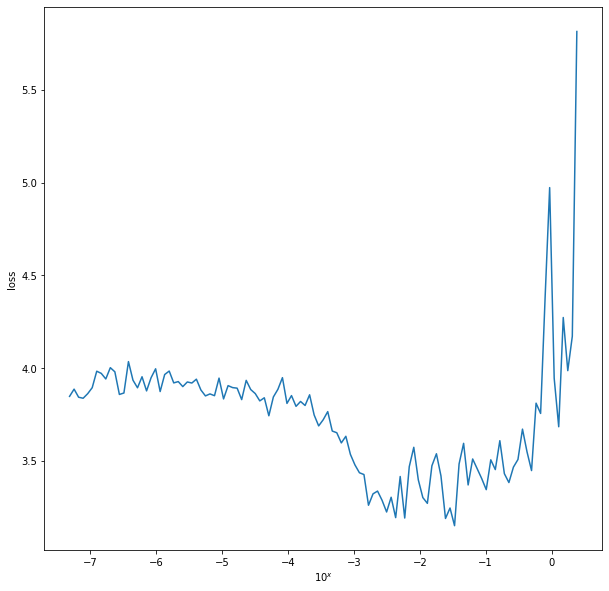

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr =1e-3

### Дифференцированое обучение слоев нейросети.
Следующий интересный подход к обучение это **дифференцированое обучение слоев нейросети (Differential Learning Rates)**.

Когда мы выполняем **fine tuning** предобученной нейросети, мы обычно замораживаем нижние слои и оставляем на обучение верхние. Есть другой интересный подход **дифференцированое обучение**. Подход заключается в следующем, у нас обучается вся нейронная сеть, но более верхние слои обучаются с высоким значением lr, а более нижние с маленьким lr. Таким образом, веса слоев обобщающих признаки перестраивается быстро, а нижняя часть выделяющая признаки, - медленно. На него так же часто ссылаются в курсе fast.ai. Исходник данного подхода мне неизвестен, если знаете автора пишите напишите мне.

Здесь представлен тест и статья с примерами реализации от Slav https://blog.slavv.com/differential-learning-rates-59eff5209a4f

Рассмотрим как это реализовать, есть два подхода к дифференциальному обучению слоев(мне правильным кажется перевод раздельное обучение слоев):

1. **Первый подход (Differential Groups)** группы слоев, при котором мы разбиваем всю нашу нейросеть на группы слоев и обучаем их с разными скоростями.

2. **Второй подход (Gradual Differential LRs)** каждый слой получает свой собственный lr в некотором диапазоне например lr=[10**-3, 10**-5] самый нижний слой получит самый маленький lr, на каждом последующем слое lr будет увеличиваться вплоть до самого последнего слоя на котором будет верхняя граница заданного нами диапазона lr. Закон увеличения значений lr при этом может быть разным линейным, логорифмическим и т.д.

### Обучение VGG16_bn подходом Differential Groups Layers (***vgg16_bn_DGL***)

Мы уже выбрали оптимальный found_lr для ее классификатора. После подбора оптимального lr мы уже немного обучили нашу нейросеть поэтому необходимо вернуть ее к исходным весам.

теперь разобьем веса слоев vgg16_bn на группы:

In [ ]:
# сбросим нейрость к первоначальным весам
model_vgg16_bn = models.vgg16_bn(pretrained=True)

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_vgg16_bn.classifier = nn.Sequential(nn.Linear(25088, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
param512 = model_vgg16_bn.features[27:44].parameters()
param256 = model_vgg16_bn.features[17:27].parameters()
param128 = model_vgg16_bn.features[10:17].parameters()
param64 = model_vgg16_bn.features[0:10].parameters()

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_vgg16 = print_learn_params(model_vgg16_bn)

Params to update:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40

#### 1-вый цикл обучения (30 эпох) Accuracy: 0.9820

In [ ]:
# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 32
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
# {'train': 16895, 'val': 5234} видим что число картинок в 'train' увеличилось
# исходный вариант {'train': 15699, 'val': 5234}
dataset_sizes

{'train': 16895, 'val': 5234}

В группе param512 все блоки с 512 фильтрами, и т.к.

Далее есть импирические правила подбора затухания например в 3 раза или в 10 раз, точной инструкции нет.

классификатор lr, четвертая группа lr/3, третья группа lr/9, вторая группа lr/27, первая lr/81.

в обзоре Slav по ссылке выше было указано lr=[10**-3, 10**-5]. Поэтому я скрестил подходы по 1/3 и по 1/10.

Получилось так:

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

found_lr = lr=1e-3

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

optimizer = torch.optim.AdamW([
{ 'params': model_vgg16_bn.classifier.parameters(), 'lr': found_lr},
{ 'params': param512, 'lr': found_lr / 3},
{ 'params': param256, 'lr': found_lr / 10},
{ 'params': param128, 'lr': found_lr / 50},
{ 'params': param64, 'lr': found_lr / 100},
], lr=found_lr / 100, amsgrad=True)

# Использовать ли GPU
model_vgg16_bn = model_vgg16_bn.cuda()

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Vgg16_bn_DGL_AdamW_PYTorch_aug_oversampling'

In [ ]:
# Обучаем модель (Используется как составная часть ансамбля в финальном score)
model_vgg16_bn, losses, acc, best_model_wts = train_model(model_vgg16_bn, dataloaders, loss_fn, optimizer, num_epochs=30)

# сохраним состояние нашей модели (веса), а так же losses и accurancy
save_model(path, model_vgg16_bn, losses, acc, best_model_wts)



Epoch 0/29 lr=0.001
----------
train Loss: 2.4838 Acc: 0.3755
val Loss: 0.9002 Acc: 0.7877

Epoch 1/29 lr=0.001
----------
train Loss: 1.5424 Acc: 0.6255
val Loss: 0.5516 Acc: 0.8575

Epoch 2/29 lr=0.001
----------
train Loss: 1.2503 Acc: 0.6839
val Loss: 0.3548 Acc: 0.9089

Epoch 3/29 lr=0.001
----------
train Loss: 1.0907 Acc: 0.7219
val Loss: 0.3058 Acc: 0.9215

Epoch 4/29 lr=0.001
----------
train Loss: 0.9704 Acc: 0.7477
val Loss: 0.3395 Acc: 0.9083

Epoch 5/29 lr=0.001
----------
train Loss: 0.8929 Acc: 0.7661
val Loss: 0.2193 Acc: 0.9427

Epoch 6/29 lr=0.001
----------
train Loss: 0.8291 Acc: 0.7870
val Loss: 0.1920 Acc: 0.9578

Epoch 7/29 lr=0.001
----------
train Loss: 0.7835 Acc: 0.8001
val Loss: 0.1965 Acc: 0.9496

Epoch 8/29 lr=0.001
----------
train Loss: 0.7425 Acc: 0.8128
val Loss: 0.1461 Acc: 0.9677

Epoch 9/29 lr=0.001
----------
train Loss: 0.6981 Acc: 0.8206
val Loss: 0.1512 Acc: 0.9645

Epoch 10/29 lr=0.001
----------
train Loss: 0.6753 Acc: 0.8270
val Loss: 0.1537 

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_bn, dataloaders['val']))) # Accuracy: 0.9820

Accuracy: 0.9820


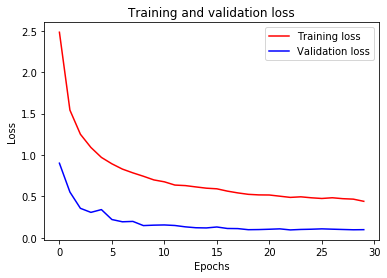

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

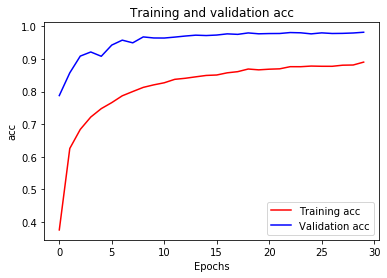

In [ ]:
show_acc_plots(acc, smooth_flag = False)

видим, что нейросеть недообучилась ! 

Значения loss функции для валиационной выборки все еще монотонно ниже, нежели для обучающей. Значения функции потерь на последней эпохе так же вызывают оптимизм для продолжения дальнейшего обучения, с тем же уровнем lr.







#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


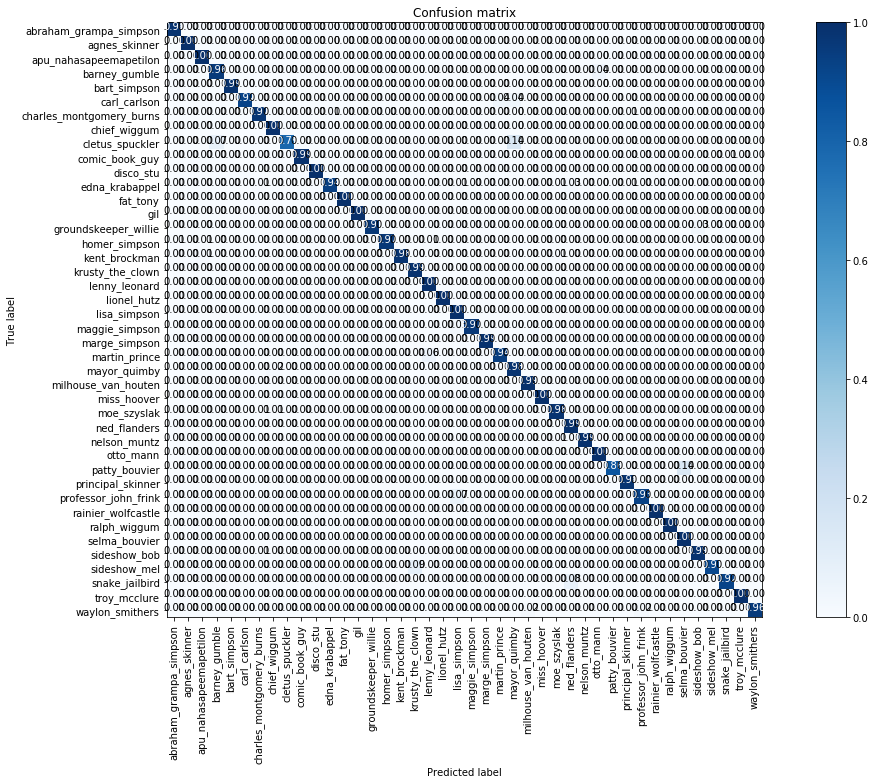

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[228, 9, 151, 25, 338, 26, 300, 241, 14, 117, 2, 118, 7, 7, 31, 578, 127, 301, 73, 1, 336, 31, 323, 18, 57, 270, 4, 364, 359, 89, 7, 21, 301, 15, 11, 21, 22, 219, 11, 13, 2, 46]
42
Accuracy of abraham_grampa_simpson	98 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	100 %
Accuracy of barney_gumble	96 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	92 %
Accuracy of charles_montgomery_burns	97 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	78 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	94 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	96 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	98 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	96 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	94 %
Accuracy of mayor_quimby	98 %
Accuracy of milho

# Теперь обучаем лучшими подходами:

*   c аугментацией картинок из train выборки (идет автоматически из simpsons dataset)
*   с самописной балансироввакой классов по методу oversampling до 100 картинок
*   по методу Diferential Groups Layers c подбором оптимальной скорости обучения lr


### Ручной oversampling до 100 картинок (Выполняется для всех нейросетей в подзаголовках заголовка Теперь обучаем лучшими подходами)



In [ ]:
BATCH_SIZE = 32

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

# {'train': 16895, 'val': 5234} видим что число картинок в 'train' увеличилось
# исходный вариант {'train': 15699, 'val': 5234}
dataset_sizes

{'train': 16895, 'val': 5234}

(3.0, 5.0)

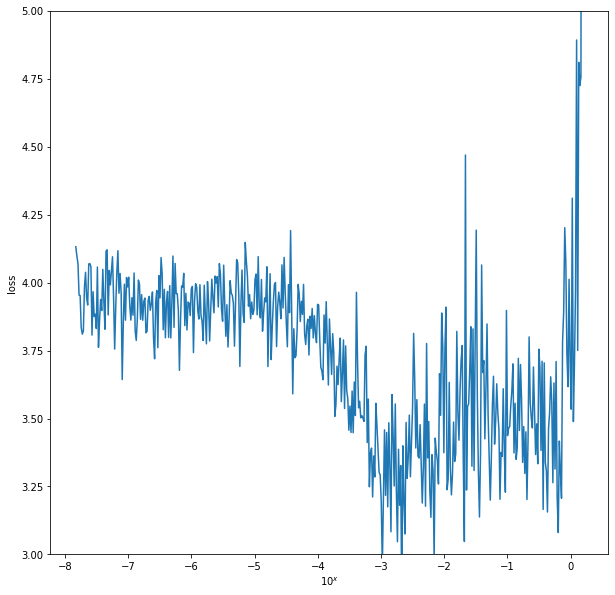

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")
ax.set_ylim(3,5)

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-3
found_lr

0.001

### Обучение VGG16_bn подходом Differential Groups Layers

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

Мы уже выбрали оптимальный found_lr для ее классификатора. После подбора оптимального lr мы уже немного обучили нашу нейросеть поэтому необходимо вернуть ее к исходным весам.

теперь разобьем веса слоев vgg16_bn на группы:

In [ ]:
# сбросим нейрость к первоначальным весам
model_vgg16_bn = models.vgg16_bn(pretrained=True)

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_vgg16_bn.classifier = nn.Sequential(nn.Linear(25088, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
param512 = model_vgg16_bn.features[27:44].parameters()
param256 = model_vgg16_bn.features[17:27].parameters()
param128 = model_vgg16_bn.features[10:17].parameters()
param64 = model_vgg16_bn.features[0:10].parameters()

Далее есть импирические правила подбора затухания например в 3 раза или в 10 раз, точной инструкции нет.

классификатор lr, четвертая группа lr/3, третья группа lr/9, вторая группа lr/27, первая lr/81.

в обзоре Slav по ссылке выше было указано lr=[10**-3, 10**-5]. Поэтому я скрестил подходы по 1/3 и по 1/10.

Получилось так:

In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_vgg16_bn.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_vgg16 = print_learn_params(model_vgg16_bn)

Params to update:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

optimizer = torch.optim.Adam([
{ 'params': model_vgg16_bn.classifier.parameters(), 'lr': found_lr},
{ 'params': param512, 'lr': found_lr / 3},
{ 'params': param256, 'lr': found_lr / 10},
{ 'params': param128, 'lr': found_lr / 50},
{ 'params': param64, 'lr': found_lr / 100},
], lr=found_lr / 100, amsgrad=True)

# Использовать ли GPU
model_vgg16_bn = model_vgg16_bn.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9754

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/Vgg16_bn_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Используется как составная часть ансамбля в финальном score)
model_vgg16_bn, losses, acc, best_model_wts = train_model(model_vgg16_bn, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)

Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 2.5433 Acc: 0.3476
val Loss: 1.1208 Acc: 0.7218

Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 1.6603 Acc: 0.5871
val Loss: 0.6383 Acc: 0.8366

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 1.3607 Acc: 0.6494
val Loss: 0.3731 Acc: 0.9047

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 1.1683 Acc: 0.7029
val Loss: 0.2933 Acc: 0.9253

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 1.0643 Acc: 0.7268
val Loss: 0.2801 Acc: 0.9268

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.9843 Acc: 0.7470
val Loss: 0.2263 Acc: 0.9406

Epoch 6/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.9035 Acc: 0.7680
val Loss: 0.1837 Acc: 0.9524

Epoch 7/19 lr=[0.001, 0.000

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9754
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_bn, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9754


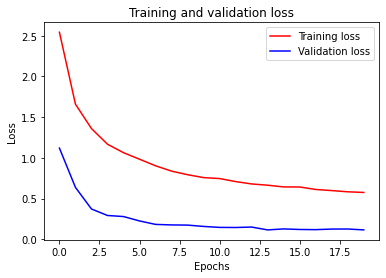

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

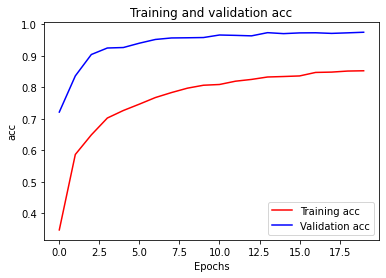

In [ ]:
show_acc_plots(acc, smooth_flag = False)

видим, что нейросеть недообучилась ! 

Значения loss функции для валиационной выборки все еще монотонно ниже, нежели для обучающей. Значения функции потерь на последней эпохе так же вызывают оптимизм для продолжения дальнейшего обучения, с тем же уровнем lr.







#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


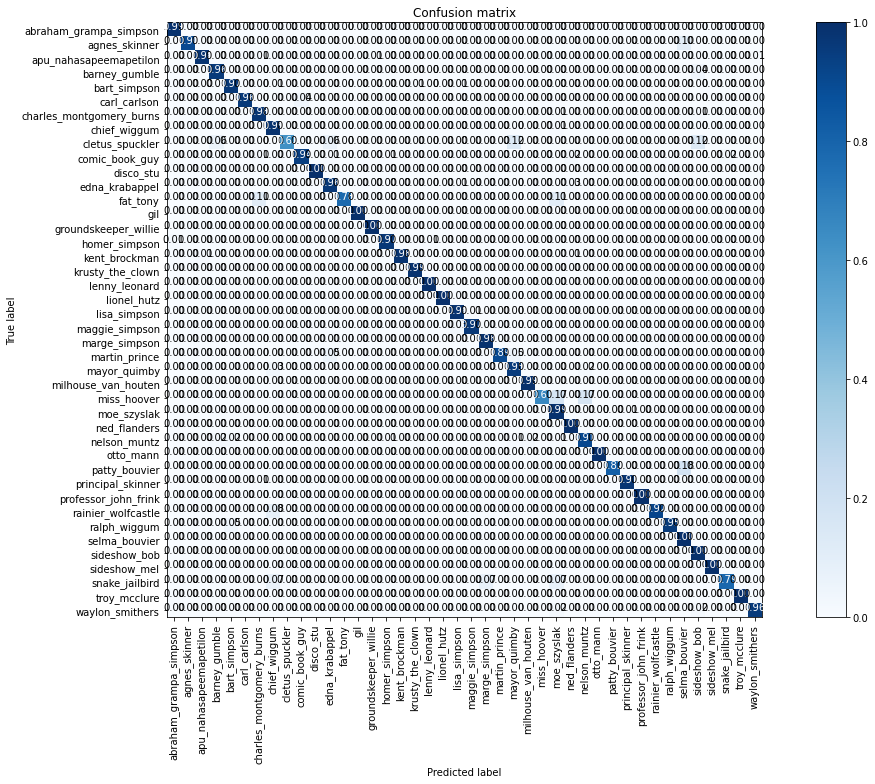

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[223, 10, 155, 24, 344, 25, 296, 242, 16, 122, 2, 114, 9, 7, 28, 579, 125, 298, 72, 1, 339, 31, 325, 19, 60, 270, 6, 355, 357, 95, 8, 22, 303, 14, 12, 22, 21, 212, 10, 14, 2, 45]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	90 %
Accuracy of apu_nahasapeemapetilon	98 %
Accuracy of barney_gumble	95 %
Accuracy of bart_simpson	96 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	97 %
Accuracy of chief_wiggum	98 %
Accuracy of cletus_spuckler	62 %
Accuracy of comic_book_guy	94 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	77 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	98 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	96 %
Accuracy of marge_simpson	98 %
Accuracy of martin_prince	89 %
Accuracy of mayor_quimby	95 %
Accuracy of milhou

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-вый цикл обучения (20 эпох) Accuracy: 0.9817

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/Vgg16_bn_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Используется как составная часть ансамбля в финальном score)
model_vgg16_bn, losses, acc, best_model_wts = train_model(model_vgg16_bn, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)

Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5652 Acc: 0.8594
val Loss: 0.1042 Acc: 0.9790

Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5637 Acc: 0.8611
val Loss: 0.1129 Acc: 0.9738

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5397 Acc: 0.8636
val Loss: 0.1027 Acc: 0.9790

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5475 Acc: 0.8622
val Loss: 0.1091 Acc: 0.9780

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5460 Acc: 0.8595
val Loss: 0.1087 Acc: 0.9767

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.5259 Acc: 0.8671
val Loss: 0.0989 Acc: 0.9790

Epoch 6/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4962 Acc: 0.8737
val Loss: 0.0979 Acc: 0.9788

Epoch 7/19 lr=[0.001, 0.000

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9817
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_bn, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9817


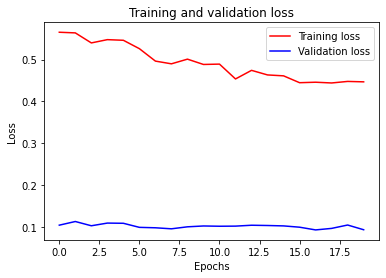

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

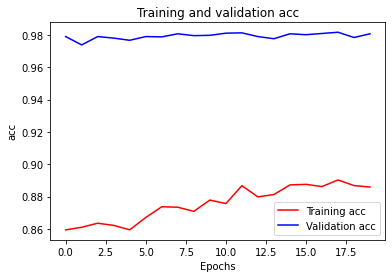

In [ ]:
show_acc_plots(acc, smooth_flag = False)

видим, что нейросеть недообучилась ! 

Значения loss функции для валиационной выборки все еще монотонно ниже, нежели для обучающей. Значения функции потерь на последней эпохе так же вызывают оптимизм для продолжения дальнейшего обучения, с тем же уровнем lr.







#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


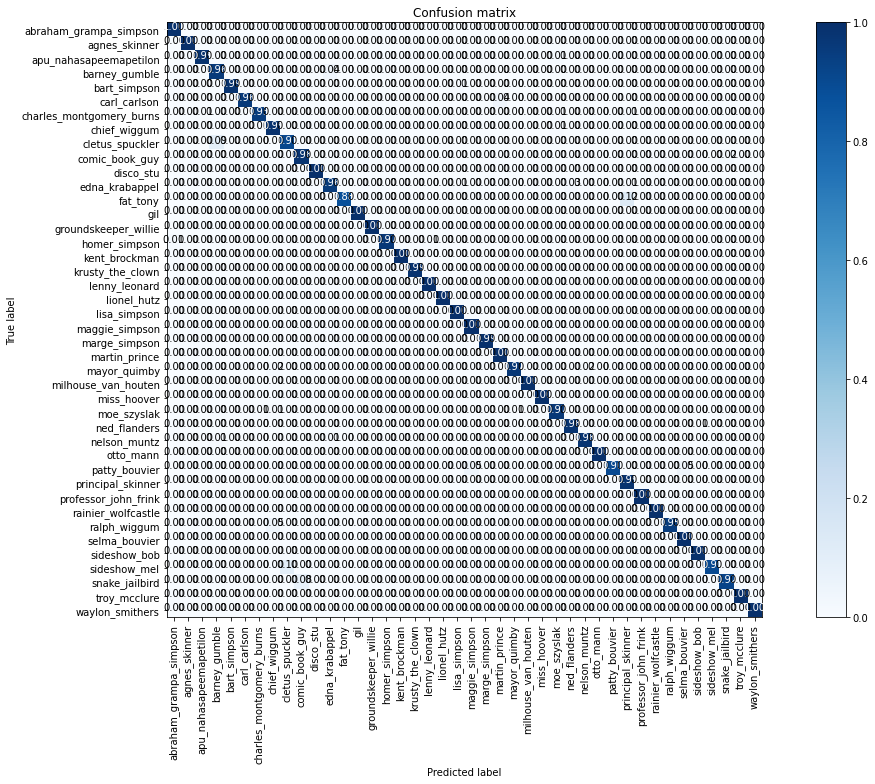

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[222, 9, 154, 25, 341, 25, 309, 242, 11, 116, 2, 116, 8, 6, 30, 579, 122, 303, 73, 1, 335, 31, 321, 17, 61, 268, 4, 367, 367, 89, 8, 20, 296, 14, 11, 21, 25, 217, 10, 13, 2, 43]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	98 %
Accuracy of barney_gumble	96 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	95 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	90 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	95 %
Accuracy of fat_tony	87 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	100 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	96 %
Accuracy of mil

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 3-тий цикл обучения (20 эпох) Accuracy: 0.9851

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud_2/Vgg16_bn_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/Vgg16_bn_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3'

In [ ]:
# Обучаем модель (Используется как составная часть ансамбля в финальном score)
model_vgg16_bn, losses, acc, best_model_wts = train_model(model_vgg16_bn, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)

/content/gdrive/My Drive/simpsons_on_cloud/Vgg16_bn_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3_log_file.txt


Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4751 Acc: 0.8794
val Loss: 0.1028 Acc: 0.9801

***new best wts with acc 0.9801299197554452 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4950 Acc: 0.8740
val Loss: 0.1114 Acc: 0.9786
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4936 Acc: 0.8755
val Loss: 0.1180 Acc: 0.9763
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4957 Acc: 0.8742
val Loss: 0.0922 Acc: 0.9820

***new best wts with acc 0.9820405043943446 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4771 Acc: 0.8801
val Loss: 0.1004 Acc: 0.9815
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05]
----------
train Loss: 0.4799 Acc: 0.8798
val Loss: 0.1234 Acc: 0.9769
*** save model wts at this 5 epoch ! *** 

Epoch 6/19 lr=[0.001, 0.0003333333333

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_vgg16_bn.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9851
print("Accuracy: {0:.4f}".format(evaluate(model_vgg16_bn, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9851


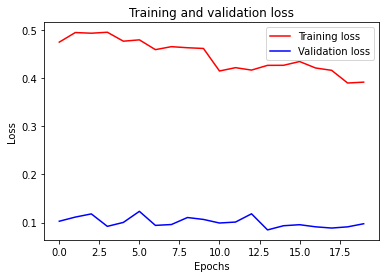

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

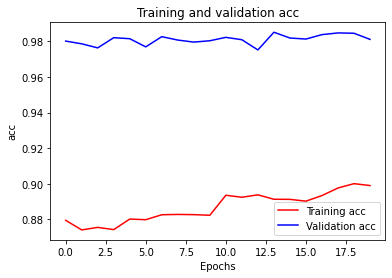

In [ ]:
show_acc_plots(acc, smooth_flag = False)

видим, что нейросеть недообучилась ! 

Значения loss функции для валиационной выборки все еще монотонно ниже, нежели для обучающей. Значения функции потерь на последней эпохе так же вызывают оптимизм для продолжения дальнейшего обучения, с тем же уровнем lr.







#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


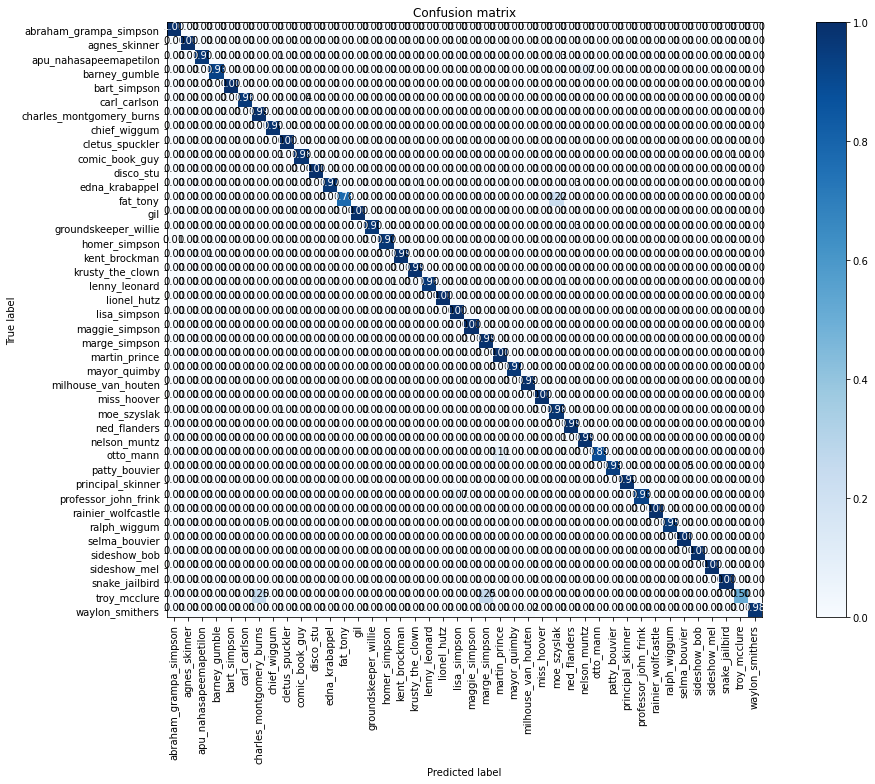

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_vgg16_bn, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[224, 10, 157, 27, 337, 25, 295, 243, 11, 118, 2, 116, 9, 7, 31, 575, 125, 300, 80, 1, 337, 32, 320, 17, 60, 271, 4, 361, 364, 86, 9, 19, 301, 15, 11, 22, 25, 217, 10, 12, 4, 44]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	96 %
Accuracy of barney_gumble	92 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	98 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	77 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	96 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	96 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	96 %
Accuracy of mil

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

## ResNet-152

делаем рестарт всего ноутбука для освобождения памяти GPU. Запускаем все ячейки выше "Стандартное обучение VGG16 (Это проба пера и ее можно не смотреть!)" Там полезные функции и преварительная подготовка данных.

Далее запускаем все ячейки раздела Ручной oversampling до 100 картинок.
А после этого переходим к тому что входит в этот заголовок.

![alt text](https://neurohive.io/wp-content/uploads/2019/01/resnet-architecture-3.png)

### по методу Diferential Groups Layers c подбором оптимальной скорости обучения lr

### Подберем оптимальный learning rate для ResNet-152 (подбор learning rate осуществляем на классификаторе)

In [ ]:
# Создаём сеть
model_resnet152 = models.resnet152(pretrained=True)

In [ ]:
# посмотрим на сеть от которой мы делаем transfer learning
model_resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnet152.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
for param in model_resnet152.parameters():
    param.requires_grad = False

for param in model_resnet152.fc.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_resnet152)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnet152)

Params to update:
	 fc.0.weight
	 fc.0.bias
	 fc.1.weight
	 fc.1.bias
	 fc.4.weight
	 fc.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_resnet152 = model_resnet152.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_resnet152, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

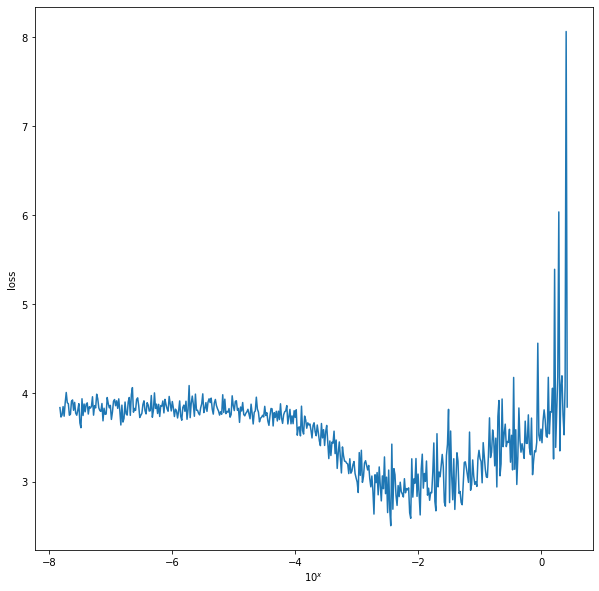

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-3
found_lr

0.001

### Обучение ResNet-152 подходом Differential Groups Layers

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

In [ ]:
# Вернем первоначальные веса resnet50
model_resnet152 = models.resnet152(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnet152.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_resnet152.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnet152)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

# Выставляем различные скорости обучения для различных слоев
optimizer = torch.optim.Adam([
{ 'params': model_resnet152.fc.parameters(), 'lr': found_lr},
{ 'params': model_resnet152.layer4.parameters(), 'lr': found_lr / 3},
{ 'params': model_resnet152.layer3.parameters(), 'lr': found_lr / 10},
{ 'params': model_resnet152.layer2.parameters(), 'lr': found_lr / 50},
{ 'params': model_resnet152.layer1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet152.bn1.parameters(), 'lr': found_lr / 100},
{'params': model_resnet152.conv1.parameters(), 'lr': found_lr / 100}],
lr=found_lr / 100, amsgrad=True)


# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_resnet152 = model_resnet152.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9859

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/ReNet152_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnet152, losses, acc, best_model_wts = train_model(model_resnet152, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.7305 Acc: 0.5809
val Loss: 0.4197 Acc: 0.8955

***new best wts with acc 0.8954910202521972 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.0159 Acc: 0.7403
val Loss: 0.2561 Acc: 0.9303

***new best wts with acc 0.9302636606801681 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.8320 Acc: 0.7873
val Loss: 0.1771 Acc: 0.9522

***new best wts with acc 0.9522353840275124 at 2 epoh***
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.7095 Acc: 0.8149
val Loss: 0.1585 Acc: 0.9585

***new best wts with acc 0.9585403133358807 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.6470 Acc: 0.8311
val Loss: 0.1258 Acc: 0.9698

***new best wts with acc 0.9698127627053879 at 4 epoh***
*** save model wts at this 4 ep

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnet152.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9859
print("Accuracy: {0:.4f}".format(evaluate(model_resnet152, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9859


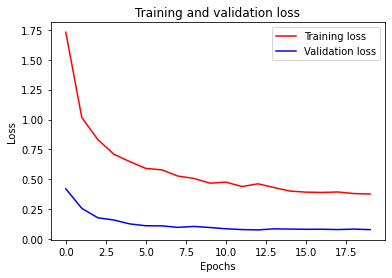

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

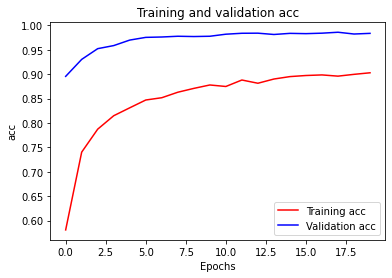

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


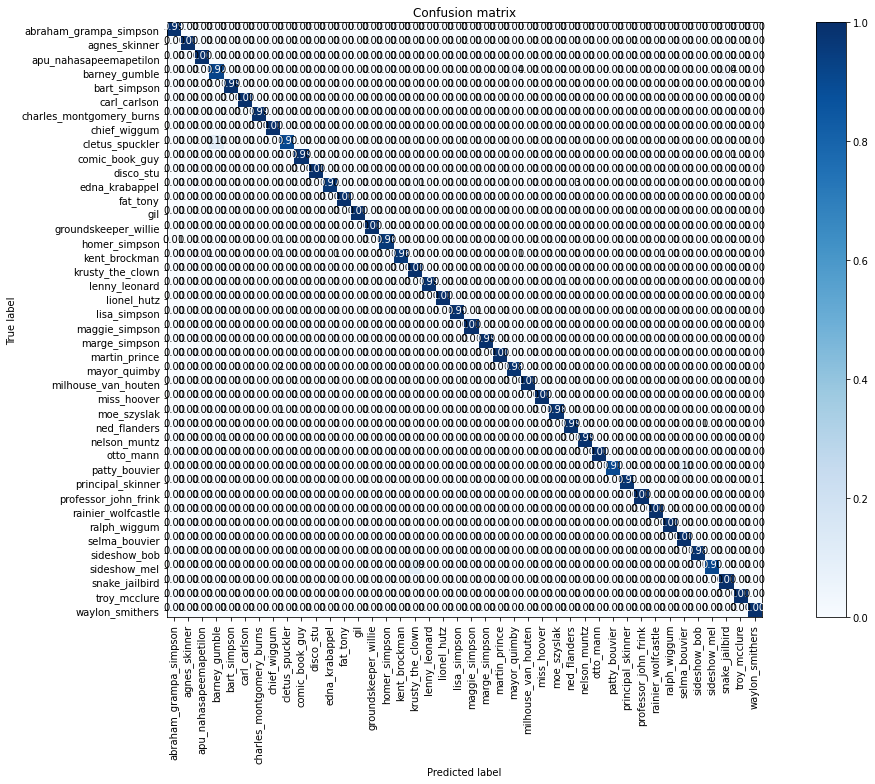

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet152, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[227, 10, 153, 25, 337, 24, 298, 239, 10, 117, 2, 117, 7, 7, 29, 582, 129, 298, 76, 1, 341, 29, 324, 17, 60, 269, 4, 363, 365, 88, 8, 20, 303, 14, 10, 21, 23, 219, 11, 12, 2, 43]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	100 %
Accuracy of barney_gumble	92 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	100 %
Accuracy of cletus_spuckler	90 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	96 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	98 %
Accuracy of 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-рой цикл обучения (20 эпох) Accuracy: 0.9887

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnet152.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud/ReNet152_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/ReNet152_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnet152, losses, acc, best_model_wts = train_model(model_resnet152, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3810 Acc: 0.9006
val Loss: 0.0747 Acc: 0.9853

***new best wts with acc 0.9852884982804738 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3649 Acc: 0.9034
val Loss: 0.0765 Acc: 0.9838
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3585 Acc: 0.9071
val Loss: 0.0715 Acc: 0.9855

***new best wts with acc 0.9854795567443637 at 2 epoh***
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3619 Acc: 0.9049
val Loss: 0.0752 Acc: 0.9864

***new best wts with acc 0.9864348490638135 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3426 Acc: 0.9067
val Loss: 0.0713 Acc: 0.9862
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnet152.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9887
print("Accuracy: {0:.4f}".format(evaluate(model_resnet152, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9887


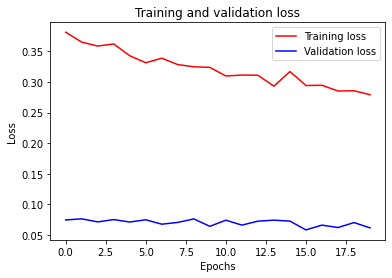

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

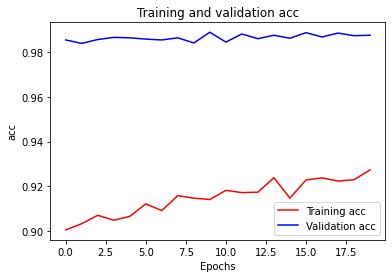

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


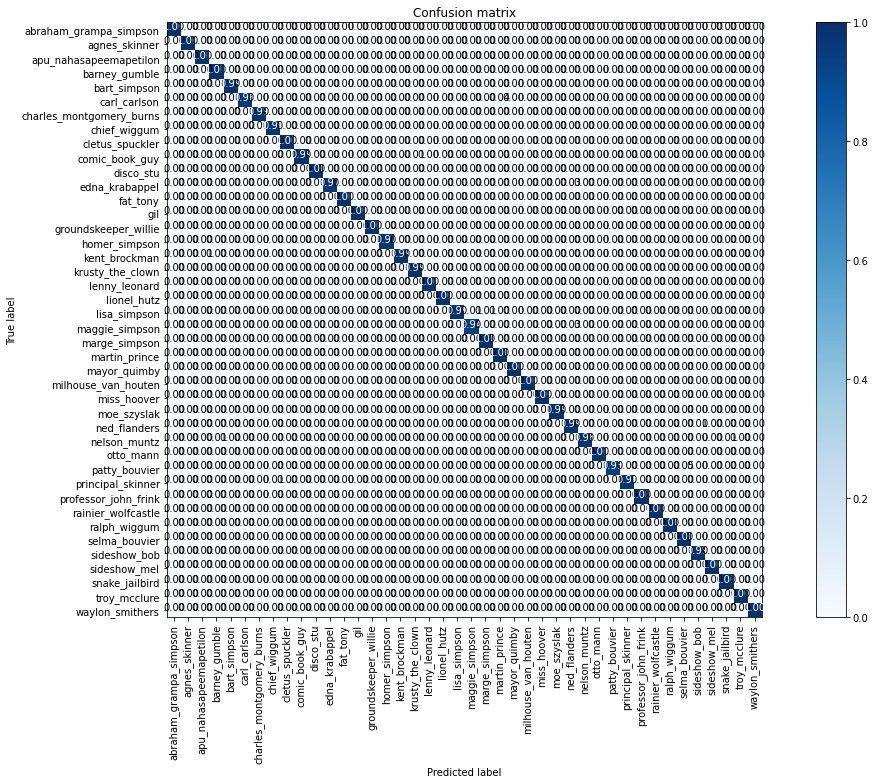

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnet152, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[227, 10, 153, 23, 337, 25, 299, 247, 8, 118, 2, 116, 7, 6, 30, 576, 125, 300, 73, 1, 341, 32, 319, 17, 61, 269, 4, 364, 363, 91, 8, 19, 305, 14, 11, 21, 25, 218, 10, 12, 2, 45]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	100 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	98 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	93 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	100 %
Accuracy of

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

## Wide ResNet-101-2

Новая современная архитектура, вариация от от resnet. Обладает похожей структурой слоев но имеет большую точность. Обучеим его так же как и resnet152 ранее

https://arxiv.org/pdf/1605.07146.pdf


https://habr.com/ru/company/mailru/blog/359214/

### по методу Diferential Groups Layers c подбором оптимальной скорости обучения lr

### Подберем оптимальный learning rate для ResNet-152 (подбор learning rate осуществляем на классификаторе)

In [ ]:
# Создаём сеть
model_wide_resnet101_2 = models.wide_resnet101_2(pretrained=True)

# посмотрим на сеть от которой мы делаем transfer learning
model_wide_resnet101_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_wide_resnet101_2.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
for param in model_wide_resnet101_2.parameters():
    param.requires_grad = False

for param in model_wide_resnet101_2.fc.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_wide_resnet101_2)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_wide_resnet101_2)

Params to update:
	 fc.0.weight
	 fc.0.bias
	 fc.1.weight
	 fc.1.bias
	 fc.4.weight
	 fc.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_wide_resnet101_2 = model_wide_resnet101_2.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_wide_resnet101_2, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

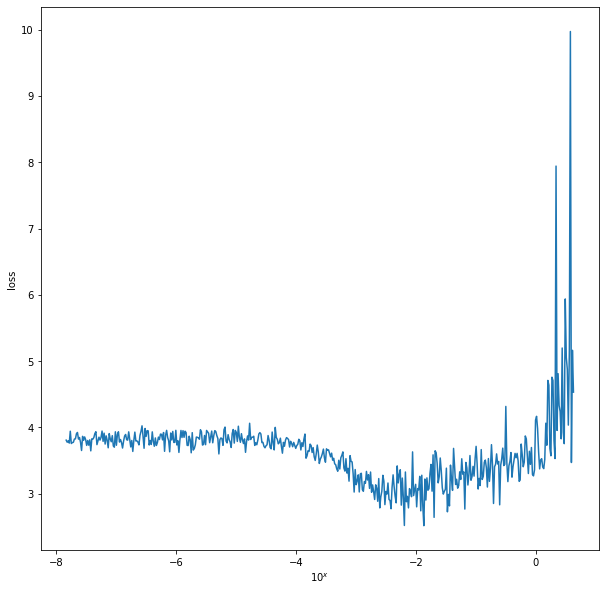

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-3
found_lr

0.001

### Обучение Wide ResNet-101-2 подходом Differential Groups Layers

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

In [ ]:
# Вернем первоначальные веса resnet50
model_wide_resnet101_2 = models.wide_resnet101_2(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_wide_resnet101_2.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth


In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_wide_resnet101_2.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_wide_resnet101_2)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

# Выставляем различные скорости обучения для различных слоев
optimizer = torch.optim.Adam([
{ 'params': model_wide_resnet101_2.fc.parameters(), 'lr': found_lr},
{ 'params': model_wide_resnet101_2.layer4.parameters(), 'lr': found_lr / 3},
{ 'params': model_wide_resnet101_2.layer3.parameters(), 'lr': found_lr / 10},
{ 'params': model_wide_resnet101_2.layer2.parameters(), 'lr': found_lr / 50},
{ 'params': model_wide_resnet101_2.layer1.parameters(), 'lr': found_lr / 100},
{'params': model_wide_resnet101_2.bn1.parameters(), 'lr': found_lr / 100},
{'params': model_wide_resnet101_2.conv1.parameters(), 'lr': found_lr / 100}],
lr=found_lr / 100, amsgrad=True)


# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_wide_resnet101_2 = model_wide_resnet101_2.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9847

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_wide_resnet101_2, losses, acc, best_model_wts = train_model(model_wide_resnet101_2, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.6841 Acc: 0.5916
val Loss: 0.4893 Acc: 0.8760

***new best wts with acc 0.8760030569354222 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.0367 Acc: 0.7390
val Loss: 0.2337 Acc: 0.9394

***new best wts with acc 0.9394344669468857 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.8203 Acc: 0.7904
val Loss: 0.1959 Acc: 0.9498

***new best wts with acc 0.949751623996943 at 2 epoh***
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.7358 Acc: 0.8144
val Loss: 0.1446 Acc: 0.9658

***new best wts with acc 0.9658005349636989 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.6783 Acc: 0.8255
val Loss: 0.1207 Acc: 0.9729

***new best wts with acc 0.972869698127627 at 4 epoh***
*** save model wts at this 4 epoc

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_wide_resnet101_2.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9847
print("Accuracy: {0:.4f}".format(evaluate(model_wide_resnet101_2, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9847


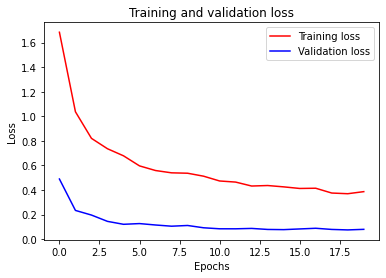

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

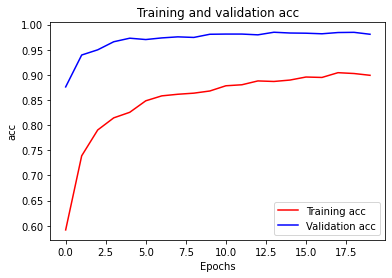

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


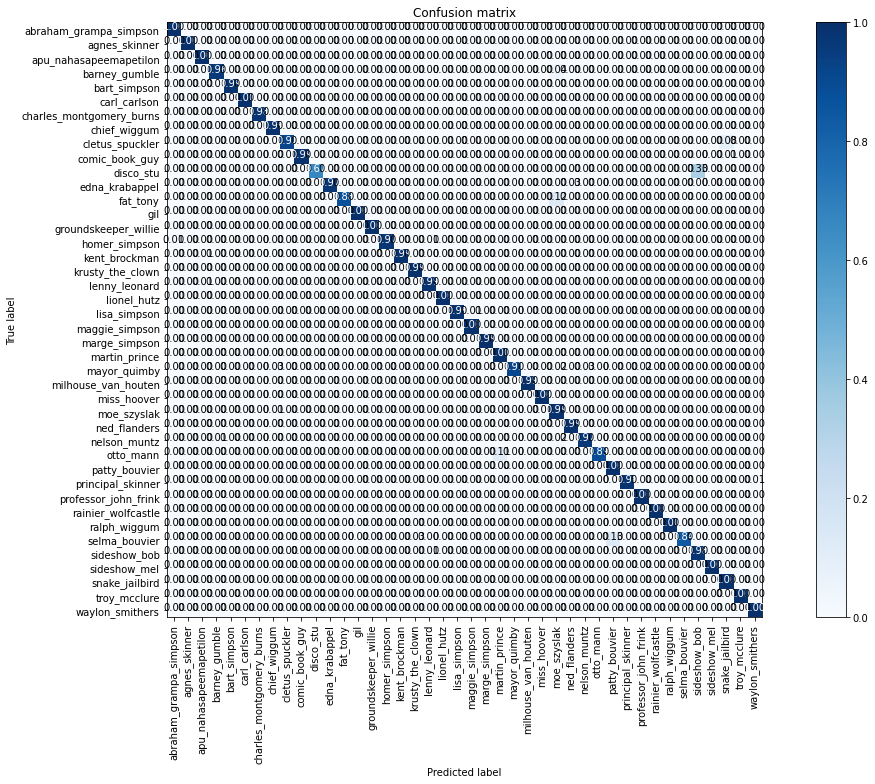

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_wide_resnet101_2, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[224, 10, 152, 24, 338, 24, 300, 244, 12, 116, 3, 115, 8, 7, 30, 576, 126, 298, 71, 1, 341, 30, 323, 17, 66, 272, 4, 359, 364, 88, 9, 14, 305, 14, 11, 22, 31, 219, 10, 12, 2, 42]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	100 %
Accuracy of barney_gumble	95 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	91 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	66 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	87 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	90 %
Accuracy of mi

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-рой цикл обучения (20 эпох) Accuracy: 0.9887

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_wide_resnet101_2.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_wide_resnet101_2, losses, acc, best_model_wts = train_model(model_wide_resnet101_2, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)         

Logging...


Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3744 Acc: 0.9017
val Loss: 0.0693 Acc: 0.9864

***new best wts with acc 0.9864348490638135 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3669 Acc: 0.9068
val Loss: 0.0698 Acc: 0.9874

***new best wts with acc 0.9873901413832633 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3561 Acc: 0.9084
val Loss: 0.0832 Acc: 0.9847
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3605 Acc: 0.9077
val Loss: 0.0666 Acc: 0.9866
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3404 Acc: 0.9105
val Loss: 0.0651 Acc: 0.9880

***new best wts with acc 0.9879633167749331 at 4 epoh***
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_wide_resnet101_2.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9887
print("Accuracy: {0:.4f}".format(evaluate(model_wide_resnet101_2, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9887


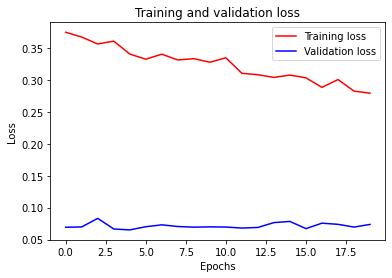

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

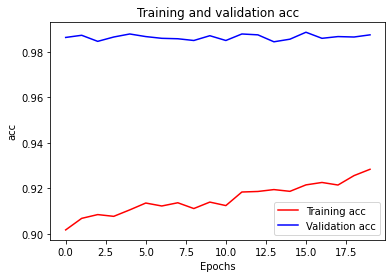

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 2 цикл

Normalized confusion matrix


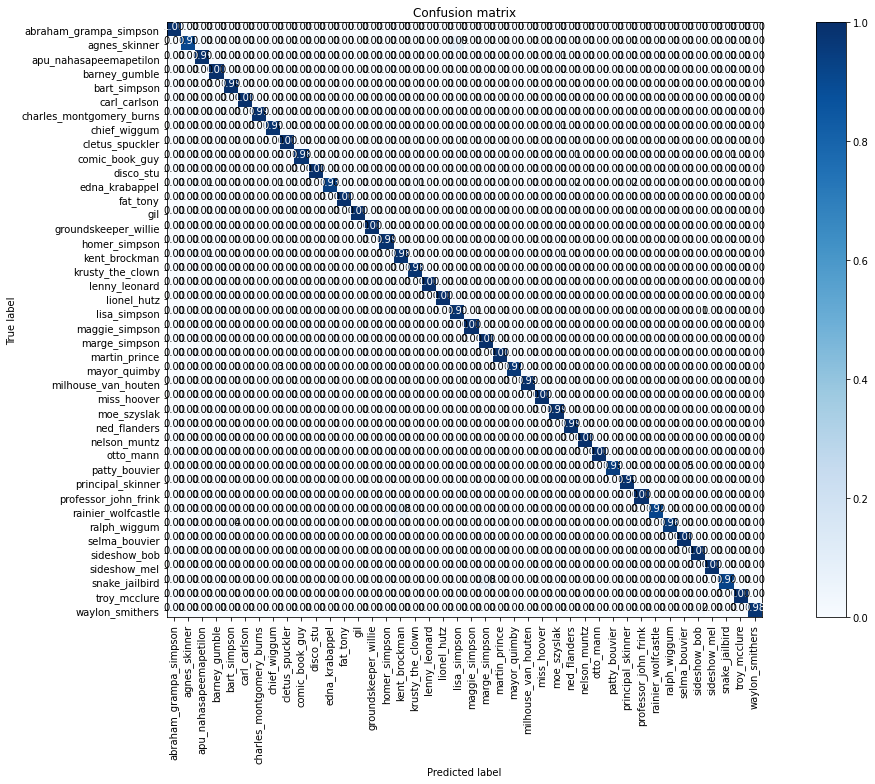

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_wide_resnet101_2, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[228, 11, 153, 25, 336, 24, 299, 244, 11, 118, 2, 121, 7, 6, 30, 567, 126, 303, 77, 1, 342, 29, 322, 17, 62, 272, 4, 359, 363, 89, 8, 19, 299, 15, 12, 23, 25, 215, 9, 13, 2, 46]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	90 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	98 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	93 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	98 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	96 %
Accuracy of m

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
print(f'Использовано {torch.cuda.memory_allocated() * 9.31e-10}')

Использовано 2.817748333568


### 3-тий цикл обучения (20 эпох) Accuracy: 0.9880

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_wide_resnet101_2.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_wide_resnet101_2, losses, acc, best_model_wts = train_model(model_wide_resnet101_2, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3576 Acc: 0.9062
val Loss: 0.1042 Acc: 0.9792

***new best wts with acc 0.9791746274359954 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3859 Acc: 0.8990
val Loss: 0.0909 Acc: 0.9809

***new best wts with acc 0.980894153611005 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3703 Acc: 0.9035
val Loss: 0.0901 Acc: 0.9822

***new best wts with acc 0.9822315628582347 at 2 epoh***
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3715 Acc: 0.9017
val Loss: 0.0873 Acc: 0.9838

***new best wts with acc 0.9837600305693542 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3396 Acc: 0.9100
val Loss: 0.0884 Acc: 0.9820
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# к сожалению веса третьего цикла обучения не сохранились!
# но они не используются в ансамблях, по которым был получен финальный score
# в соревновании на kaggle

# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_wide_resnet101_2.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9880
print("Accuracy: {0:.4f}".format(evaluate(model_wide_resnet101_2, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9880


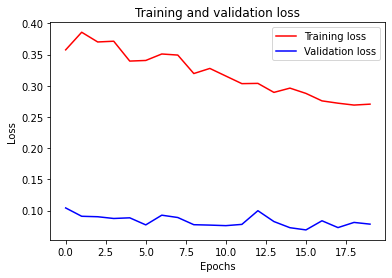

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

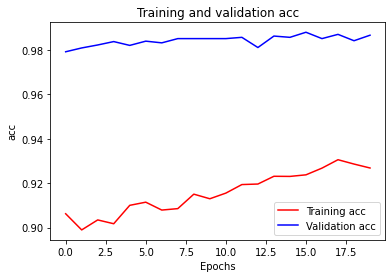

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 3 цикл

Normalized confusion matrix


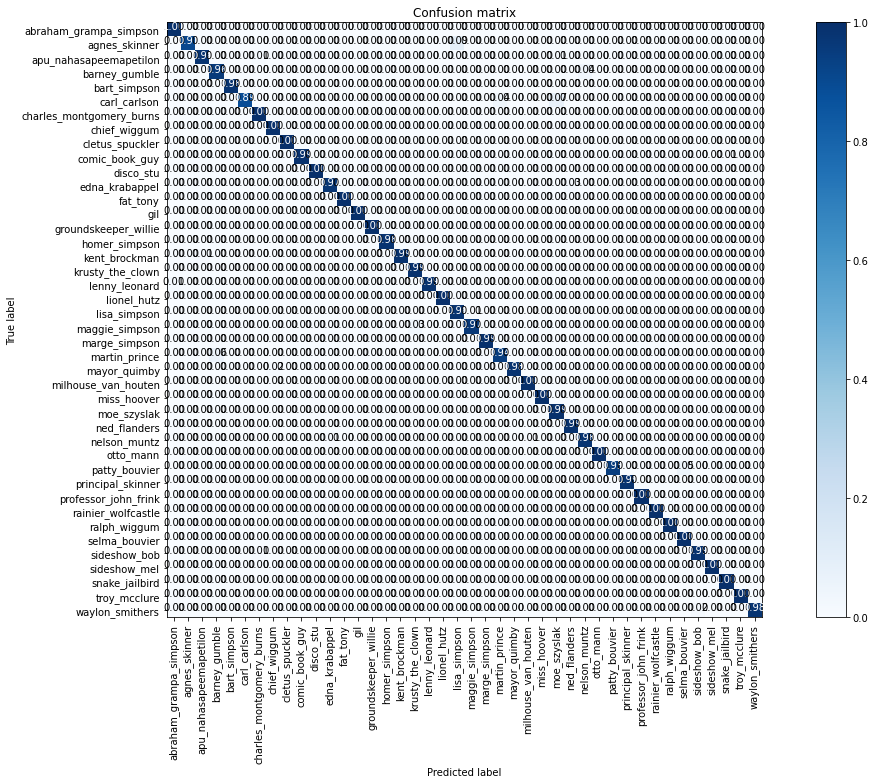

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_wide_resnet101_2, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[225, 11, 155, 25, 340, 27, 293, 243, 11, 118, 2, 115, 7, 7, 30, 570, 126, 300, 78, 1, 343, 31, 324, 18, 62, 270, 4, 357, 362, 89, 8, 19, 302, 14, 11, 21, 25, 220, 10, 13, 2, 45]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	90 %
Accuracy of apu_nahasapeemapetilon	98 %
Accuracy of barney_gumble	96 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	88 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	96 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	94 %
Accuracy of mayor_quimby	98 %
Accuracy of milh

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

## ResNeXt-101-32x8d

Новая современная архитектура, вариация от от resnet. Обладает похожей структурой слоев но имеет большую точность. Обучеим его так же как и resnet152 ранее


https://habr.com/ru/company/mailru/blog/359214/

### по методу Diferential Groups Layers c подбором оптимальной скорости обучения lr

### Подберем оптимальный learning rate для ResNeXt-101-32x8d (подбор learning rate осуществляем на классификаторе)

In [ ]:
# Создаём сеть
model_resnext101_32x8d = models.resnext101_32x8d(pretrained=True)

# посмотрим на сеть от которой мы делаем transfer learning
model_resnext101_32x8d

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnext101_32x8d.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
for param in model_resnext101_32x8d.parameters():
    param.requires_grad = False

for param in model_resnext101_32x8d.fc.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_resnext101_32x8d)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnext101_32x8d)

Params to update:
	 fc.0.weight
	 fc.0.bias
	 fc.1.weight
	 fc.1.bias
	 fc.4.weight
	 fc.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_resnext101_32x8d = model_resnext101_32x8d.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_resnext101_32x8d, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

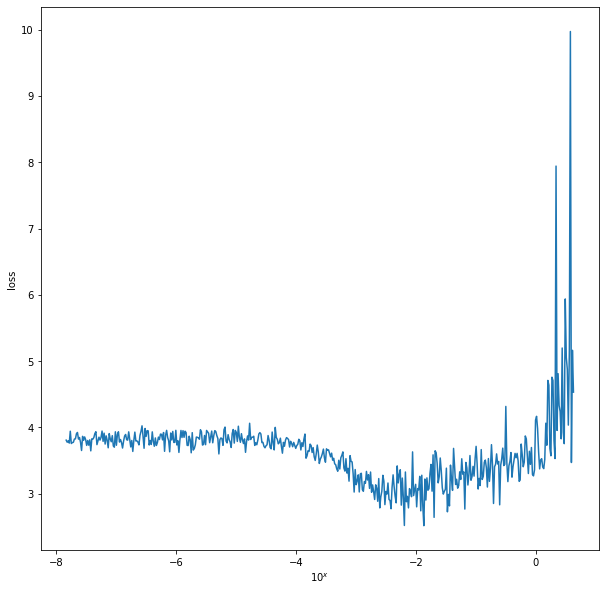

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-3
found_lr

0.001

### Обучение ResNeXt-101-32x8d подходом Differential Groups Layers

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

In [ ]:
# Вернем первоначальные веса resnet50
model_resnext101_32x8d = models.resnext101_32x8d(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnext101_32x8d.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_resnext101_32x8d.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_resnext101_32x8d)

Params to update:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weigh

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

# Выставляем различные скорости обучения для различных слоев
optimizer = torch.optim.Adam([
{ 'params': model_resnext101_32x8d.fc.parameters(), 'lr': found_lr},
{ 'params': model_resnext101_32x8d.layer4.parameters(), 'lr': found_lr / 3},
{ 'params': model_resnext101_32x8d.layer3.parameters(), 'lr': found_lr / 10},
{ 'params': model_resnext101_32x8d.layer2.parameters(), 'lr': found_lr / 50},
{ 'params': model_resnext101_32x8d.layer1.parameters(), 'lr': found_lr / 100},
{'params': model_resnext101_32x8d.bn1.parameters(), 'lr': found_lr / 100},
{'params': model_resnext101_32x8d.conv1.parameters(), 'lr': found_lr / 100}],
lr=found_lr / 100, amsgrad=True)


# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_resnext101_32x8d = model_resnext101_32x8d.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9868

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnext101_32x8d, losses, acc, best_model_wts = train_model(model_resnext101_32x8d, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.6624 Acc: 0.5999
val Loss: 0.3870 Acc: 0.9003

Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 1.0065 Acc: 0.7428
val Loss: 0.2132 Acc: 0.9450

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.7910 Acc: 0.7963
val Loss: 0.2055 Acc: 0.9473

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.6745 Acc: 0.8249
val Loss: 0.1273 Acc: 0.9675

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.6121 Acc: 0.8434
val Loss: 0.0985 Acc: 0.9788

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.5586 Acc: 0.8556
val Loss: 0.0983 Acc: 0.9780

Epoch 6/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
-

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnext101_32x8d.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9868
print("Accuracy: {0:.4f}".format(evaluate(model_resnext101_32x8d, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9868


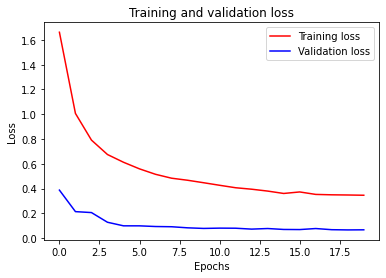

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

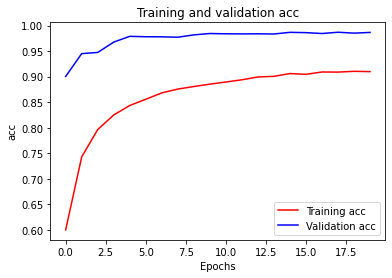

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


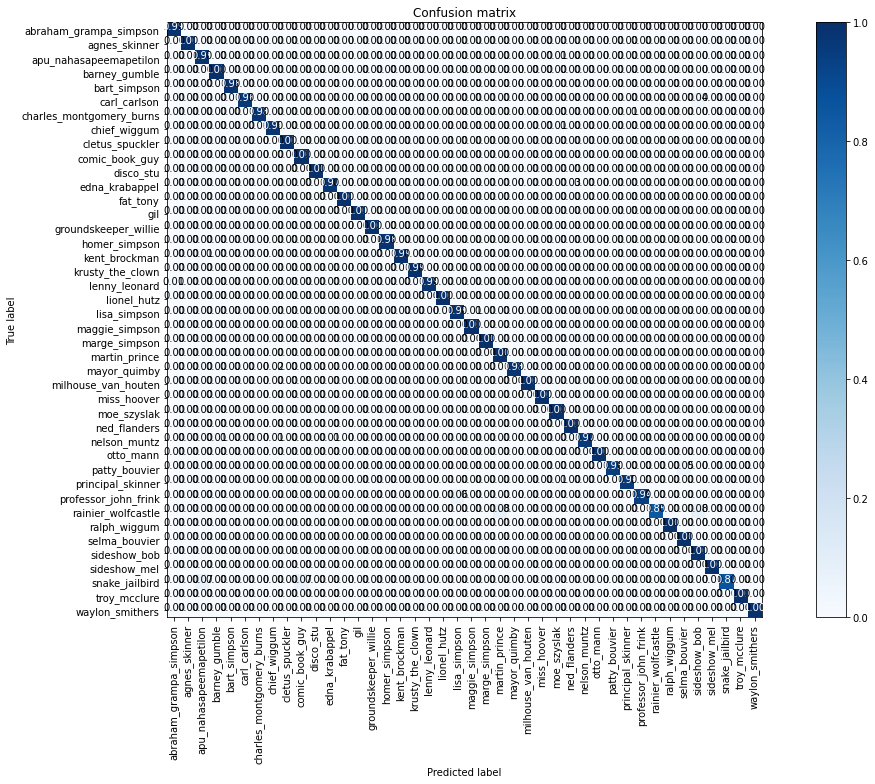

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnext101_32x8d, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[228, 10, 154, 23, 340, 25, 302, 248, 11, 116, 2, 116, 7, 6, 30, 569, 126, 301, 75, 1, 340, 30, 322, 17, 61, 270, 4, 353, 361, 91, 8, 19, 307, 16, 13, 21, 24, 216, 10, 15, 2, 44]
42
Accuracy of abraham_grampa_simpson	98 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	98 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	97 %
Accuracy of chief_wiggum	97 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	100 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	98 %
Accuracy of 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-вый цикл обучения (20 эпох) Accuracy: 0.9891

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnext101_32x8d.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnext101_32x8d, losses, acc, best_model_wts = train_model(model_resnext101_32x8d, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3364 Acc: 0.9130
val Loss: 0.0690 Acc: 0.9872

Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3128 Acc: 0.9160
val Loss: 0.0791 Acc: 0.9830

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3187 Acc: 0.9167
val Loss: 0.0619 Acc: 0.9885

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3054 Acc: 0.9200
val Loss: 0.0676 Acc: 0.9874

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2950 Acc: 0.9216
val Loss: 0.0730 Acc: 0.9853

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2950 Acc: 0.9231
val Loss: 0.0732 Acc: 0.9874

Epoch 6/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
-

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnext101_32x8d.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9891
print("Accuracy: {0:.4f}".format(evaluate(model_resnext101_32x8d, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9891


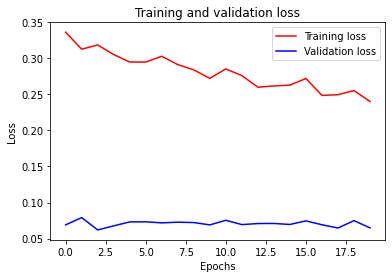

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

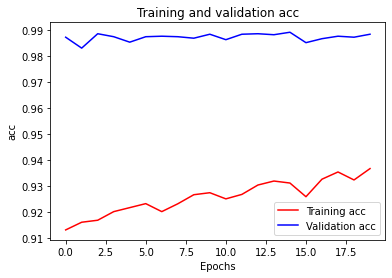

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


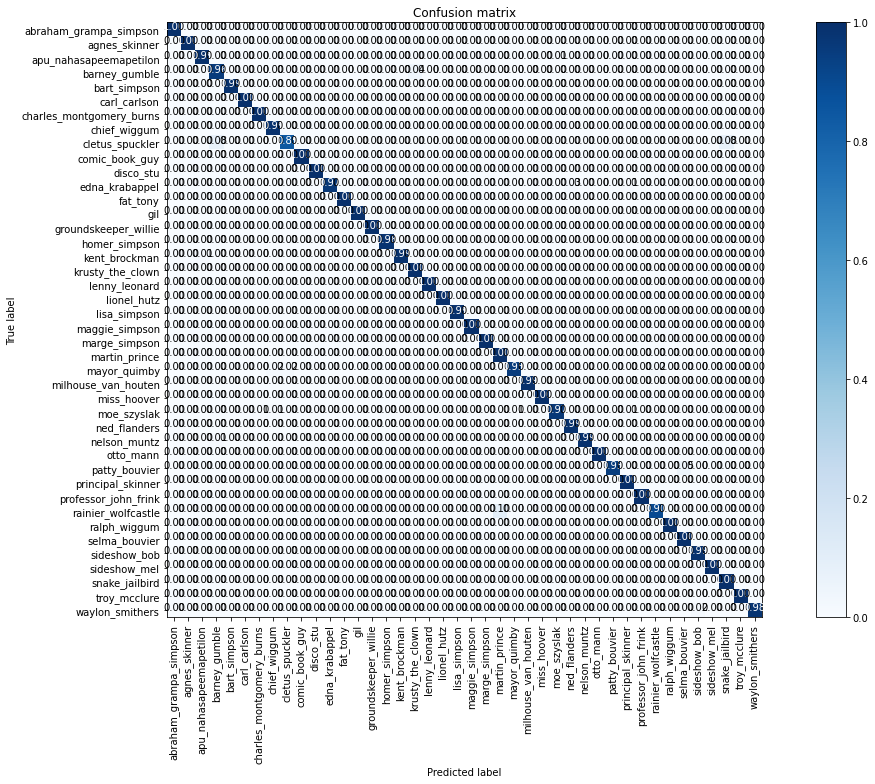

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnext101_32x8d, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[226, 10, 154, 23, 339, 24, 295, 244, 13, 116, 2, 118, 7, 6, 30, 572, 125, 299, 76, 1, 341, 30, 322, 17, 62, 272, 4, 374, 362, 89, 8, 19, 295, 14, 10, 21, 25, 218, 10, 13, 2, 46]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	95 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	100 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	84 %
Accuracy of comic_book_guy	100 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	95 %
Accuracy 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 3-тий цикл обучения (20 эпох) Accuracy: 0.9889

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnext101_32x8d.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_resnext101_32x8d, losses, acc, best_model_wts = train_model(model_resnext101_32x8d, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging activate...



Epoch 0/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3164 Acc: 0.9166
val Loss: 0.0932 Acc: 0.9826

***new best wts with acc 0.9826136797860145 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3229 Acc: 0.9154
val Loss: 0.0918 Acc: 0.9817
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3153 Acc: 0.9152
val Loss: 0.0888 Acc: 0.9832

***new best wts with acc 0.9831868551776843 at 2 epoh***
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.3166 Acc: 0.9148
val Loss: 0.0780 Acc: 0.9855

***new best wts with acc 0.9854795567443637 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2920 Acc: 0.9218
val Loss: 0.0908 Acc: 0.9840
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 

и тут google colab разорвал соединение! Но для нас это не беда =) Ведь каждую эпоху веса сохранялись на google drive. Продолжаем оставшиеся эпохи с того же мета.
При этом как следует из log файла и стандартного вывода мы успели достигнуть лучшей точности на 8 эпохе, acc = 0.9889. Поэтому лучшие по точности веса мы должны сохранять при продолжении обучения только если была достигнута большая точность за оставшиеся эпохи. Укажем это в функции train задав порог для сохрания лучших весов при его превышении best_acc=0.9889.

In [ ]:
# # Зададим путь для сохранения моделей!
# path = '/content/gdrive/My Drive/simpsons_on_cloud/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3'

In [ ]:
# # загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# # точность, а так же losses и accurancy
# model_resnext101_32x8d.load_state_dict(torch.load(path + '.pth'))
# losses = load_dict_from_file(path + '_losses.pickle')
# acc = load_dict_from_file(path + '_acc.pickle')
# print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3.pth


In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
# model_resnext101_32x8d, losses, acc, best_model_wts = train_model(model_resnext101_32x8d, dataloaders, loss_fn, optimizer, num_epochs=3,
#                                                                   flag_save_wts_to_file=True, path=path, losses=losses, acc=acc, best_acc=0.9889)          

Logging...


Epoch 0/2 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2685 Acc: 0.9302
val Loss: 0.0916 Acc: 0.9859
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/2 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2581 Acc: 0.9322
val Loss: 0.0786 Acc: 0.9866
*** save model wts at this 1 epoch ! *** 

Epoch 2/2 lr=[0.001, 0.0003333333333333333, 0.0001, 2e-05, 1e-05, 1e-05, 1e-05]
----------
train Loss: 0.2643 Acc: 0.9296
val Loss: 0.0793 Acc: 0.9870
*** save model wts at this 2 epoch ! *** 


Training complete in 97m 28s
Best val Acc: 0.988900 at 0


In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_resnext101_32x8d.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9889
print("Accuracy: {0:.4f}".format(evaluate(model_resnext101_32x8d, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9889


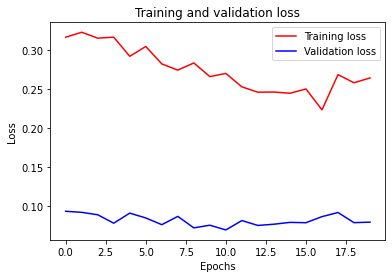

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

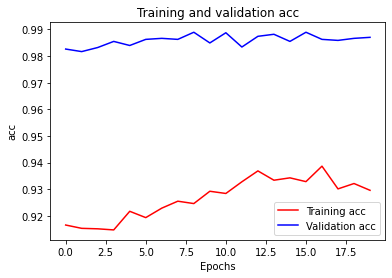

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


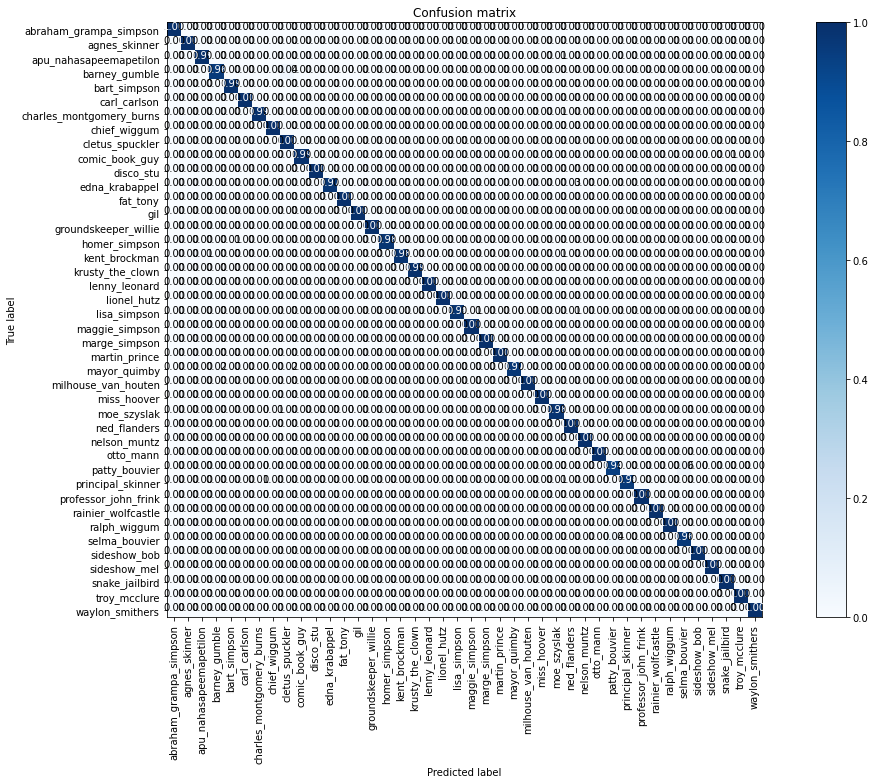

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_resnext101_32x8d, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[227, 10, 154, 24, 336, 24, 298, 242, 10, 118, 2, 117, 7, 6, 29, 572, 127, 302, 76, 1, 344, 29, 322, 17, 62, 269, 4, 363, 358, 89, 8, 18, 311, 14, 11, 21, 26, 218, 10, 13, 2, 43]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	95 %
Accuracy of bart_simpson	99 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	100 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	98 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	97 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	96 %
Accuracy 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

## Densenet-161

Новая современная архитектура. Обучим его так же как и ранее.

![alt text](https://goosemi.files.wordpress.com/2016/06/dense.jpg)

### по методу Diferential Groups Layers c подбором оптимальной скорости обучения lr

### Подберем оптимальный learning rate для ResNet-152 (подбор learning rate осуществляем на классификаторе)

In [ ]:
# Создаём сеть
model_densenet161 = models.densenet161(pretrained=True)

# посмотрим на сеть от которой мы делаем transfer learning
model_densenet161

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet161.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
for param in model_densenet161.parameters():
    param.requires_grad = False

for param in model_densenet161.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_densenet161)

Params to update:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.d

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_densenet161)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_densenet161 = model_densenet161.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_densenet161, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

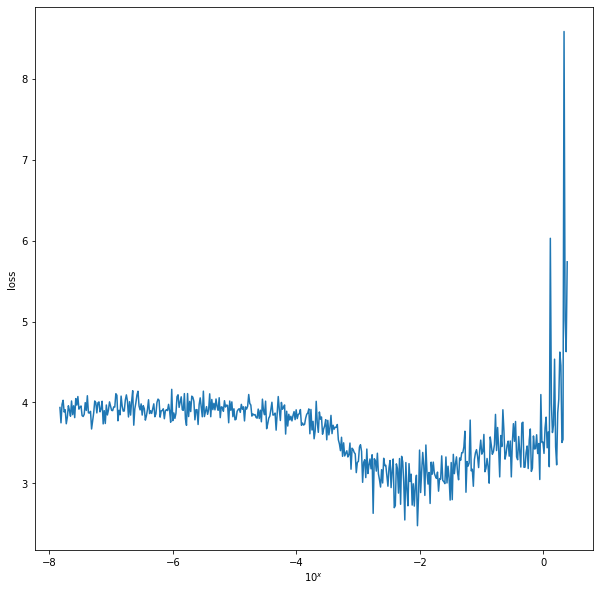

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 1e-3
found_lr = 1e-3
found_lr

0.001

### Обучение Wide ResNet-101-2 подходом Differential Groups Layers

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

In [ ]:
# Вернем первоначальные веса resnet50
model_densenet161 = models.densenet161(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet161.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
# теперь нам необходимо сделать все веса обучаемыми снова!
for param in model_densenet161.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_densenet161)

Params to update:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.d

структура слоев densenet161:

* model_densenet161.features.conv0
* model_densenet161.features.norm0
* model_densenet161.features.denseblock1
* model_densenet161.features.transition1
* model_densenet161.features.denseblock2
* model_densenet161.features.transition2
* model_densenet161.features.denseblock3
* model_densenet161.features.transition3
* model_densenet161.features.denseblock4
* model_densenet161.features.norm5
* model_densenet161.classifier

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

optimizer = torch.optim.Adam([
{ 'params': model_densenet161.features.conv0.parameters(), 'lr': found_lr / 100},
{ 'params': model_densenet161.features.norm0.parameters(), 'lr': found_lr / 100},
{ 'params': model_densenet161.features.denseblock1.parameters(), 'lr': found_lr / 100},
{ 'params': model_densenet161.features.transition1.parameters(), 'lr': found_lr / 100},
{ 'params': model_densenet161.features.denseblock2.parameters(), 'lr': found_lr / 50},
{ 'params': model_densenet161.features.transition2.parameters(), 'lr': found_lr / 50},
{ 'params': model_densenet161.features.denseblock3.parameters(), 'lr': found_lr / 10},
{ 'params': model_densenet161.features.transition3.parameters(), 'lr': found_lr / 10},
{ 'params': model_densenet161.features.denseblock4.parameters(), 'lr': found_lr / 3},
{ 'params': model_densenet161.features.norm5.parameters(), 'lr': found_lr / 3},
{ 'params': model_densenet161.classifier.parameters(), 'lr': found_lr},
], lr=found_lr / 100, amsgrad=True)

# Использовать ли GPU
model_densenet161 = model_densenet161.cuda()


# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_densenet161 = model_densenet161.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9862

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Densenet-161_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_densenet161, losses, acc, best_model_wts = train_model(model_densenet161, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path))          

Epoch 0/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 1.7687 Acc: 0.5723
val Loss: 0.3559 Acc: 0.9119

Epoch 1/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.9715 Acc: 0.7574
val Loss: 0.1681 Acc: 0.9595

Epoch 2/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.7648 Acc: 0.8072
val Loss: 0.1322 Acc: 0.9677

Epoch 3/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.6633 Acc: 0.8322
val Loss: 0.1029 Acc: 0.9765

Epoch 4/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.6012 Acc: 0.8481
val Loss: 0.0997 Acc: 0.9775

Epoch 5/19

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_densenet161.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9862
print("Accuracy: {0:.4f}".format(evaluate(model_densenet161, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9862


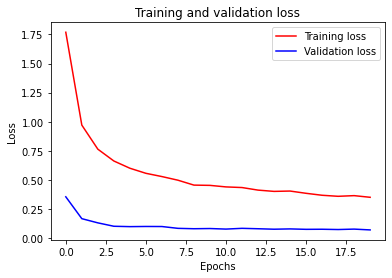

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

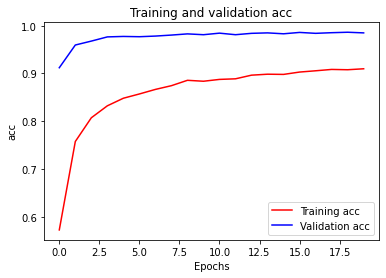

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


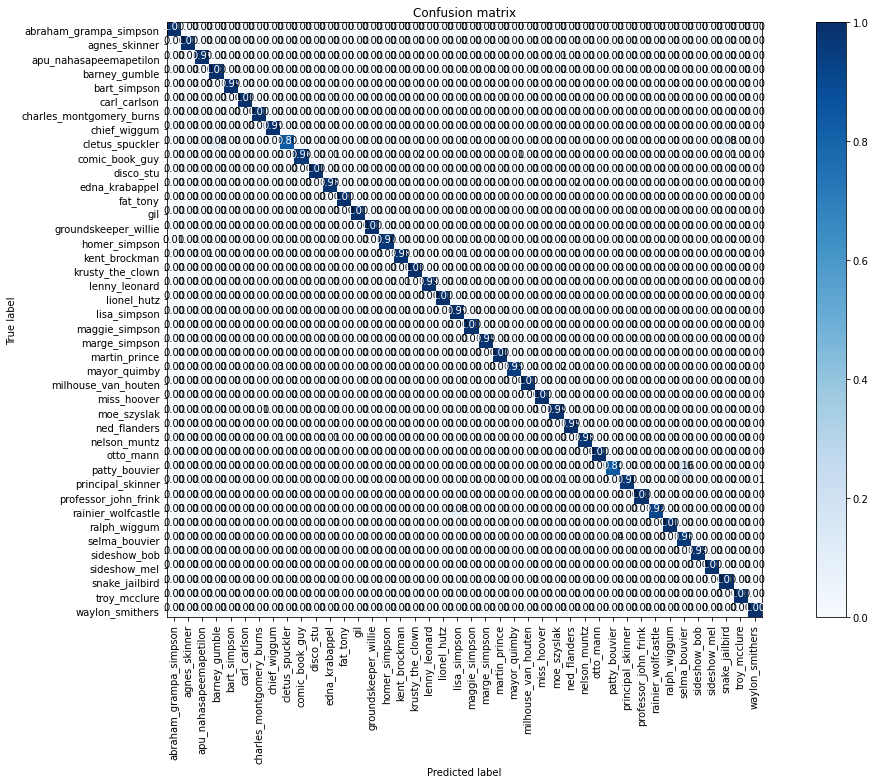

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_densenet161, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[226, 10, 154, 25, 340, 24, 294, 243, 12, 121, 2, 112, 7, 7, 30, 579, 126, 297, 76, 1, 336, 31, 326, 17, 63, 269, 4, 357, 361, 91, 8, 19, 308, 15, 12, 21, 24, 219, 10, 12, 2, 43]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	83 %
Accuracy of comic_book_guy	95 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	98 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	96 %
Accuracy of kent_brockman	98 %
Accuracy of krusty_the_clown	100 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	98 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	95 %
Accuracy of 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-рой цикл обучения (20 эпох) Accuracy: 0.9895

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_densenet161.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Densenet-161_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_densenet161, losses, acc, best_model_wts = train_model(model_densenet161, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path))          

Epoch 0/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.3496 Acc: 0.9117
val Loss: 0.0785 Acc: 0.9857

Epoch 1/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.3555 Acc: 0.9081
val Loss: 0.0802 Acc: 0.9862

Epoch 2/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.3329 Acc: 0.9155
val Loss: 0.0697 Acc: 0.9847

Epoch 3/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.3254 Acc: 0.9152
val Loss: 0.0736 Acc: 0.9859

Epoch 4/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.3225 Acc: 0.9170
val Loss: 0.0704 Acc: 0.9861

Epoch 5/19

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_densenet161.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9895
print("Accuracy: {0:.4f}".format(evaluate(model_densenet161, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9895


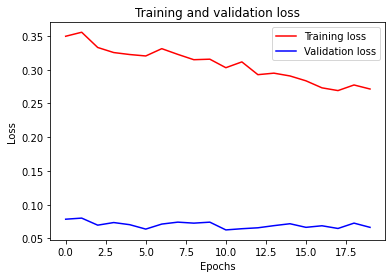

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

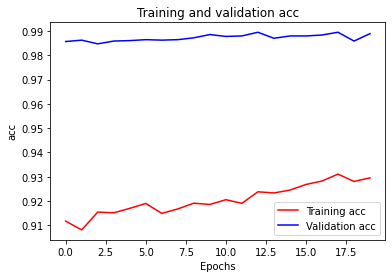

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


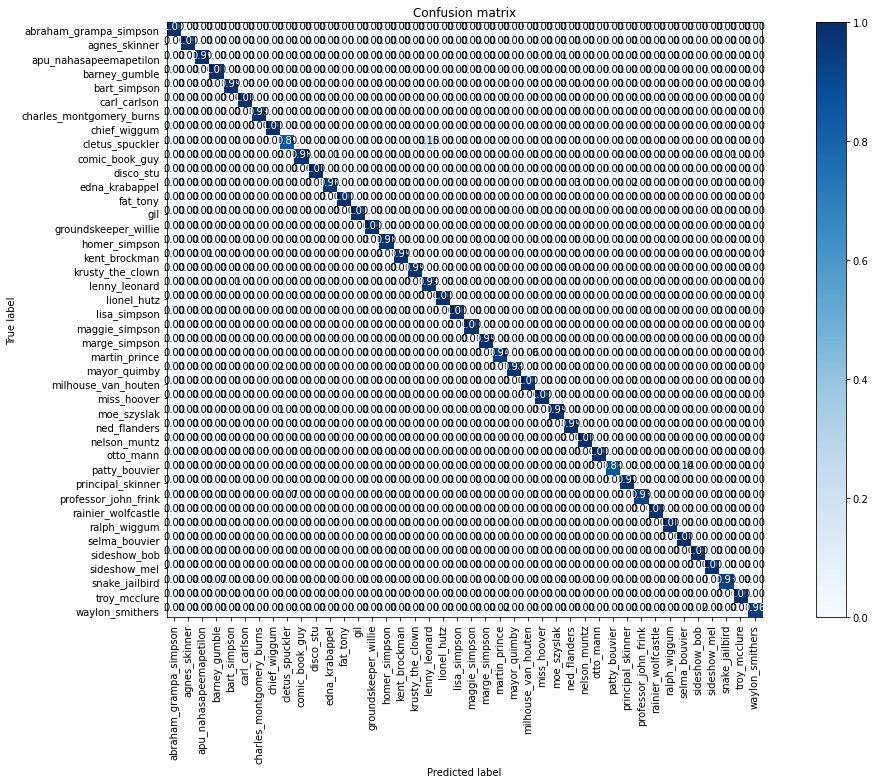

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_densenet161, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[226, 10, 154, 25, 339, 24, 299, 243, 13, 118, 2, 118, 7, 7, 30, 570, 126, 304, 74, 1, 338, 31, 324, 18, 62, 267, 4, 361, 361, 89, 8, 21, 300, 15, 11, 21, 23, 219, 9, 14, 2, 46]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	84 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	95 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	98 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	94 %
Accuracy of mayor_quimby	98 %
Accuracy of mi

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 3-тий цикл обучения (20 эпох) Accuracy: 0.9895

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_densenet161.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Densenet-161_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_densenet161, losses, acc, best_model_wts = train_model(model_densenet161, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path))          

Epoch 0/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.2644 Acc: 0.9310
val Loss: 0.0669 Acc: 0.9880

Epoch 1/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.2624 Acc: 0.9283
val Loss: 0.0688 Acc: 0.9878

Epoch 2/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.2600 Acc: 0.9338
val Loss: 0.0653 Acc: 0.9874

Epoch 3/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.2685 Acc: 0.9304
val Loss: 0.0656 Acc: 0.9887

Epoch 4/19 lr=[1e-05, 1e-05, 1e-05, 1e-05, 2e-05, 2e-05, 0.0001, 0.0001, 0.0003333333333333333, 0.0003333333333333333, 0.001]
----------
train Loss: 0.2537 Acc: 0.9342
val Loss: 0.0664 Acc: 0.9876

Epoch 5/19

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_densenet161.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9895
print("Accuracy: {0:.4f}".format(evaluate(model_densenet161, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9895


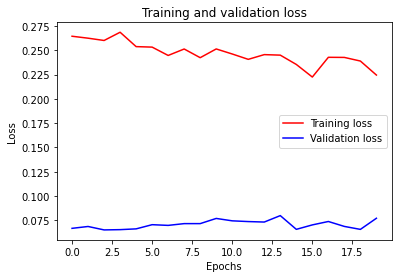

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

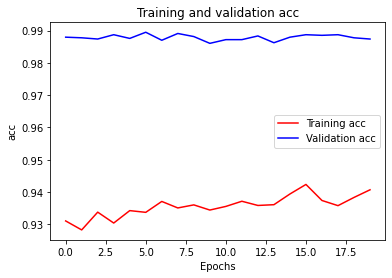

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


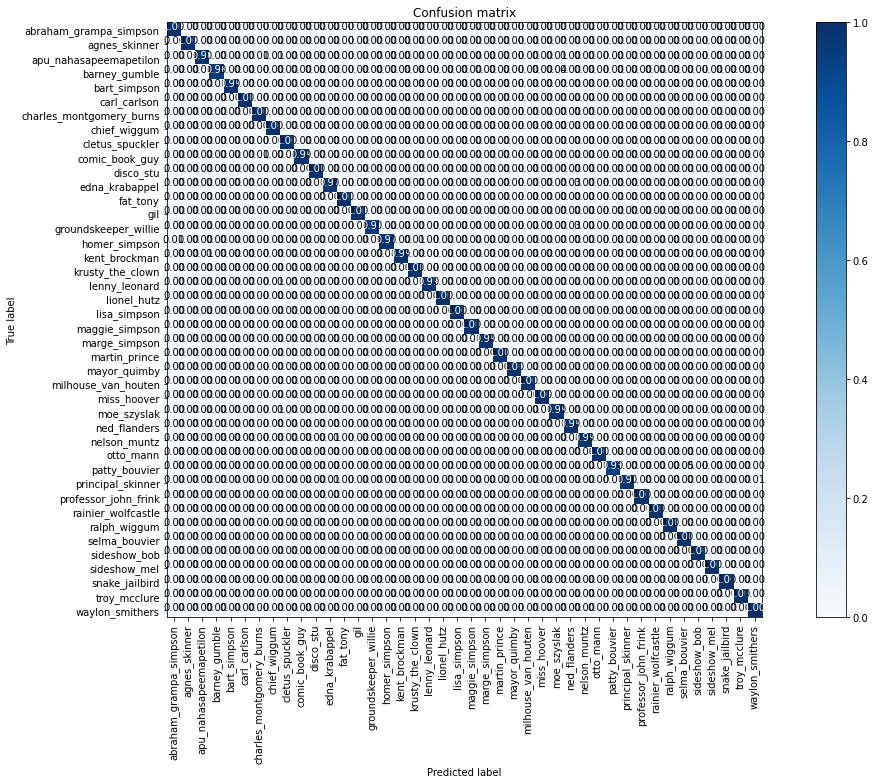

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_densenet161, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[224, 10, 156, 26, 338, 24, 293, 243, 11, 118, 2, 114, 7, 6, 31, 575, 126, 299, 77, 1, 337, 32, 324, 17, 60, 269, 4, 365, 362, 90, 8, 19, 308, 15, 11, 21, 25, 219, 9, 14, 2, 42]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	98 %
Accuracy of barney_gumble	96 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	100 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	100 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	96 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	100 %
Accuracy of 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

## Google's EfficientNet B6 (PyTorch Edition)

Архитектура EfficientNet
Эффективность масштабирования нейросети зависит от ее начальной архитектуры. Чтобы улучшить работу нейросети, исследователи выбирали начальную архитектуру автоматически с помощью AutoML фреймворка — MNAS. MNAS при выборе устройства нейросети оптимизирует и точность модели, и ее размер одновременно (FLOPS). В итоге начальная модель использовала архитектуру MBConv, схожую с MobileNetV2 и MnasNet. Начальная модель затем масштабировалась и породила класс EfficientNets моделей.

![alt text](https://neurohive.io/wp-content/uploads/2019/05/image2-2-570x118.png)

Сравнительный график эффективности различных архитектур на ImageNet

![alt text](https://neurohive.io/wp-content/uploads/2019/05/Snimok-ekrana-2019-05-31-v-15.04.48-541x422.png)

Используем показанную Ильей Захаркиным библиотеку с архитектурой EfficientNet из семинара семинара: "Нейросети в компьютерном зрении: практика (08.12.2019)".


https://www.youtube.com/watch?v=XSPYe4-y4HE

**> Мы вместо этого используем [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)**

In [ ]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=00b8236ad161af75c0aeb52b051bd3c62e010eea8d40bdecda9ea0b55df18de6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    model = EfficientNet.from_pretrained(model_name, num_classes=classes_number)

    return model

model_name = 'efficientnet-b6'
model_effnet_b6 = get_model(model_name, classes_number)
model_effnet_b6 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/checkpoints/efficientnet-b6-c76e70fd.pth



Loaded pretrained weights for efficientnet-b6


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        56, 14, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        14, 56, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        56, 32, kernel_siz

#### Подберем оптимальный learning rate для ResNet-152 (подбор learning rate осуществляем на классификаторе)

In [ ]:
# посмотрим какие параметры в нашей модели можно обучать
print_params(model_effnet_b6)

Params to update:
	 _conv_stem.weight
	 _bn0.weight
	 _bn0.bias
	 _blocks.0._depthwise_conv.weight
	 _blocks.0._bn1.weight
	 _blocks.0._bn1.bias
	 _blocks.0._se_reduce.weight
	 _blocks.0._se_reduce.bias
	 _blocks.0._se_expand.weight
	 _blocks.0._se_expand.bias
	 _blocks.0._project_conv.weight
	 _blocks.0._bn2.weight
	 _blocks.0._bn2.bias
	 _blocks.1._depthwise_conv.weight
	 _blocks.1._bn1.weight
	 _blocks.1._bn1.bias
	 _blocks.1._se_reduce.weight
	 _blocks.1._se_reduce.bias
	 _blocks.1._se_expand.weight
	 _blocks.1._se_expand.bias
	 _blocks.1._project_conv.weight
	 _blocks.1._bn2.weight
	 _blocks.1._bn2.bias
	 _blocks.2._depthwise_conv.weight
	 _blocks.2._bn1.weight
	 _blocks.2._bn1.bias
	 _blocks.2._se_reduce.weight
	 _blocks.2._se_reduce.bias
	 _blocks.2._se_expand.weight
	 _blocks.2._se_expand.bias
	 _blocks.2._project_conv.weight
	 _blocks.2._bn2.weight
	 _blocks.2._bn2.bias
	 _blocks.3._expand_conv.weight
	 _blocks.3._bn0.weight
	 _blocks.3._bn0.bias
	 _blocks.3._depthwise_conv.we

In [ ]:
for param in model_effnet_b6.parameters():
    param.requires_grad = False

for param in model_effnet_b6._fc.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_effnet_b6)

Params to update:
	 _fc.weight
	 _fc.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_effnet_b6 = model_effnet_b6.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_effnet_b6, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

(2.8, 4.0)

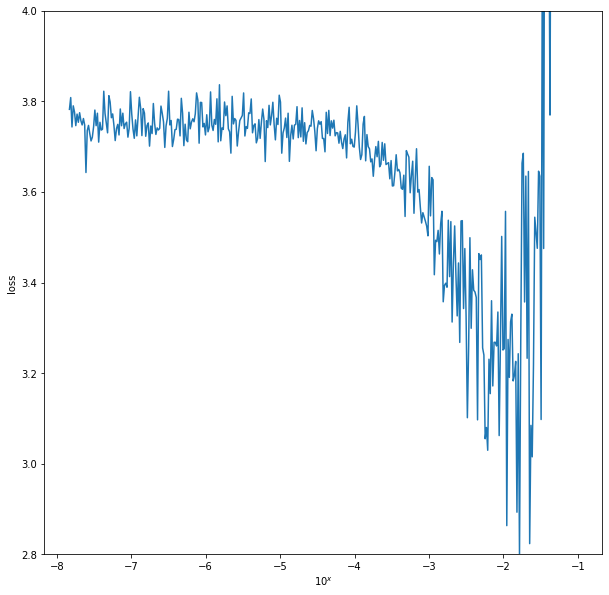

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")
ax.set_ylim(2.8,4)

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

По оси абсцисс у нас значение lr ее степени 10 (например x=-2 , значит что lr=10**-2=0.01) по оси ординат показаны значения loss функции полученные при даном lr. Значение оптимального lr наблюдается там где у нас видно резкое спадание значения loss функции по графику. Резкий спад наблюдается от lr=[10**-4, 10**-2] , поэтому в данном случае оптимальным будет lr=10**-3.

In [ ]:
# из графика видно, что лучший lr для это 10**(-2.3)
found_lr = 10**(-2.3)
found_lr

In [ ]:
found_lr = 0.005
found_lr

0.005

#### предварительная настройка

In [ ]:
BATCH_SIZE

32

In [ ]:
from efficientnet_pytorch import EfficientNet

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    model = EfficientNet.from_pretrained(model_name, num_classes=classes_number)

    return model

model_name = 'efficientnet-b6'
model_effnet_b6 = get_model(model_name, classes_number)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/checkpoints/efficientnet-b6-c76e70fd.pth



Loaded pretrained weights for efficientnet-b6


In [ ]:
# посмотрим какие параметры учим (учим все слои)
params_to_update = print_learn_params(model_effnet_b6)

Params to update:
	 _conv_stem.weight
	 _bn0.weight
	 _bn0.bias
	 _blocks.0._depthwise_conv.weight
	 _blocks.0._bn1.weight
	 _blocks.0._bn1.bias
	 _blocks.0._se_reduce.weight
	 _blocks.0._se_reduce.bias
	 _blocks.0._se_expand.weight
	 _blocks.0._se_expand.bias
	 _blocks.0._project_conv.weight
	 _blocks.0._bn2.weight
	 _blocks.0._bn2.bias
	 _blocks.1._depthwise_conv.weight
	 _blocks.1._bn1.weight
	 _blocks.1._bn1.bias
	 _blocks.1._se_reduce.weight
	 _blocks.1._se_reduce.bias
	 _blocks.1._se_expand.weight
	 _blocks.1._se_expand.bias
	 _blocks.1._project_conv.weight
	 _blocks.1._bn2.weight
	 _blocks.1._bn2.bias
	 _blocks.2._depthwise_conv.weight
	 _blocks.2._bn1.weight
	 _blocks.2._bn1.bias
	 _blocks.2._se_reduce.weight
	 _blocks.2._se_reduce.bias
	 _blocks.2._se_expand.weight
	 _blocks.2._se_expand.bias
	 _blocks.2._project_conv.weight
	 _blocks.2._bn2.weight
	 _blocks.2._bn2.bias
	 _blocks.3._expand_conv.weight
	 _blocks.3._bn0.weight
	 _blocks.3._bn0.bias
	 _blocks.3._depthwise_conv.we

In [ ]:
params_number_name = print_params(model_effnet_b6)

Params to update:
0 _conv_stem.weight
1 _bn0.weight
2 _bn0.bias
3 _blocks.0._depthwise_conv.weight
4 _blocks.0._bn1.weight
5 _blocks.0._bn1.bias
6 _blocks.0._se_reduce.weight
7 _blocks.0._se_reduce.bias
8 _blocks.0._se_expand.weight
9 _blocks.0._se_expand.bias
10 _blocks.0._project_conv.weight
11 _blocks.0._bn2.weight
12 _blocks.0._bn2.bias
13 _blocks.1._depthwise_conv.weight
14 _blocks.1._bn1.weight
15 _blocks.1._bn1.bias
16 _blocks.1._se_reduce.weight
17 _blocks.1._se_reduce.bias
18 _blocks.1._se_expand.weight
19 _blocks.1._se_expand.bias
20 _blocks.1._project_conv.weight
21 _blocks.1._bn2.weight
22 _blocks.1._bn2.bias
23 _blocks.2._depthwise_conv.weight
24 _blocks.2._bn1.weight
25 _blocks.2._bn1.bias
26 _blocks.2._se_reduce.weight
27 _blocks.2._se_reduce.bias
28 _blocks.2._se_expand.weight
29 _blocks.2._se_expand.bias
30 _blocks.2._project_conv.weight
31 _blocks.2._bn2.weight
32 _blocks.2._bn2.bias
33 _blocks.3._expand_conv.weight
34 _blocks.3._bn0.weight
35 _blocks.3._bn0.bias
36 _

In [ ]:
lrs = 147*[found_lr/100] + 145*[found_lr/50] + 145*[found_lr/10] + 145*[found_lr/3] + 2*[found_lr]

<Figure size 432x288 with 0 Axes>

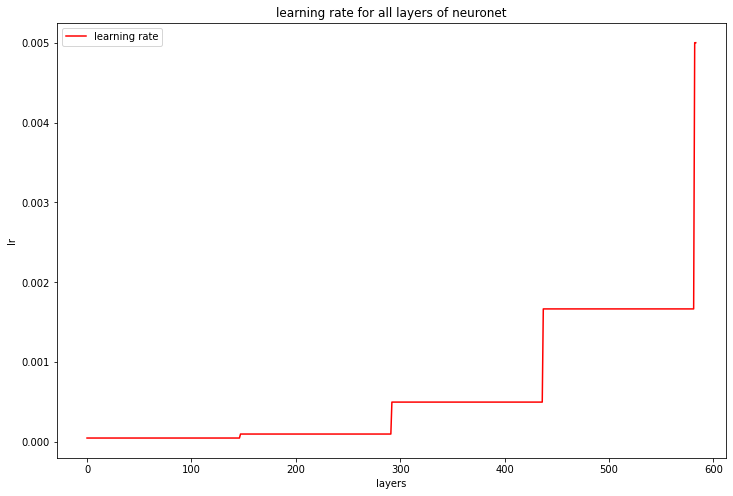

In [ ]:
show_param_lr_plots(params_number_name, lrs, layer_names=False, figsize=(12,8))

In [ ]:
learn_params = set_learn_params(model_effnet_b6, lrs)

Params to learn:
5e-05 _conv_stem.weight
5e-05 _bn0.weight
5e-05 _bn0.bias
5e-05 _blocks.0._depthwise_conv.weight
5e-05 _blocks.0._bn1.weight
5e-05 _blocks.0._bn1.bias
5e-05 _blocks.0._se_reduce.weight
5e-05 _blocks.0._se_reduce.bias
5e-05 _blocks.0._se_expand.weight
5e-05 _blocks.0._se_expand.bias
5e-05 _blocks.0._project_conv.weight
5e-05 _blocks.0._bn2.weight
5e-05 _blocks.0._bn2.bias
5e-05 _blocks.1._depthwise_conv.weight
5e-05 _blocks.1._bn1.weight
5e-05 _blocks.1._bn1.bias
5e-05 _blocks.1._se_reduce.weight
5e-05 _blocks.1._se_reduce.bias
5e-05 _blocks.1._se_expand.weight
5e-05 _blocks.1._se_expand.bias
5e-05 _blocks.1._project_conv.weight
5e-05 _blocks.1._bn2.weight
5e-05 _blocks.1._bn2.bias
5e-05 _blocks.2._depthwise_conv.weight
5e-05 _blocks.2._bn1.weight
5e-05 _blocks.2._bn1.bias
5e-05 _blocks.2._se_reduce.weight
5e-05 _blocks.2._se_reduce.bias
5e-05 _blocks.2._se_expand.weight
5e-05 _blocks.2._se_expand.bias
5e-05 _blocks.2._project_conv.weight
5e-05 _blocks.2._bn2.weight
5e-

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Дифференциальное обучение подход взят из 
# https://blog.slavv.com/differential-learning-rates-59eff5209a4f
# и книги Ian Pointer - Programming PyTorch for Deep Learning_ Creating and Deploying Deep Learning Applications-O’Reilly Media (2019)
# сылка на книгу на goodreads (https://www.goodreads.com/book/show/48225828-programming-pytorch-for-deep-learning)
# Chapter 4. Transfer Learning and Other Tricks про
# Transfer Learning with ResNet50

optimizer = torch.optim.Adam(learn_params, lr=found_lr / 100, amsgrad=True)

# Использовать ли GPU
model_effnet_b6 = model_effnet_b6.cuda()

### 1-вый цикл обучения (20 эпох) Accuracy: 0.9874

In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Effnet_b6_DGL_fc_linear_AdamW_aug_oversampling_for_Ensemble_batchsize_32'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_effnet_b6, losses, acc, best_model_wts = train_model(model_effnet_b6, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_effnet_b6.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9874
print("Accuracy: {0:.4f}".format(evaluate(model_effnet_b6, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9874


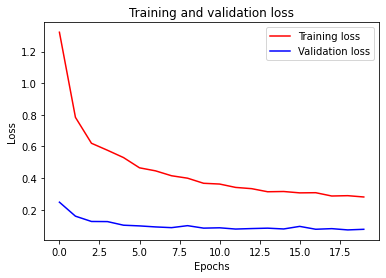

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

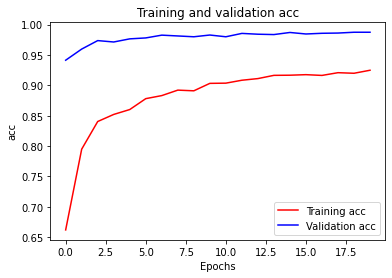

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


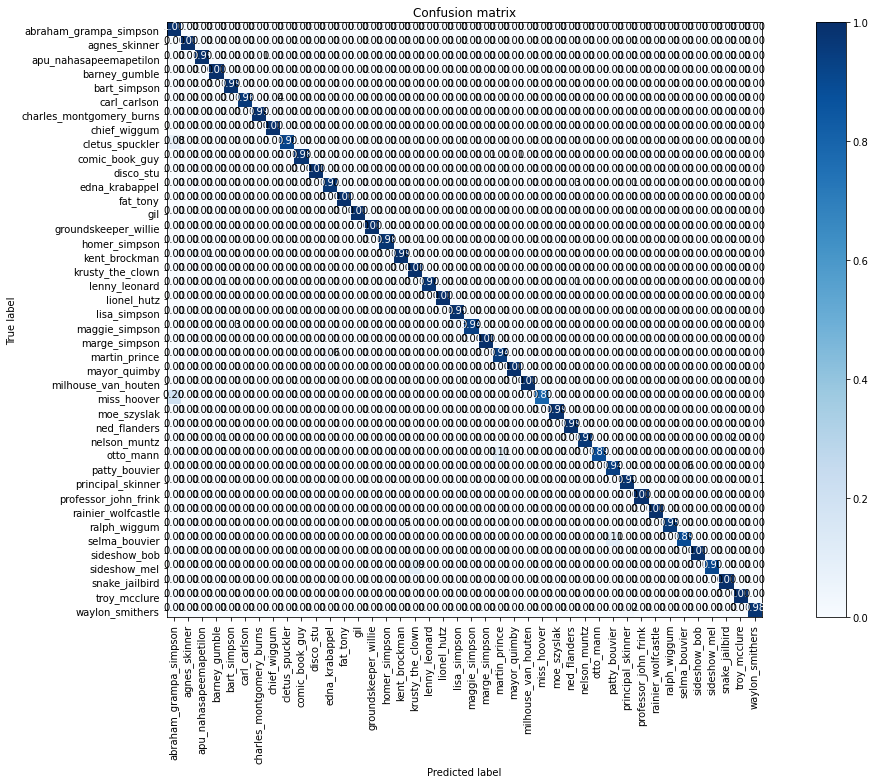

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_effnet_b6, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[226, 10, 154, 23, 335, 25, 296, 244, 12, 119, 2, 117, 7, 7, 30, 572, 125, 298, 78, 1, 342, 34, 319, 18, 60, 270, 5, 366, 361, 91, 9, 16, 301, 15, 10, 22, 28, 218, 11, 11, 2, 44]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	98 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	91 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	100 %
Accuracy of lenny_leonard	97 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	94 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	94 %
Accuracy of mayor_quimby	100 %
Accuracy of mi

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

### 2-рой цикл обучения (20 эпох) Accuracy: 0.9864

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_effnet_b6.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud/Effnet_b6_DGL_fc_linear_AdamW_aug_oversampling_for_Ensemble_batchsize_32.pth


In [ ]:
# Зададим путь для сохранения моделей!
path = '/content/gdrive/My Drive/simpsons_on_cloud/Effnet_b6_DGL_linear_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2'

In [ ]:
# Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_effnet_b6, losses, acc, best_model_wts = train_model(model_effnet_b6, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-05

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_effnet_b6.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9864
print("Accuracy: {0:.4f}".format(evaluate(model_effnet_b6, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9864


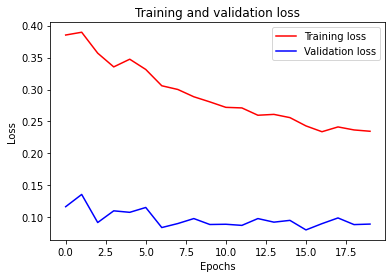

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

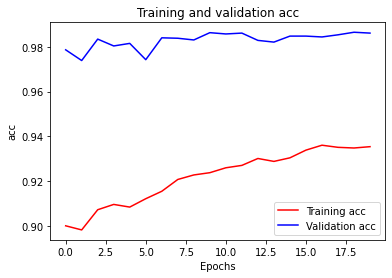

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 2 цикл

Normalized confusion matrix


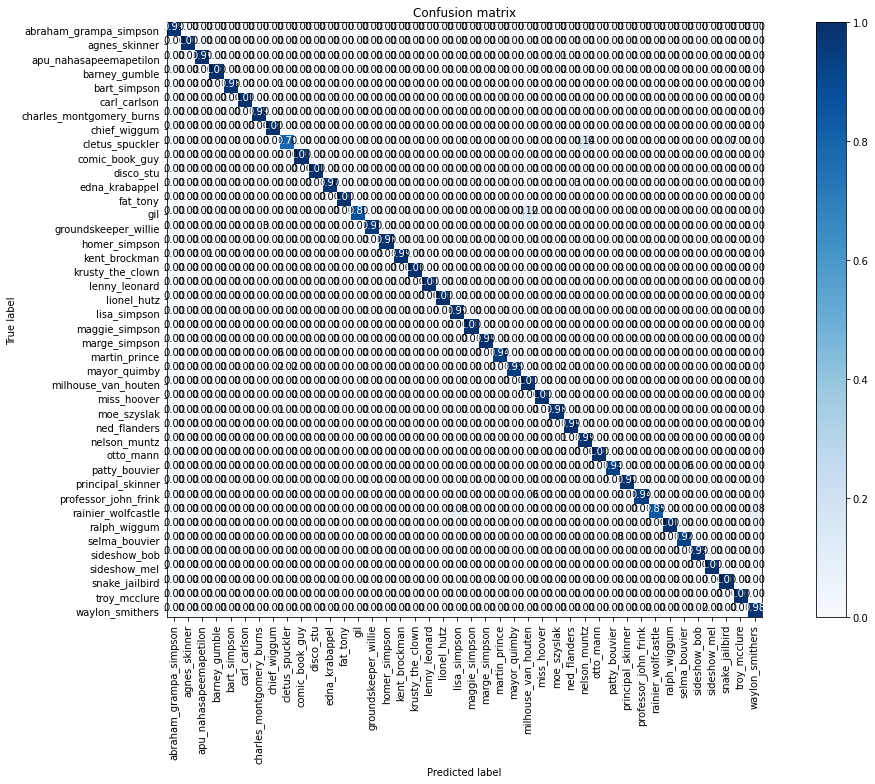

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_effnet_b6, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[230, 10, 153, 25, 340, 24, 296, 240, 14, 117, 2, 115, 7, 8, 31, 574, 126, 295, 77, 1, 341, 28, 324, 18, 63, 266, 4, 366, 364, 87, 8, 17, 301, 16, 13, 21, 26, 219, 10, 13, 2, 42]
42
Accuracy of abraham_grampa_simpson	98 %
Accuracy of agnes_skinner	100 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	100 %
Accuracy of cletus_spuckler	78 %
Accuracy of comic_book_guy	100 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	97 %
Accuracy of fat_tony	100 %
Accuracy of   gil	87 %
Accuracy of groundskeeper_willie	96 %
Accuracy of homer_simpson	97 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	100 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	99 %
Accuracy of martin_prince	94 %
Accuracy of mayor_quimby	95 %
Accuracy of 

In [ ]:
# освободим cuda кэш
torch.cuda.empty_cache()

#Сравнительная таблица точности различных архитектур нейростей, обученных при oversampling и методом DGL

(таблица создана из excell-файла с сохранением его в csv-файл и преобразованием в таблицу markdown c помощью этого сайта [markdown_tables](https://tablesgenerator.com/markdown_tables), чтобы таблицы выглядили органично.)


Таблица получилась очень уж широкой! приодится испоьзовать прокрутку. В самой ее правой части есть два Ансамбля которые и используются для финального score в соревновании!

| ﻿Persons                  | RawDataset(Train part) | oversampling Dataset(Train part) | VGG_bn DGL(20 эпох) | VGG_bn DGL(40 эпох) | VGG_bn DGL(60 эпох) | wide resnet 101-2 DGL(20 эпох) | wide resnet 101-2 DGL(40 эпох) | wide resnet 101-2 DGL(60 эпох) | densenet161 DGL(20 эпох, lr=0.001) | densenet161 DGL(40 эпох, lr=0.001) | densenet161 DGL(60 эпох, lr=0.001) | resnet151 DGL(20 эпох) | resnet151 DGL(40 эпох) | ResNeXt-101-32x8d DGL(20 эпох) | ResNeXt-101-32x8d DGL(40 эпох) | ResNeXt-101-32x8d DGL(60 эпох) | EfficientNet B6 DGL(20 эпох) | EfficientNet B6 DGL(40 эпох) | Ансамбль1(20 эпох) | Ансамбль1(40 эпох) | Ансамбль2(20 эпох) |
|--------------------------|------------------------|----------------------------------|---------------------|---------------------|---------------------|--------------------------------|--------------------------------|--------------------------------|------------------------------------|------------------------------------|------------------------------------|------------------------|------------------------|--------------------------------|--------------------------------|--------------------------------|------------------------------|------------------------------|--------------------|--------------------|--------------------|
| abraham_grampa_simpson   | 685                    | 685                              | 0,99                | 0,99                | 1                   | 1                              | 0,99                           | 1                              | 0,99                               | 1                                  | 1                                  | 0,99                   | 0,99                   | 0,98                           | 1                              | 1                              | 0,99                         | 0,98                         | 1                  | 0,99               | 1                  |
| agnes_skinner            | 32                     | 100                              | 0,9                 | 1                   | 1                   | 1                              | 0,9                            | 0,9                            | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 1                            | 0,83               | 0,83               | 0,9                |
| apu_nahasapeemapetilon   | 467                    | 467                              | 0,98                | 0,98                | 0,96                | 1                              | 0,99                           | 0,98                           | 0,99                               | 0,99                               | 0,98                               | 1                      | 1                      | 0,98                           | 0,99                           | 0,99                           | 0,99                         | 0,99                         | 0,99               | 0,99               | 0,99               |
| barney_gumble            | 80                     | 100                              | 0,95                | 0,96                | 0,92                | 0,95                           | 1                              | 0,96                           | 1                                  | 1                                  | 0,96                               | 0,92                   | 1                      | 1                              | 0,95                           | 0,95                           | 1                            | 1                            | 1                  | 1                  | 1                  |
| bart_simpson             | 1006                   | 1006                             | 0,96                | 0,98                | 0,99                | 0,98                           | 0,99                           | 0,98                           | 0,98                               | 0,98                               | 0,98                               | 0,99                   | 0,99                   | 0,98                           | 0,99                           | 0,99                           | 0,98                         | 0,98                         | 0,98               | 0,98               | 0,98               |
| carl_carlson             | 74                     | 100                              | 0,96                | 0,96                | 0,96                | 1                              | 1                              | 0,88                           | 1                                  | 1                                  | 1                                  | 1                      | 0,96                   | 0,96                           | 1                              | 1                              | 0,96                         | 1                            | 1                  | 0,96               | 1                  |
| charles_montgomery_burns | 895                    | 895                              | 0,97                | 0,95                | 0,99                | 0,98                           | 0,98                           | 0,99                           | 0,99                               | 0,98                               | 1                                  | 0,99                   | 0,98                   | 0,97                           | 1                              | 0,98                           | 0,98                         | 0,99                         | 0,99               | 1                  | 0,99               |
| chief_wiggum             | 739                    | 739                              | 0,98                | 0,99                | 0,98                | 0,99                           | 0,98                           | 0,99                           | 0,99                               | 0,99                               | 0,99                               | 1                      | 0,98                   | 0,97                           | 0,99                           | 1                              | 0,99                         | 1                            | 0,99               | 0,99               | 1                  |
| cletus_spuckler          | 35                     | 100                              | 0,62                | 0,9                 | 1                   | 0,91                           | 1                              | 1                              | 0,83                               | 0,84                               | 1                                  | 0,9                    | 1                      | 1                              | 0,84                           | 1                              | 0,91                         | 0,78                         | 0,91               | 0,91               | 0,91               |
| comic_book_guy           | 352                    | 352                              | 0,94                | 0,98                | 0,98                | 0,99                           | 0,98                           | 0,99                           | 0,95                               | 0,98                               | 0,99                               | 0,99                   | 0,99                   | 1                              | 1                              | 0,99                           | 0,98                         | 1                            | 0,99               | 0,98               | 0,98               |
| disco_stu                | 6                      | 100                              | 1                   | 1                   | 1                   | 0,66                           | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 1                            | 1                  | 1                  | 1                  |
| edna_krabappel           | 343                    | 343                              | 0,96                | 0,95                | 0,96                | 0,97                           | 0,93                           | 0,97                           | 0,98                               | 0,95                               | 0,97                               | 0,96                   | 0,97                   | 0,97                           | 0,96                           | 0,97                           | 0,96                         | 0,97                         | 0,96               | 0,96               | 0,96               |
| fat_tony                 | 20                     | 100                              | 0,77                | 0,87                | 0,77                | 0,87                           | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 1                            | 1                  | 1                  | 1                  |
| gil                      | 20                     | 100                              | 1                   | 1                   | 1                   | 1                              | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 0,87                         | 1                  | 1                  | 1                  |
| groundskeeper_willie     | 91                     | 100                              | 1                   | 1                   | 0,96                | 1                              | 1                              | 1                              | 1                                  | 1                                  | 0,96                               | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 0,96                         | 1                  | 1                  | 1                  |
| homer_simpson            | 1684                   | 1684                             | 0,96                | 0,96                | 0,97                | 0,97                           | 0,98                           | 0,98                           | 0,96                               | 0,98                               | 0,97                               | 0,96                   | 0,97                   | 0,98                           | 0,98                           | 0,97                           | 0,97                         | 0,97                         | 0,98               | 0,98               | 0,98               |
| kent_brockman            | 373                    | 373                              | 0,98                | 1                   | 0,99                | 0,99                           | 0,98                           | 0,99                           | 0,98                               | 0,99                               | 0,99                               | 0,96                   | 0,99                   | 0,99                           | 0,99                           | 0,98                           | 0,99                         | 0,99                         | 0,99               | 0,99               | 0,99               |
| krusty_the_clown         | 904                    | 904                              | 0,98                | 0,98                | 0,99                | 0,99                           | 0,98                           | 0,99                           | 1                                  | 0,98                               | 0,99                               | 0,99                   | 0,99                   | 0,99                           | 0,99                           | 0,99                           | 1                            | 1                            | 0,99               | 0,99               | 0,99               |
| lenny_leonard            | 233                    | 233                              | 1                   | 1                   | 0,96                | 0,98                           | 1                              | 0,98                           | 0,98                               | 0,98                               | 0,98                               | 0,98                   | 1                      | 0,98                           | 1                              | 1                              | 0,97                         | 1                            | 1                  | 1                  | 0,98               |
| lionel_hutz              | 2                      | 100                              | 1                   | 1                   | 1                   | 1                              | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 1                            | 1                  | 1                  | 1                  |
| lisa_simpson             | 1015                   | 1015                             | 0,98                | 0,99                | 0,99                | 0,98                           | 0,98                           | 0,98                           | 0,99                               | 0,99                               | 0,99                               | 0,98                   | 0,98                   | 0,98                           | 0,99                           | 0,97                           | 0,98                         | 0,98                         | 0,99               | 0,99               | 0,98               |
| maggie_simpson           | 96                     | 100                              | 0,96                | 1                   | 1                   | 1                              | 1                              | 0,96                           | 1                                  | 1                                  | 1                                  | 1                      | 0,93                   | 1                              | 1                              | 1                              | 0,94                         | 1                            | 1                  | 1                  | 1                  |
| marge_simpson            | 968                    | 968                              | 0,98                | 0,99                | 0,99                | 0,99                           | 0,99                           | 0,99                           | 0,98                               | 0,99                               | 0,99                               | 0,99                   | 1                      | 0,99                           | 1                              | 1                              | 0,99                         | 0,99                         | 1                  | 1                  | 1                  |
| martin_prince            | 53                     | 100                              | 0,89                | 1                   | 1                   | 1                              | 1                              | 0,94                           | 1                                  | 0,94                               | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 0,94                         | 0,94                         | 1                  | 1                  | 1                  |
| mayor_quimby             | 185                    | 185                              | 0,95                | 0,96                | 0,96                | 0,9                            | 0,96                           | 0,98                           | 0,95                               | 0,98                               | 1                                  | 0,98                   | 1                      | 0,98                           | 0,95                           | 0,96                           | 1                            | 0,95                         | 0,98               | 0,98               | 1                  |
| milhouse_van_houten      | 809                    | 809                              | 0,99                | 1                   | 0,99                | 0,99                           | 0,99                           | 0,99                           | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 0,99                           | 1                              | 0,99                         | 1                            | 1                  | 1                  | 1                  |
| miss_hoover              | 13                     | 100                              | 0,66                | 1                   | 1                   | 1                              | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 0,8                          | 1                            | 1                  | 1                  | 1                  |
| moe_szyslak              | 1089                   | 1089                             | 0,98                | 0,96                | 0,97                | 0,98                           | 0,99                           | 0,99                           | 0,99                               | 0,99                               | 0,98                               | 0,98                   | 0,98                   | 0,99                           | 0,96                           | 0,98                           | 0,99                         | 0,98                         | 0,99               | 0,99               | 0,98               |
| ned_flanders             | 1090                   | 1090                             | 0,99                | 0,98                | 0,98                | 0,98                           | 0,99                           | 0,99                           | 0,99                               | 0,99                               | 0,99                               | 0,98                   | 0,99                   | 0,99                           | 0,99                           | 1                              | 0,99                         | 0,99                         | 0,99               | 0,99               | 0,99               |
| nelson_muntz             | 269                    | 269                              | 0,9                 | 0,97                | 0,98                | 0,96                           | 1                              | 0,97                           | 0,97                               | 1                                  | 0,98                               | 0,98                   | 0,97                   | 0,96                           | 0,98                           | 1                              | 0,96                         | 0,98                         | 1                  | 0,98               | 1                  |
| otto_mann                | 24                     | 100                              | 1                   | 1                   | 0,88                | 0,88                           | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 0,88                         | 1                            | 1                  | 1                  | 1                  |
| patty_bouvier            | 54                     | 100                              | 0,81                | 0,9                 | 0,94                | 1                              | 0,94                           | 0,94                           | 0,84                               | 0,85                               | 0,94                               | 0,9                    | 0,94                   | 0,94                           | 0,94                           | 0,94                           | 0,93                         | 0,94                         | 0,94               | 0,94               | 0,94               |
| principal_skinner        | 895                    | 895                              | 0,97                | 0,98                | 0,99                | 0,97                           | 0,98                           | 0,98                           | 0,97                               | 0,98                               | 0,97                               | 0,98                   | 0,98                   | 0,96                           | 0,99                           | 0,96                           | 0,98                         | 0,98                         | 0,98               | 0,98               | 0,99               |
| professor_john_frink     | 49                     | 100                              | 1                   | 1                   | 0,93                | 1                              | 1                              | 1                              | 1                                  | 0,93                               | 1                                  | 1                      | 1                      | 0,93                           | 1                              | 1                              | 1                            | 0,93                         | 1                  | 1                  | 1                  |
| rainier_wolfcastle       | 34                     | 100                              | 0,91                | 1                   | 1                   | 1                              | 0,91                           | 1                              | 0,91                               | 1                                  | 1                                  | 1                      | 1                      | 0,84                           | 0,9                            | 1                              | 1                            | 0,84                         | 1                  | 1                  | 1                  |
| ralph_wiggum             | 67                     | 100                              | 0,95                | 0,95                | 0,95                | 1                              | 0,95                           | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 0,95                         | 1                            | 1                  | 1                  | 1                  |
| selma_bouvier            | 77                     | 100                              | 1                   | 1                   | 1                   | 0,83                           | 1                              | 1                              | 0,95                               | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 0,96                           | 0,89                         | 0,92                         | 1                  | 1                  | 1                  |
| sideshow_bob             | 658                    | 658                              | 0,99                | 0,99                | 0,99                | 0,98                           | 1                              | 0,98                           | 0,99                               | 0,99                               | 0,99                               | 0,98                   | 0,99                   | 1                              | 0,99                           | 0,99                           | 0,99                         | 0,98                         | 1                  | 1                  | 1                  |
| sideshow_mel             | 30                     | 100                              | 1                   | 0,9                 | 1                   | 1                              | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 0,9                    | 1                      | 1                              | 1                              | 1                              | 0,9                          | 1                            | 1                  | 1                  | 1                  |
| snake_jailbird           | 41                     | 100                              | 0,78                | 0,92                | 1                   | 1                              | 0,92                           | 1                              | 1                                  | 0,92                               | 1                                  | 1                      | 1                      | 0,86                           | 1                              | 1                              | 1                            | 1                            | 1                  | 1                  | 1                  |
| troy_mcclure             | 6                      | 100                              | 1                   | 1                   | 0,5                 | 1                              | 1                              | 1                              | 1                                  | 1                                  | 1                                  | 1                      | 1                      | 1                              | 1                              | 1                              | 1                            | 1                            | 1                  | 1                  | 1                  |
| waylon_smithers          | 136                    | 136                              | 0,95                | 1                   | 0,97                | 1                              | 0,97                           | 0,97                           | 1                                  | 0,95                               | 1                                  | 1                      | 1                      | 1                              | 0,97                           | 1                              | 0,97                         | 0,97                         | 0,97               | 0,97               | 1                  |
| mean acc by class        | -                      | -                                | 0,94143             | 0,97476             | 0,96167             | 0,96833                        | 0,98214                        | 0,9819                         | 0,97976                            | 0,97952                            | 0,99024                            | 0,98286                | 0,98976                | 0,98024                        | 0,98405                        | 0,98976                        | 0,97                         | 0,97262                      | 0,98667            | 0,985              | 0,98881            |
|                          |                        |                                  |                     |                     |                     |                                |                                |                                |                                    |                                    |                                    |                        |                        |                                |                                |                                |                              |                              |                    | Фин скор           | Фин скор           |

**Выводы:**

выводы мы получили хороший набор моделей с хорошей точностью ! пора сделать из них ансамбль моделей!

# Ансамбли из нейросетевых моделей

Нейросеть, состоящая из тех же моделей нейросетей

![alt text](https://avatars.mds.yandex.net/get-zen_doc/230865/pub_5bcb1b98503f5b00ac8cf91d_5bcc628ed319f400abf65aa4/scale_1200)



### Ручной oversampling до 100 картинок (Выполняется для всех ансамблей нейросетей в подзаголовках заголовка "Ансамбли из нейросетевых моделей")



In [ ]:
BATCH_SIZE = 32

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

# {'train': 16895, 'val': 5234} видим что число картинок в 'train' увеличилось
# исходный вариант {'train': 15699, 'val': 5234}
dataset_sizes

{'train': 16895, 'val': 5234}

## Автоматизированный подбор моделей нейросетей в ансамбль для обеспечения лучшей средней точности по классам =)

В ансамбль нужно взять модели так, чтобы они компенсирвали недостатки друг друга. Теоретически точность по каждому классу ансамбля может быть равна максимальной точности по этому классу от всех входящих в него нейросетей.

**Вопрос действительно ли это так ?**

По этому рассуждению я написал функцию которая берет таблицу результатов точности нейронных сетей по каждому классу. Получает значение числа моделей из которых мы хотим сделать ансамбль например N = 4. Далее скрипт перебирает все возможные комбинации моделей по N=4 штуки и берет максимально возможную точность от этих моделей для каждого класса. Как бы моделирует а какую бы точность мог дать ансамбль этих моделей если бы они работали вместе? Далее расчитывается средняя точность по всем классом для данного ансамбля.
И выводится отсортированный список всевозможных ансамблей и полученная ими средняя точность по всем классам.

Как показала практика, - точность ансамбля моделей по классам воввсе не обязательно равняется максимальной точности для каждого класса от точности моделей в него входящих.

Но данная методика позволяет отбирать модели которые максимально хорошо видят разные классы для объединения их в ансамбль.

Ниже представлен код осуществляющий подобный перебор

In [ ]:
import pandas as pd

In [ ]:
# это таблица точности по классам (всего 42) всех обученных нами нейросетей
df = pd.read_csv('/content/gdrive/My Drive/simpsons_on_cloud/neuronets_acc_per_class_score.csv', sep=';')
df

VGG_bn DGL(20 эпох)  ...  EfficientNet B6 DGL(40 эпох)
0                  0.99  ...                          0.98
1                  0.90  ...                          1.00
2                  0.98  ...                          0.99
3                  0.95  ...                          1.00
4                  0.96  ...                          0.98
5                  0.96  ...                          1.00
6                  0.97  ...                          0.99
7                  0.98  ...                          1.00
8                  0.62  ...                          0.78
9                  0.94  ...                          1.00
10                 1.00  ...                          1.00
11                 0.96  ...                          0.97
12                 0.77  ...                          1.00
13                 1.00  ...                          0.87
14                 1.00  ...                          0.96
15                 0.96  ...                          0.97
16                 0.98  ...                          0.99
17                 0.98  ...                          1.00
18                 1.00  ...                          1.00
19                 1.00  ...                          1.00
20                 0.98  ...                          0.98
21                 0.96  ...                          1.00
22                 0.98  ...                          0.99
23                 0.89  ...                          0.94
24                 0.95  ...                          0.95
25                 0.99  ...                          1.00
26                 0.66  ...                          1.00
27                 0.98  ...                          0.98
28                 0.99  ...                          0.99
29                 0.90  ...                          0.98
30                 1.00  ...                          1.00
31                 0.81  ...                          0.94
32                 0.97  ...                          0.98
33                 1.00  ...                          0.93
34                 0.91  ...                          0.84
35                 0.95  ...                          1.00
36                 1.00  ...                          0.92
37                 0.99  ...                          0.98
38                 1.00  ...                          1.00
39                 0.78  ...                          1.00
40                 1.00  ...                          1.00
41                 0.95  ...                          0.97

[42 rows x 16 columns]

Используем ее для подбора оптимального ансамбля из 2 нейросетей

In [ ]:
# подбор нейросетей в ансамбль для лучшей точности!
import pandas as pd
import numpy as np
import itertools

n_nets_in_ensible = 2 # число задающее из скольки нейросетей мы хотим подобрать ансамбль

df = pd.read_csv('/content/gdrive/My Drive/simpsons_on_cloud/neuronets_acc_per_class_score.csv', sep=';')
col_names = df.columns.tolist()
table = df.to_numpy()
combi = itertools.combinations(range(table.shape[1]-1), n_nets_in_ensible)

cols_num, ensible_score = [], []
for i in combi:
    cols_num.append(i)
    ensible_score.append(np.mean(np.max(table[:,i], axis=1)))

combi_variants = zip(cols_num, ensible_score)
combi_variants = sorted(combi_variants, key=lambda x: -x[1])

for i, j in combi_variants:
    print(j, ' '.join([col_names[k] for k in i]))


0.9945238095238096 resnet151 DGL(40 эпох) ResNeXt-101-32x8d DGL(40 эпох)
0.9945238095238095 wide resnet 101-2 DGL(40 эпох) densenet161 DGL(60 эпох. lr=0.001)
0.9942857142857144 densenet161 DGL(40 эпох. lr=0.001) resnet151 DGL(40 эпох)
0.9942857142857142 wide resnet 101-2 DGL(20 эпох) wide resnet 101-2 DGL(40 эпох)
0.9942857142857142 wide resnet 101-2 DGL(20 эпох) resnet151 DGL(40 эпох)
0.9940476190476191 densenet161 DGL(40 эпох. lr=0.001) ResNeXt-101-32x8d DGL(60 эпох)
0.9940476190476191 resnet151 DGL(40 эпох) ResNeXt-101-32x8d DGL(60 эпох)
0.993809523809524 wide resnet 101-2 DGL(40 эпох) resnet151 DGL(40 эпох)
0.9938095238095237 densenet161 DGL(20 эпох. lr=0.001) resnet151 DGL(40 эпох)
0.9938095238095237 densenet161 DGL(60 эпох. lr=0.001) resnet151 DGL(40 эпох)
0.9938095238095237 ResNeXt-101-32x8d DGL(20 эпох) ResNeXt-101-32x8d DGL(60 эпох)
0.9935714285714287 densenet161 DGL(40 эпох. lr=0.001) densenet161 DGL(60 эпох. lr=0.001)
0.9933333333333335 densenet161 DGL(60 эпох. lr=0.001) Res

Видим, что в данном случае вверху рейтинга находятся 

* 0.9945238095238096 resnet151 DGL(40 эпох) ResNeXt-101-32x8d DGL(40 эпох)
* 0.9945238095238095 wide resnet 101-2 DGL(40 эпох) densenet161 DGL(60 эпох. lr=0.001)

Перебрав все возможные сочетания от 2 до 5 моделей я решил, что оптимальным сочетанием число моделей/средняя точность по классам будет 4.

Ниже представлено 2 ансамбля из 4-х моделей имено их результаты и участвуют в соревновании на kaggle

## Класс на Ансамбль из 4-х моделей с двумя линейными выходными слоями

In [ ]:
class MyEnsemble(nn.Module):
    """Модель-ансамбль из 4 моделей: modelA, modelB, modelC и modelD
    технически является нейросетью нейросетей, выходы от нейросетей modelA, 
    modelB, modelC и modelD являются входными признаками на одиночный 
    линейный слой. В качестве выходных так же наши классы.
    Мы надеемся что линейный слой перестроится, таким образом, чтобы собирать 
    более точные предсказания от более точной сети для каждого из классов.
    https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383"""
    
    def __init__(self, modelA, modelB, modelC, modelD):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.classifier =  nn.Sequential(nn.Linear(classes_number * 4, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x4 = self.modelD(x)
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.classifier(x)
        return x

## Ансамбль 1

На этот момент были обучены еще не все нейросети из таблицы више и первые вариантывыглядели так:

Ансамбли:

* 2 нейросети: 0.9945238095238095 wide resnet 101-2 DGL(40 эпох) densenet161 DGL(60 эпох. lr=0.001)
* 3 нейросети: 0.9961904761904763 wide resnet 101-2 DGL(20 эпох) wide resnet 101-2 DGL(40 эпох) densenet161 DGL(60 эпох. lr=0.001)
* 4 нейросети: 0.9966666666666667 wide resnet 101-2 DGL(20 эпох) wide resnet 101-2 DGL(40 эпох) densenet161 DGL(20 эпох. lr=0.001) densenet161 DGL(60 эпох. lr=0.001)
* 5 нейросетей: 0.9969047619047618 VGG_bn DGL(40 эпох) wide resnet 101-2 DGL(20 эпох) wide resnet 101-2 DGL(40 эпох) densenet161 DGL(20 эпох. lr=0.001) densenet161 DGL(60 эпох. lr=0.001)

я выбрал этот вариант 4 нейросети: 0.9966666666666667 wide resnet 101-2 DGL(20 эпох) wide resnet 101-2 DGL(40 эпох) densenet161 DGL(20 эпох. lr=0.001) densenet161 DGL(60 эпох. lr=0.001)

перед тем как создавать ансамбли загрузим чистые модели, чтобы затем загрузить в них лучшие из выбранных нами весов.

### wide_resnet101_2 DGL

In [ ]:
# Вернем первоначальные веса resnet50
model_wide_resnet101_2_20_epoh = models.wide_resnet101_2(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_wide_resnet101_2_20_epoh.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
# Вернем первоначальные веса resnet50
model_wide_resnet101_2_40_epoh = models.wide_resnet101_2(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_wide_resnet101_2_40_epoh.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

### Densenet161 DGL

In [ ]:
# Вернем первоначальные веса resnet50
model_densenet161_60_epoch = models.densenet161(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet161_60_epoch.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

In [ ]:
# Вернем первоначальные веса resnet50
model_densenet161_20_epoch = models.densenet161(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_densenet161_20_epoch.classifier = nn.Sequential(nn.Linear(2208, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


### Подберем оптимальный learning rate

batch size = 32

In [ ]:
# Зададим путь для загрузки моделей!
path_wide_resnet_40_epoch = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2_best_w.pth'
path_wide_resnet_20_epoch = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_best_w.pth'
path_densenet161_60_epoch = '/content/gdrive/My Drive/simpsons_on_cloud/Densenet-161_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3_best_w.pth'
path_densenet161_20_epoch = '/content/gdrive/My Drive/simpsons_on_cloud/Densenet-161_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_best_w.pth'

In [ ]:
# Загружаем state dicts
model_wide_resnet101_2_40_epoh.load_state_dict(torch.load(path_wide_resnet_40_epoch))
model_wide_resnet101_2_20_epoh.load_state_dict(torch.load(path_wide_resnet_20_epoch))
model_densenet161_60_epoch.load_state_dict(torch.load(path_densenet161_60_epoch))
model_densenet161_20_epoch.load_state_dict(torch.load(path_densenet161_20_epoch))

<All keys matched successfully>

In [ ]:
model_ensemble = MyEnsemble(model_wide_resnet101_2_40_epoh,
                            model_wide_resnet101_2_20_epoh,
                            model_densenet161_60_epoch,
                            model_densenet161_20_epoch)

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

In [ ]:
for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим у model_ensemble
params_ensemble = print_learn_params(model_ensemble)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора Adam
optimizer = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=1e-3, amsgrad=True)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_ensemble, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

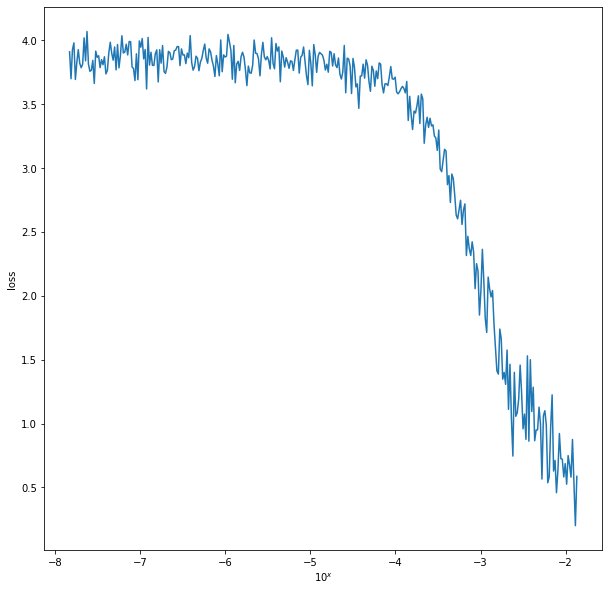

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
10**(-2.5)

0.0031622776601683794

In [ ]:
found_lr = 3e-3
found_lr

0.003

## сбросим ансамбль в начальное состояние перед обучением

In [ ]:
# Загружаем state dicts
model_wide_resnet101_2_40_epoh.load_state_dict(torch.load(path_wide_resnet_40_epoch))
model_wide_resnet101_2_20_epoh.load_state_dict(torch.load(path_wide_resnet_20_epoch))
model_densenet161_60_epoch.load_state_dict(torch.load(path_densenet161_60_epoch))
model_densenet161_20_epoch.load_state_dict(torch.load(path_densenet161_20_epoch))

<All keys matched successfully>

In [ ]:
model_ensemble = MyEnsemble(model_wide_resnet101_2_40_epoh,
                            model_wide_resnet101_2_20_epoh,
                            model_densenet161_60_epoch,
                            model_densenet161_20_epoch)

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

In [ ]:
for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим у model_ensemble
params_ensemble = print_learn_params(model_ensemble)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias


### Итерация 1 (Accuracy: 0.9918)

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=found_lr, amsgrad=True)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
# зададим путь для сохранения модели-ансамбля
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/Ensible_Adam_oversampling_32'

In [ ]:
# Обучаем модель (scor получен не на нем лучше зашрузить веса)
 # Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_ensemble, losses, acc, best_model_wts = train_model(model_ensemble, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.003]
----------
train Loss: 0.4851 Acc: 0.8943
val Loss: 0.0590 Acc: 0.9910

***new best wts with acc 0.9910202521971724 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.003]
----------
train Loss: 0.3013 Acc: 0.9254
val Loss: 0.0624 Acc: 0.9908
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.003]
----------
train Loss: 0.2834 Acc: 0.9283
val Loss: 0.0658 Acc: 0.9897
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.003]
----------
train Loss: 0.2758 Acc: 0.9276
val Loss: 0.0645 Acc: 0.9910
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.003]
----------
train Loss: 0.2750 Acc: 0.9276
val Loss: 0.0658 Acc: 0.9904
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.003]
----------
train Loss: 0.2716 Acc: 0.9299
val Loss: 0.0663 Acc: 0.9912

***new best wts with acc 0.9912113106610623 at 5 epoh***
*** save model wts at this 5 epoch ! *** 

Epoch 6/19 lr=[0.003]
----------
train Loss: 0.2543 Acc: 0.9315
val Loss: 0.0704 Acc: 0.9901
*** save model wts at this 6 epoch ! *** 

Epoch 7/19 lr=[0.003]
----------
train Loss: 0.2591 Acc: 0.9320
val Loss: 0.0650 Acc: 0.9912
*** save model wts at this 7 epoc

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_ensemble.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9918
print("Accuracy: {0:.4f}".format(evaluate(model_ensemble, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9918


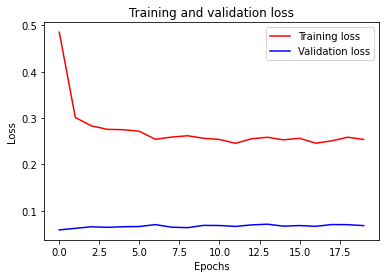

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

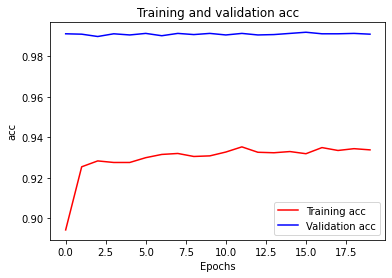

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


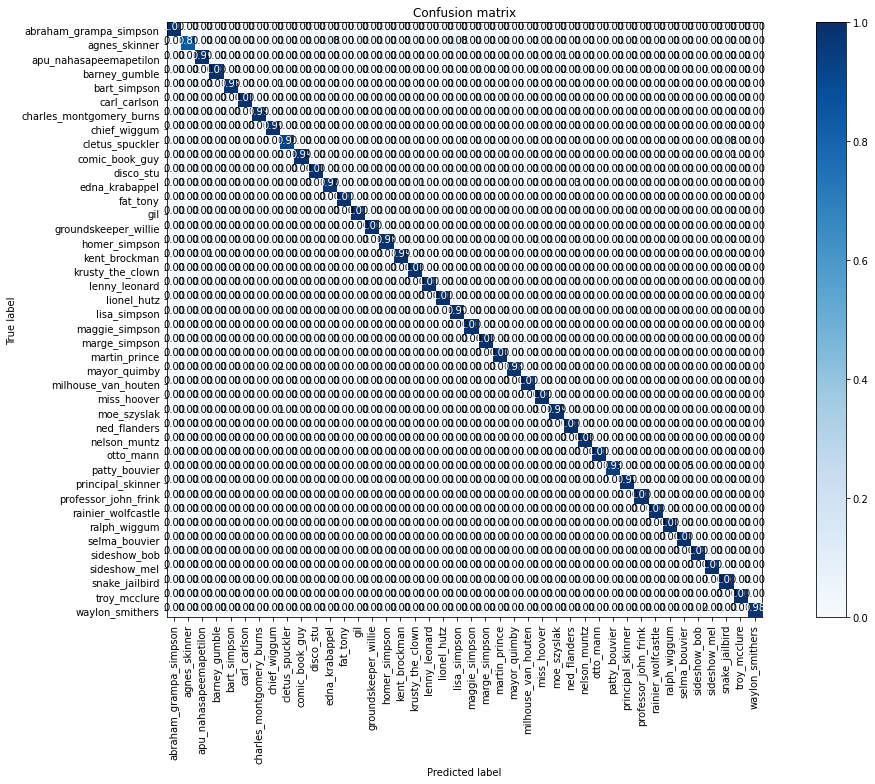

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_ensemble, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[226, 12, 154, 25, 342, 24, 298, 244, 12, 118, 2, 117, 7, 6, 30, 571, 126, 300, 75, 1, 339, 31, 322, 17, 61, 270, 4, 361, 361, 89, 8, 19, 303, 15, 11, 22, 25, 217, 10, 12, 2, 45]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	83 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	91 %
Accuracy of comic_book_guy	99 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	98 %
Accuracy of

### Итерация 2 (Accuracy: 0.9920)

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_ensemble.load_state_dict(torch.load(path + '.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')
print(path + '.pth')

/content/gdrive/My Drive/simpsons_on_cloud_2/Ensible_Adam_oversampling_32.pth


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=found_lr, amsgrad=True)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
# зададим путь для сохранения модели-ансамбля
path = '/content/gdrive/My Drive/simpsons_on_cloud_2/Ensible_Adam_oversampling_32_2'

In [ ]:
# Обучаем модель (scor получен не на нем лучше зашрузить веса)
 # Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_ensemble, losses, acc, best_model_wts = train_model(model_ensemble, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.003]
----------
train Loss: 0.2576 Acc: 0.9331
val Loss: 0.0704 Acc: 0.9914

***new best wts with acc 0.9914023691249523 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.003]
----------
train Loss: 0.2642 Acc: 0.9313
val Loss: 0.0760 Acc: 0.9918

***new best wts with acc 0.9917844860527322 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.003]
----------
train Loss: 0.2532 Acc: 0.9351
val Loss: 0.0772 Acc: 0.9910
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.003]
----------
train Loss: 0.2537 Acc: 0.9328
val Loss: 0.0748 Acc: 0.9914
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.003]
----------
train Loss: 0.2555 Acc: 0.9351
val Loss: 0.0710 Acc: 0.9914
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.003]
----------
train Loss: 0.2460 Acc: 0.9358
val Loss: 0.0744 Acc: 0.9912
*** save model wts at this 5 epoch ! *** 

Epoch 6/19 lr=[0.003]
----------
train Loss: 0.2519 Acc: 0.9338
val Loss: 0.0770 Acc: 0.9904
*** save model wts at this 6 epoch ! *** 

Epoch 7/19 lr=[0.003]
----------
train Loss: 0.2471 Acc: 0.9355
val Loss: 0.0755 Acc: 0.9910
*** save model wts at this 7 epoc

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_ensemble.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9920
print("Accuracy: {0:.4f}".format(evaluate(model_ensemble, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9920


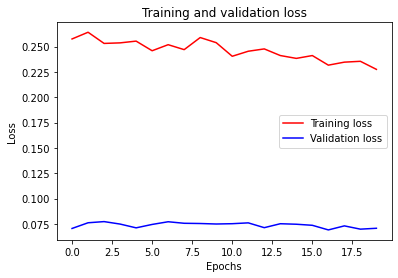

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

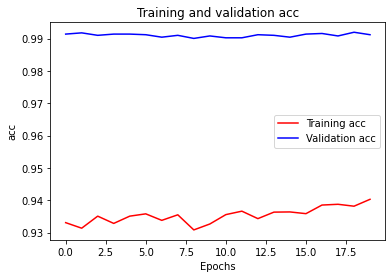

In [ ]:
show_acc_plots(acc, smooth_flag = False)

#### оценка предсказательной точности модели по классам 2 цикл

Normalized confusion matrix


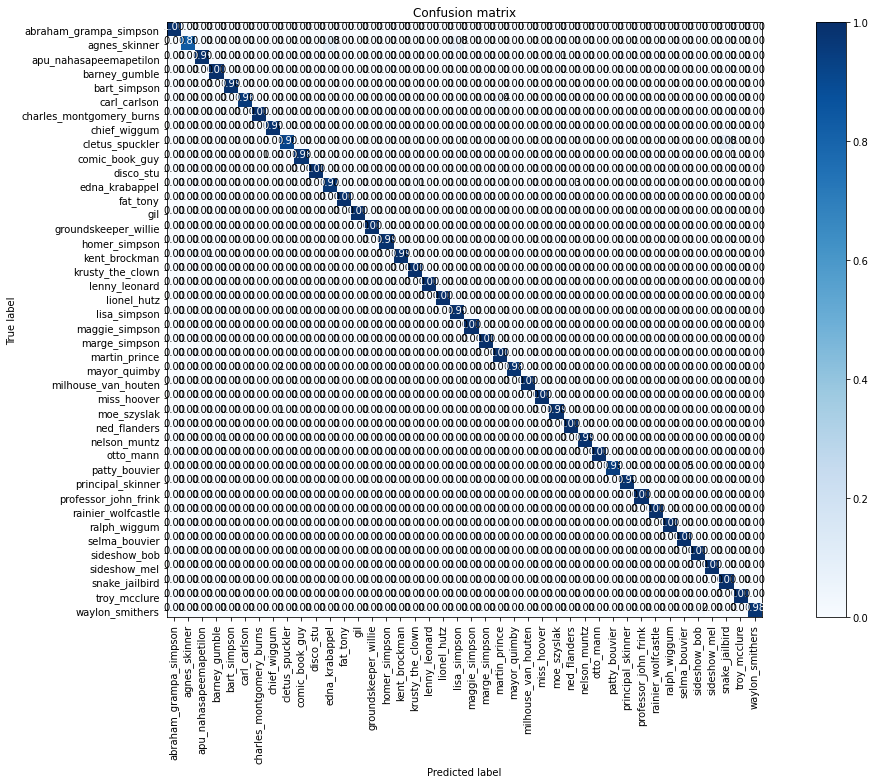

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_ensemble, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[227, 12, 154, 24, 340, 25, 295, 244, 12, 119, 2, 117, 7, 6, 30, 569, 126, 300, 77, 1, 340, 31, 322, 17, 61, 270, 4, 362, 362, 90, 8, 19, 303, 15, 11, 22, 24, 217, 10, 12, 2, 45]
42
Accuracy of abraham_grampa_simpson	99 %
Accuracy of agnes_skinner	83 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	96 %
Accuracy of charles_montgomery_burns	100 %
Accuracy of chief_wiggum	99 %
Accuracy of cletus_spuckler	91 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	100 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	99 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	98 %
Accuracy of 

#### Kaggle Submit (Первый score учитывающийся как финальный)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model_ensemble, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds}) # Каггле берет только с такими заголовками
my_submit.to_csv(path + '_predict.csv', index=False)

## Ансамбль 2

перед тем как создавать ансамбли загрузим чистые модели, чтобы затем загрузить в них лучшие из выбранных нами весов.

Ансамбль:

0.9973809523809524 wide resnet 101-2 DGL(20 эпох) ResNeXt-101-32x8d DGL(40 эпох) ResNeXt-101-32x8d DGL(60 эпох) EfficientNet B6 DGL(20 эпох)

### wide_resnet101_2 DGL

In [ ]:
# Вернем первоначальные веса resnet50
model_wide_resnet101_2_20_epoh = models.wide_resnet101_2(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_wide_resnet101_2_20_epoh.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

### resnext101_32x8d DGL

In [ ]:
# Вернем первоначальные веса resnet50
model_resnext101_32x8d_40_ehoch = models.resnext101_32x8d(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnext101_32x8d_40_ehoch.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
# Вернем первоначальные веса resnet50
model_resnext101_32x8d_60_ehoch = models.resnext101_32x8d(pretrained=True)

#Заменяем родной классификатор model на наш новый линейный классификатор
model_resnext101_32x8d_60_ehoch.fc = nn.Sequential(nn.Linear(2048, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(p=0.3),
                           nn.Linear(128, classes_number)) # посмотреть с dropout и ReLu

###  EfficientNet B6

In [ ]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=599a96ba8c0b8f31d548e69b7bdd9893a9ad5c72d0947bf0b2d9184ab2aee579
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    model = EfficientNet.from_pretrained(model_name, num_classes=classes_number)

    return model

model_name = 'efficientnet-b6'
model_effnet_b6_20_ehoch = get_model(model_name, classes_number)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/checkpoints/efficientnet-b6-c76e70fd.pth



Loaded pretrained weights for efficientnet-b6


### Подберем оптимальный learning rate

batch size = 32

In [ ]:
# Зададим путь для загрузки моделей!
path_wide_resnet_20_epoch = '/content/gdrive/My Drive/simpsons_on_cloud_2/WideResNet101-2_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_best_w.pth'
path_resnext_60_epoch = '/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_3_best_w.pth'
path_resnext_40_epoch = '/content/gdrive/My Drive/simpsons_on_cloud_2/ResNeXt-101-32x8d_DGL_AdamW_aug_oversampling_for_Ensemble_batchsize_32_2_best_w.pth'
path_efficientnet_b6_20_epoch = '/content/gdrive/My Drive/simpsons_on_cloud/Effnet_b6_DGL_fc_linear_AdamW_aug_oversampling_for_Ensemble_batchsize_32_best_w.pth'

In [ ]:
# Загружаем state dicts
model_wide_resnet101_2_20_epoh.load_state_dict(torch.load(path_wide_resnet_20_epoch))
model_resnext101_32x8d_40_ehoch.load_state_dict(torch.load(path_resnext_40_epoch))
model_resnext101_32x8d_60_ehoch.load_state_dict(torch.load(path_resnext_60_epoch))
model_effnet_b6_20_ehoch.load_state_dict(torch.load(path_efficientnet_b6_20_epoch))

<All keys matched successfully>

In [ ]:
model_ensemble = MyEnsemble(model_wide_resnet101_2_20_epoh,
                            model_resnext101_32x8d_40_ehoch,
                            model_resnext101_32x8d_60_ehoch,
                            model_effnet_b6_20_ehoch)

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

In [ ]:
for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим у model_ensemble
params_ensemble = print_learn_params(model_ensemble)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias


In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора Adam
optimizer = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=1e-3, amsgrad=True)

# Задем планировщик изменения learning rate нашего оптимизатора.
# будет просто умножать lr optimizer на gamma, каждые step_size эпох.
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
# подбор оптимального lr для классификатора model.fc
logs, losses = find_lr(model_ensemble, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

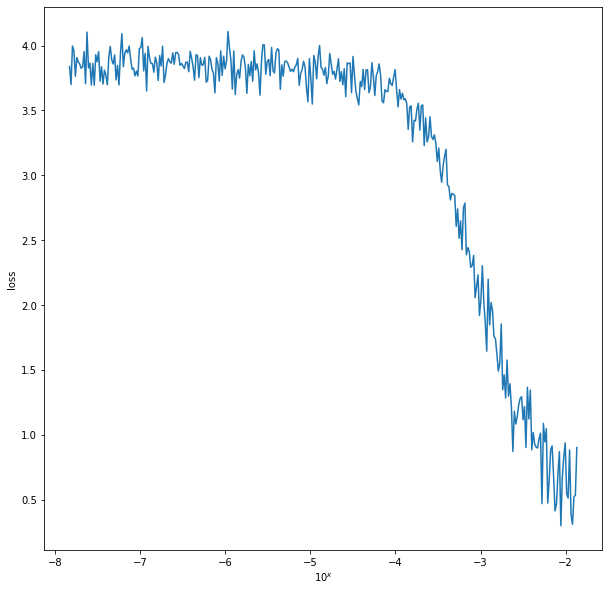

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
10**(-2.5)

0.0031622776601683794

In [ ]:
found_lr = 3e-3
found_lr

0.003

### сбросим ансамбль в начальное состояние перед обучением

In [ ]:
# Загружаем state dicts
model_wide_resnet101_2_20_epoh.load_state_dict(torch.load(path_wide_resnet_20_epoch))
model_resnext101_32x8d_40_ehoch.load_state_dict(torch.load(path_resnext_40_epoch))
model_resnext101_32x8d_60_ehoch.load_state_dict(torch.load(path_resnext_60_epoch))
model_effnet_b6_20_ehoch.load_state_dict(torch.load(path_efficientnet_b6_20_epoch))

In [ ]:
model_ensemble = MyEnsemble(model_wide_resnet101_2_20_epoh,
                            model_resnext101_32x8d_40_ehoch,
                            model_resnext101_32x8d_60_ehoch,
                            model_effnet_b6_20_ehoch)

In [ ]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

In [ ]:
for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [ ]:
# посмотрим какие параметры учим у model_ensemble
params_ensemble = print_learn_params(model_ensemble)

Params to update:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias


#### Итерация 1 (Accuracy: 0.9925)

In [ ]:
# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора AdaShift из репозитория МФТИ
optimizer = torch.optim.Adam(model_ensemble.classifier.parameters(), lr=found_lr, amsgrad=True)

# Использовать ли GPU
model_ensemble = model_ensemble.cuda()

In [ ]:
# зададим путь для сохранения модели-ансамбля
path = '/content/gdrive/My Drive/simpsons_on_cloud/Ensible2_Adam_oversampling_32'

In [ ]:
# Обучаем модель (scor получен не на нем лучше зашрузить веса)
 # Обучаем модель (Неиспользуется в финальном score можно сразу загрузить веса!)
model_ensemble, losses, acc, best_model_wts = train_model(model_ensemble, dataloaders, loss_fn, optimizer, num_epochs=20, flag_save_wts_to_file=True, path=path)          

Logging...


Epoch 0/19 lr=[0.003]
----------
train Loss: 0.4650 Acc: 0.8972
val Loss: 0.0561 Acc: 0.9899

***new best wts with acc 0.9898739014138326 at 0 epoh***
*** save model wts at this 0 epoch ! *** 



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch 1/19 lr=[0.003]
----------
train Loss: 0.2717 Acc: 0.9303
val Loss: 0.0624 Acc: 0.9906

***new best wts with acc 0.9906381352693925 at 1 epoh***
*** save model wts at this 1 epoch ! *** 

Epoch 2/19 lr=[0.003]
----------
train Loss: 0.2573 Acc: 0.9346
val Loss: 0.0677 Acc: 0.9903
*** save model wts at this 2 epoch ! *** 

Epoch 3/19 lr=[0.003]
----------
train Loss: 0.2461 Acc: 0.9343
val Loss: 0.0637 Acc: 0.9912

***new best wts with acc 0.9912113106610623 at 3 epoh***
*** save model wts at this 3 epoch ! *** 

Epoch 4/19 lr=[0.003]
----------
train Loss: 0.2600 Acc: 0.9314
val Loss: 0.0665 Acc: 0.9906
*** save model wts at this 4 epoch ! *** 

Epoch 5/19 lr=[0.003]
----------
train Loss: 0.2465 Acc: 0.9367
val Loss: 0.0693 Acc: 0.9910
*** save model wts at this 5 epoch ! *** 

Epoch 6/19 lr=[0.003]
----------
train Loss: 0.2313 Acc: 0.9389
val Loss: 0.0643 Acc: 0.9912
*** save model wts at this 6 epoch ! *** 

Epoch 7/19 lr=[0.003]
----------
train Loss: 0.2358 Acc: 0.9373
val 

In [ ]:
# загрузим состояние нашей модели, ее веса при которых было достигнута лучшая
# точность, а так же losses и accurancy
model_ensemble.load_state_dict(torch.load(path + '_best_w.pth'))
losses = load_dict_from_file(path + '_losses.pickle')
acc = load_dict_from_file(path + '_acc.pickle')

In [ ]:
# посчитаем Accuracy на всей валидационной выборке Accuracy: 0.9925
print("Accuracy: {0:.4f}".format(evaluate(model_ensemble, dataloaders['val'], DEVICE, use_gpu =True)))

Accuracy: 0.9925


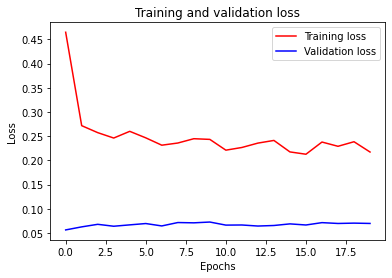

In [ ]:
show_losses_plots(losses, smooth_flag = False, min = 0)

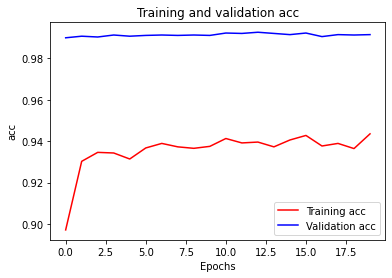

In [ ]:
show_acc_plots(acc, smooth_flag = False)

##### оценка предсказательной точности модели по классам 1 цикл

Normalized confusion matrix


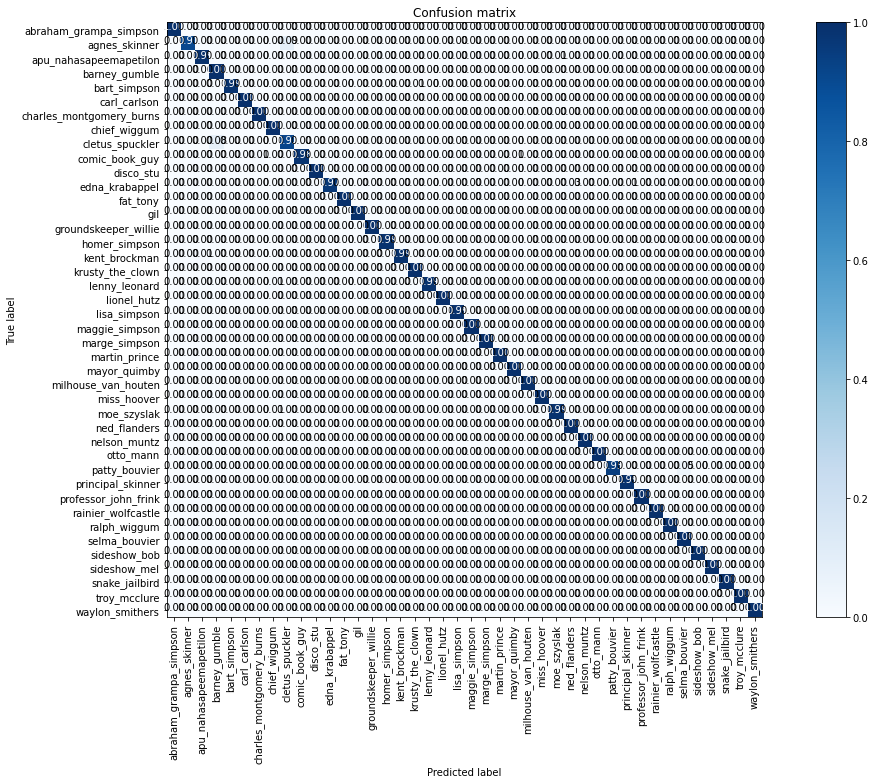

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all, feature_names = show_confusion_matrix_fucn(model_ensemble, dataloaders)

In [ ]:
# Выведем точность для каждого класса
accurancy_for_each_class(y_test_all, predictions_all, feature_names)

[227, 11, 154, 24, 341, 24, 295, 241, 12, 119, 2, 118, 7, 7, 30, 568, 126, 299, 78, 1, 342, 31, 322, 18, 60, 270, 4, 367, 361, 89, 8, 19, 301, 14, 10, 21, 25, 218, 10, 14, 2, 44]
42
Accuracy of abraham_grampa_simpson	100 %
Accuracy of agnes_skinner	90 %
Accuracy of apu_nahasapeemapetilon	99 %
Accuracy of barney_gumble	100 %
Accuracy of bart_simpson	98 %
Accuracy of carl_carlson	100 %
Accuracy of charles_montgomery_burns	99 %
Accuracy of chief_wiggum	100 %
Accuracy of cletus_spuckler	91 %
Accuracy of comic_book_guy	98 %
Accuracy of disco_stu	100 %
Accuracy of edna_krabappel	96 %
Accuracy of fat_tony	100 %
Accuracy of   gil	100 %
Accuracy of groundskeeper_willie	100 %
Accuracy of homer_simpson	98 %
Accuracy of kent_brockman	99 %
Accuracy of krusty_the_clown	99 %
Accuracy of lenny_leonard	98 %
Accuracy of lionel_hutz	100 %
Accuracy of lisa_simpson	98 %
Accuracy of maggie_simpson	100 %
Accuracy of marge_simpson	100 %
Accuracy of martin_prince	100 %
Accuracy of mayor_quimby	100 %
Accuracy o

##### Kaggle Submit (Второй score учитывающийся как финальный)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model_ensemble, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds}) # Каггле берет только с такими заголовками
my_submit.to_csv(path + '_predict.csv', index=False)

# Сводная таблица по ансамблям

| ﻿Persons                  | RawDataset(Train part) | oversampling Dataset(Train part) | Ансамбль1(20 эпох) | Ансамбль1(40 эпох) | Ансамбль2(20 эпох) |
|--------------------------|------------------------|----------------------------------|--------------------|--------------------|--------------------|
| abraham_grampa_simpson   | 685                    | 685                              | 1                  | 0,99               | 1                  |
| agnes_skinner            | 32                     | 100                              | 0,83               | 0,83               | 0,9                |
| apu_nahasapeemapetilon   | 467                    | 467                              | 0,99               | 0,99               | 0,99               |
| barney_gumble            | 80                     | 100                              | 1                  | 1                  | 1                  |
| bart_simpson             | 1006                   | 1006                             | 0,98               | 0,98               | 0,98               |
| carl_carlson             | 74                     | 100                              | 1                  | 0,96               | 1                  |
| charles_montgomery_burns | 895                    | 895                              | 0,99               | 1                  | 0,99               |
| chief_wiggum             | 739                    | 739                              | 0,99               | 0,99               | 1                  |
| cletus_spuckler          | 35                     | 100                              | 0,91               | 0,91               | 0,91               |
| comic_book_guy           | 352                    | 352                              | 0,99               | 0,98               | 0,98               |
| disco_stu                | 6                      | 100                              | 1                  | 1                  | 1                  |
| edna_krabappel           | 343                    | 343                              | 0,96               | 0,96               | 0,96               |
| fat_tony                 | 20                     | 100                              | 1                  | 1                  | 1                  |
| gil                      | 20                     | 100                              | 1                  | 1                  | 1                  |
| groundskeeper_willie     | 91                     | 100                              | 1                  | 1                  | 1                  |
| homer_simpson            | 1684                   | 1684                             | 0,98               | 0,98               | 0,98               |
| kent_brockman            | 373                    | 373                              | 0,99               | 0,99               | 0,99               |
| krusty_the_clown         | 904                    | 904                              | 0,99               | 0,99               | 0,99               |
| lenny_leonard            | 233                    | 233                              | 1                  | 1                  | 0,98               |
| lionel_hutz              | 2                      | 100                              | 1                  | 1                  | 1                  |
| lisa_simpson             | 1015                   | 1015                             | 0,99               | 0,99               | 0,98               |
| maggie_simpson           | 96                     | 100                              | 1                  | 1                  | 1                  |
| marge_simpson            | 968                    | 968                              | 1                  | 1                  | 1                  |
| martin_prince            | 53                     | 100                              | 1                  | 1                  | 1                  |
| mayor_quimby             | 185                    | 185                              | 0,98               | 0,98               | 1                  |
| milhouse_van_houten      | 809                    | 809                              | 1                  | 1                  | 1                  |
| miss_hoover              | 13                     | 100                              | 1                  | 1                  | 1                  |
| moe_szyslak              | 1089                   | 1089                             | 0,99               | 0,99               | 0,98               |
| ned_flanders             | 1090                   | 1090                             | 0,99               | 0,99               | 0,99               |
| nelson_muntz             | 269                    | 269                              | 1                  | 0,98               | 1                  |
| otto_mann                | 24                     | 100                              | 1                  | 1                  | 1                  |
| patty_bouvier            | 54                     | 100                              | 0,94               | 0,94               | 0,94               |
| principal_skinner        | 895                    | 895                              | 0,98               | 0,98               | 0,99               |
| professor_john_frink     | 49                     | 100                              | 1                  | 1                  | 1                  |
| rainier_wolfcastle       | 34                     | 100                              | 1                  | 1                  | 1                  |
| ralph_wiggum             | 67                     | 100                              | 1                  | 1                  | 1                  |
| selma_bouvier            | 77                     | 100                              | 1                  | 1                  | 1                  |
| sideshow_bob             | 658                    | 658                              | 1                  | 1                  | 1                  |
| sideshow_mel             | 30                     | 100                              | 1                  | 1                  | 1                  |
| snake_jailbird           | 41                     | 100                              | 1                  | 1                  | 1                  |
| troy_mcclure             | 6                      | 100                              | 1                  | 1                  | 1                  |
| waylon_smithers          | 136                    | 136                              | 0,97               | 0,97               | 1                  |
| mean acc by class        | -                      | -                                | 0,98667            | 0,985              | 0,98881            |
|                          |                        |                                  |                    | Фин скор 1          | Фин скор 2           |

Интересное наблюдение: 
* ансамбль с двумя линейными слоями в качестве классификатора предсказаний от нейросетей получается лучше.

Интересны так же получаемые данным подходом результаты:

Изначально я думал, что ансамбль возмет максимальную точность по классу откаждой из входящих в него нейросетей. На некоторых классах ансамбль действительно взял максимальную точность из входящих в него нейросетей, где-то дал большую точность по классу, чем кадая из нейросетей его составляющих, а где-то ансамбль оказалсся хуже, чем каждая нейросеть по отдельности.

Т.е. точность ансамбля может быть как выше точности каждой из нейросетей его составляющих, может быть равна максимальной точности из двух, а может быть и меньшt, чем у минимальной из двух.

Честно говоря такого, я не ожидал.

![alt text](http://img1.joyreactor.cc/pics/post/full/политика-суд-telegram-социальные-сети-4412903.jpeg)
